# Numerical resolution of KdV equation using a Finite Volume method

## Model : Korteweg - de Vries (KdV) equation :

We will compute an approximate solution to the KdV equation, which models a wave propagation accpounting for nonlinear ansd dispersive effects : 

\begin{equation}
\begin{cases}
    u_t + au_x + b(u^2)_x + u_{xxx} = 0 \ , \ \ x \in [x_{min},x_{max}], \ \ t \in [0, t_{max}] \\
    u(x,0) = \Phi(x)
\end{cases}
\end{equation}

The constant coefficients $a$ and $b$ were introduced in order to analyze the influence of the phenomena acting in the model (pure advrection, nonlinearity and diffusion).

The kdV equation will be split in two equations, leading to the resolution of the following problem in each time step: 

\begin{equation}
\begin{cases}
    v_t + av_x + b(v^2)_x = 0 \ \ ,\ t \in [t_n,t_{n+1}], \  v(t_n) = u(t_n) \\
    w_t + w_{xxx} = 0 \ \ , \ t \in [t_n,t_{n+1}], \  w(t_n) = v(t_{n+1}) \\
    u(t_{n+1}) = v(t_{n+1})
\end{cases}
\end{equation}

## First equation
$ v_t + f(v)_x = 0, \ \ f(v) = av + bv^2 $


### Temporal discretization

#### Euler
$v_i^{n+1} = v_i^n - \Delta t  \  f(v_i^n)_x$

#### 4th order Runge-Kutta
\begin{equation}
\begin{cases}
k_1 = - f(v_i^n)_x \\
k_2 = - f\left(v_i^n + k_1\frac{\Delta t }{2}\right)_x \\
k_3 = - f\left(v_i^n + k_2\frac{\Delta t }{2}\right)_x \\
k_4 = - f(v_i^n + k_3 \Delta t)_x \\
v_i^{n+1} = v_i^n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{cases}
\end{equation}



### Spatial discretization
$ f(v_i^n)_x = \frac{f\left(v_{i+1/2}^n\right) - f\left(v_{i-1/2}^n\right)}{\Delta x}$


### Choice of the steps
In the non-conservative form, the equation is written as

$v_t +  (1+2v)v_x = 0$

which configures an advection problem with velocity $1+2v$

The space and time steps must verify the CFL condition : 

$(a+2bv)\frac{\Delta t}{\Delta x} \leq 1$

in order to avoid non-physical behaviours (e.g. mass increasing). Thereforem for each time step, we will chose, for small $\epsilon$

$\Delta t = \frac{\Delta x}{a+2b\max\limits_{x}|v|} - \epsilon$





### Evaluation of the solution on cell interfaces : resolution of the Riemann problem
In each interface between two cells of the discrete domain, the follozing Riemann problem will be solved :

\begin{equation}
\begin{cases}
v_t + f(v)_x = 0 \\
v(x,0) = v^- \ , \ x < 0 \\
v(x,0) = v^+ \ , \ x > 0
\end{cases}
\end{equation}

where the boundary is located at $x=0$ and $v^-$ and $v^+$ are the solutions in its two neighbour cells.

The flux function $f$ is uniformly convex, so the Riemann problem has a unique weak, admissible solution (REFERENCE) :

* If $v^- > v^+$  (shock) : 
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \   f(v^-) > f(v^+) \\
v^+ \ ,\ \ f(v^-) < f(v^+)
\end{cases}
\end{equation}

* If $v^+ > v^-$  (rarefaction wave) :
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \ f'(v^-) > 0 \\
\left(f'\right)^{-1}(v) \ ,\ \ f'(v^-) < 0 < f'(v^+) \\
v^+ \ ,\ \ f'(v^+) < 0 
\end{cases}
\end{equation}

## Second equation

The second equation will be solved using the Fourier method. Let $\hat{w}(k,t_n)$ be the Fourier coefficients of $w(x,t_n)$.  The Fourier transform of the equation

$w_t+w_{xxx}=0$

gives

$(\hat{w})_t(k,t) - ik^3\hat{w}(k,t)$ = 0

It is an ODE in $t$ which solution is
$\hat{w}(k,t) = e^{ik^3(t-t_n)}\hat{w}(k,t_n)$

The inverse Fourier transform using the coefficients $\hat{w}(k,t_{n+1})$ gives $w(x,t_{n+1})$

## Model functions

In [1]:
%%writefile kdv.py

import numpy as np
def Flux(u,a,b):
    return a*u + b*u*u
def Fluxder(u,a,b):
    return a + 2.0*b*u
def Fluxderinv(u,a,b):
    return (u-1.*a)/(2.*b)

Overwriting kdv.py


In [2]:
%%writefile kdv.py -a

def Riemann(u,x,t,a,b):
    uint = np.zeros_like(x)
    for  i in range(0,x.size-1):
        #incl = x[i]/t
        incl = 0
        um = u[i]
        up = u[i+1]
        if um == up :
            uint[i] = um
        elif  um > up:
            sigma = (Flux(um,a,b) - Flux(up,a,b))/(um-up)
            if incl < sigma:
                uint[i] = um
            else:
                uint[i] = up
        else:
            if incl < Fluxder(um,a,b) :
                uint[i] = um
            elif incl > Fluxder(up,a,b) :
                uint[i] = up
            else:
                uint[i] = Fluxderinv(incl,a,b)
    #uint[0] = u[0]
    uint[x.size-1] = u[x.size-1]
    return uint

Appending to kdv.py


In [3]:
%%writefile kdv.py -a

def Euler(u,dx,dt,periodic):
    umm = np.roll(u,1)
    if periodic :
        umm[0] = u[u.size-1]
    
    f = Flux(u)
    fmm = Flux(umm)
    
    u2 = u - dt/dx*(f-fmm)
    
    return u2

Appending to kdv.py


In [4]:
%%writefile kdv.py -a

def getRKCoef(u,x,t,dx,dt,a,b,periodic):
    uint = Riemann(u,x,t,a,b)
    uintmm = np.roll(uint,1)
    if periodic :
        uintmm[0] = uint[u.size-1]
    f = Flux(uint,a,b)
    fmm = Flux(uintmm,a,b)
    return dt*(fmm-f)/dx
        
def RK4(u,x,t,dx,dt,a,b,periodic):
        
    k1 = getRKCoef(u,x,t,dx,dt,a,b,periodic)
    k2 = getRKCoef(u+k1/2,x,t,dx,dt,a,b,periodic)
    k3 = getRKCoef(u+k2/2,x,t,dx,dt,a,b,periodic)
    k4 = getRKCoef(u+k3,x,t,dx,dt,a,b,periodic)
    
    u2 = u + 1./6.*(k1+2*k2+2*k3+k4)
    
    return u2

Appending to kdv.py


In [5]:
%%writefile kdv.py -a

def FourierSolver(u,t,dt,dx):
    freq = np.linspace(0,u.size-1,u.size)
    uhat = np.fft.fft(u)
    uhat = uhat*np.exp(dt*1.j*np.power(np.fft.fftfreq(uhat.size,d=dx),3))
    u2 = np.fft.ifft(uhat)
#    if not (np.all(np.isreal(u2))):
#        print(u2)
#        sys.exit("Error in Fourier method")
    return np.real(u2)

Appending to kdv.py


In [6]:
%%writefile kdv.py -a

def runRk4FVFourier(x,u,t0,tmax,a,b):
    t = t0
    tall = np.ones(1)*t0
    u0 = u
    uall = u
    u0min = np.amin(u)
    u0max = np.amax(u)
    dx = np.diff(x)[0]
    iter = 0
    eps = 1e-6

    ##### Parameters
    printstep = 5
    periodic = 1
    #a = 1
    #b = 1


    while t<tmax:
        iter = iter + 1
        umax = np.amax(np.absolute(u))
        dt = dx/(1.*a+2*b*umax) - eps     # CFL CONDITION (???)
        dt = 0.01
        #dt = dx
        t = t+dt
        u = RK4(u,x,t,dx,dt,a,b,periodic)
        u = FourierSolver(u,t,dt,dx)

        if not periodic:
            u[0] = uleft ## Boundary conditions ?
            u[nx] = uright
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
    return uall,tall


Appending to kdv.py


## Case study 1: Square profile

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Spatial discretization

In [8]:
L = 2
xmin = 0
xmax = L
dx = 0.025
nx = int((xmax-xmin)/dx)
x = np.linspace(xmin, xmax,nx+1)

### Initial condition

In [9]:
u = np.zeros(x.shape) # On the cells
u = np.where( (x>=0.3)*(x<=0.4), 1.0, u)

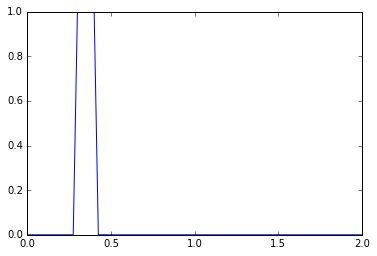

In [10]:
plt.plot(x,u)

### The simulation

In [11]:
import kdv
uall, tall = kdv.runRk4FVFourier(x,u,t0=0,tmax=2,a=1,b=1)

### Animation of the solution


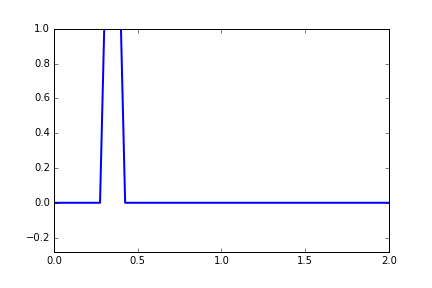
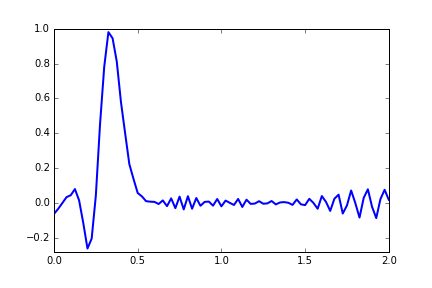
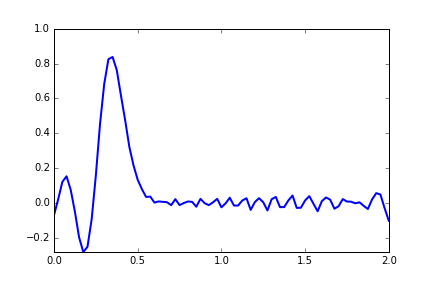
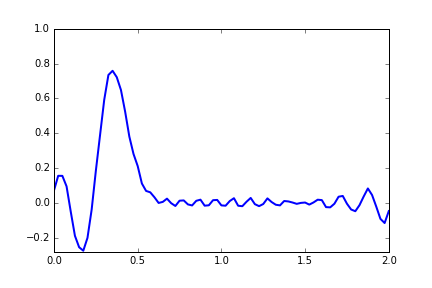
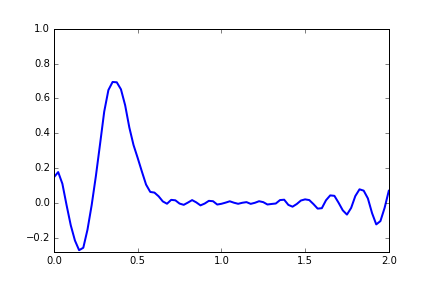
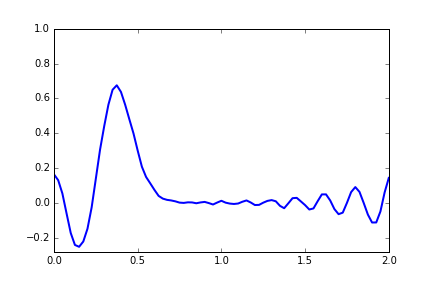
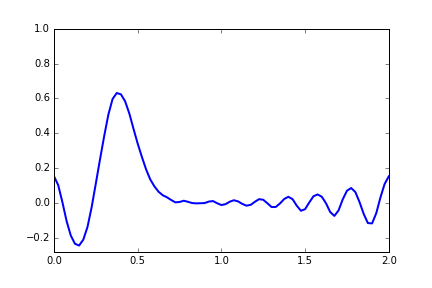
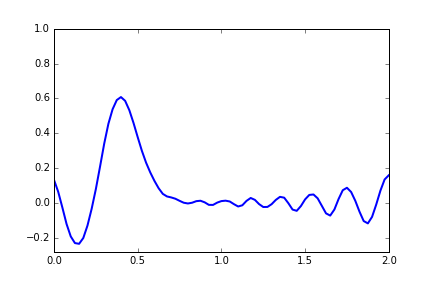
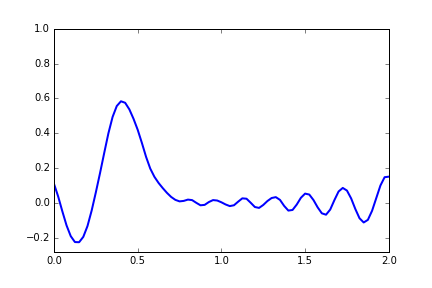
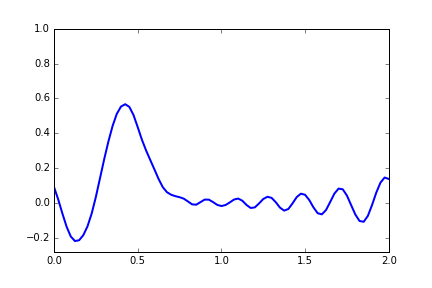
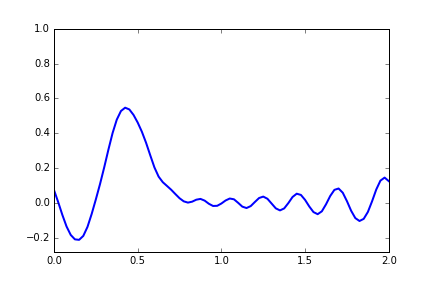
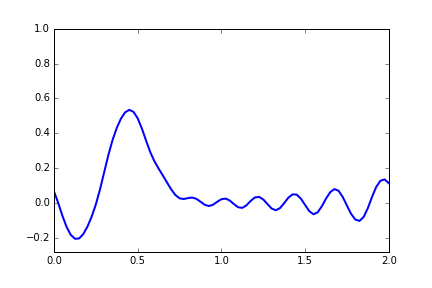
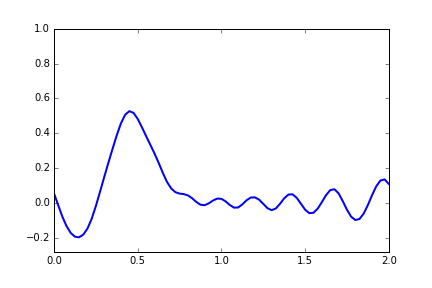
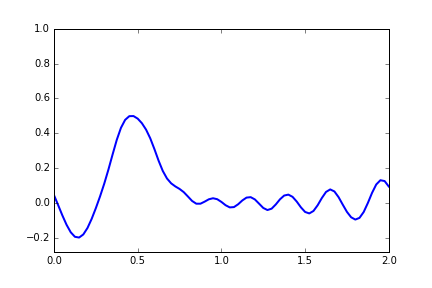
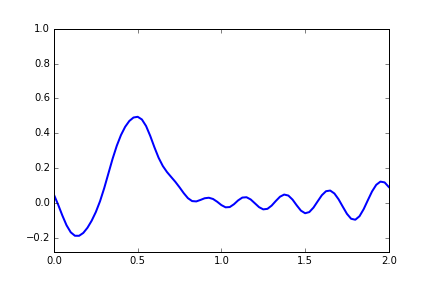
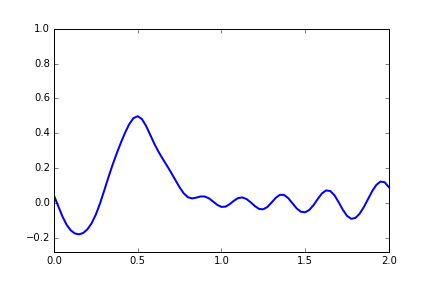
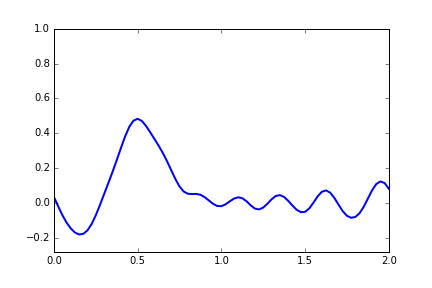
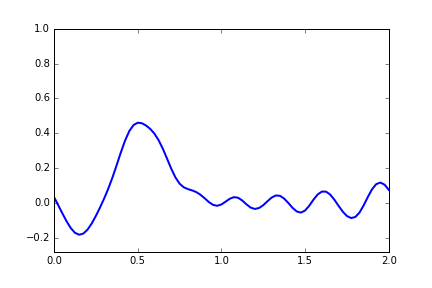
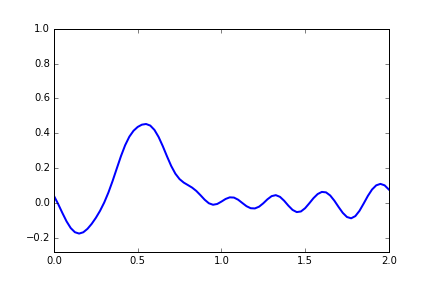
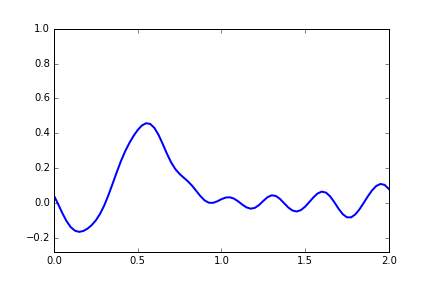
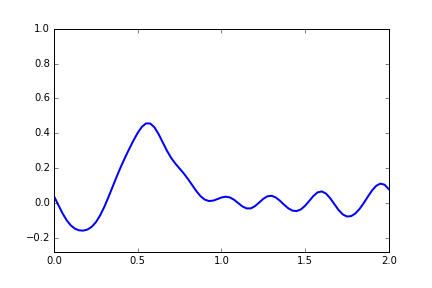
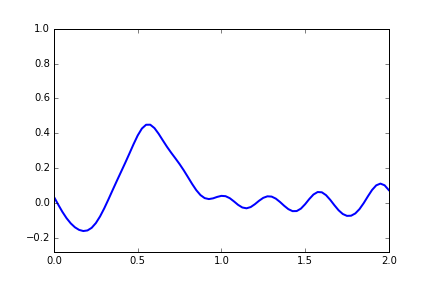
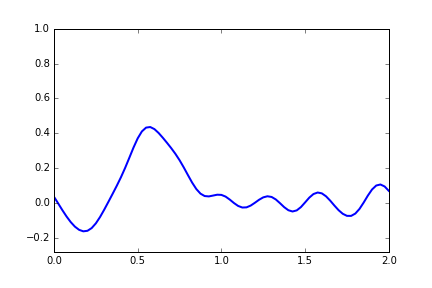
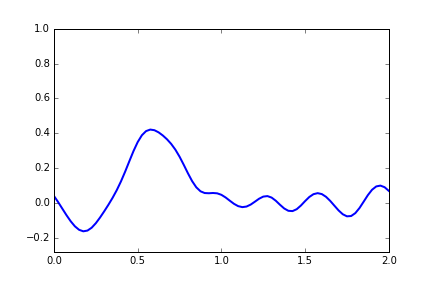
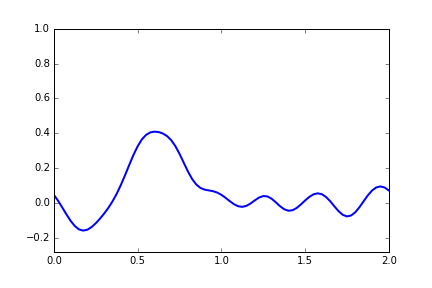
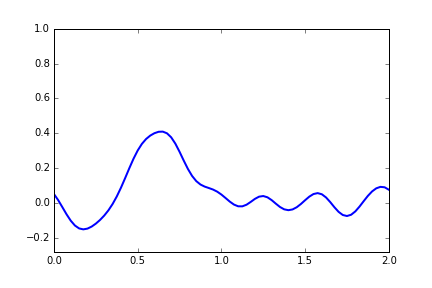
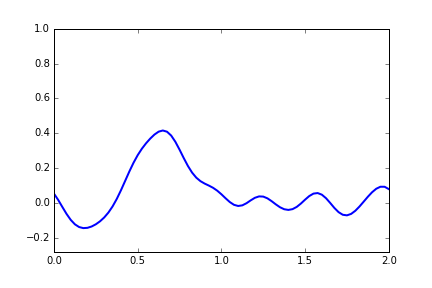
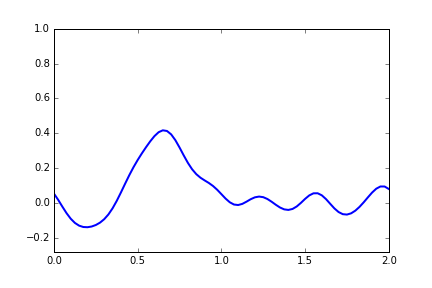
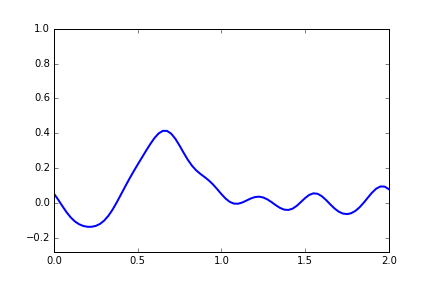
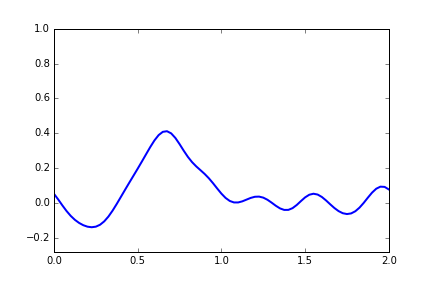
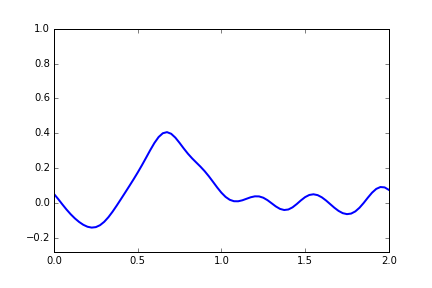
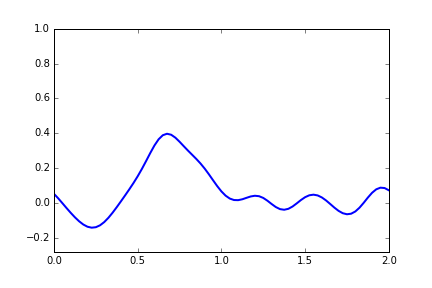
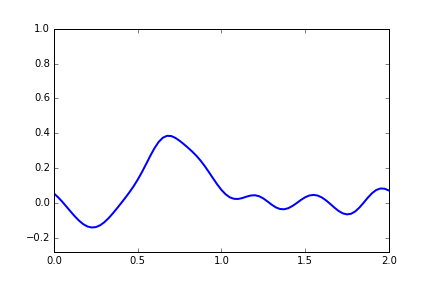
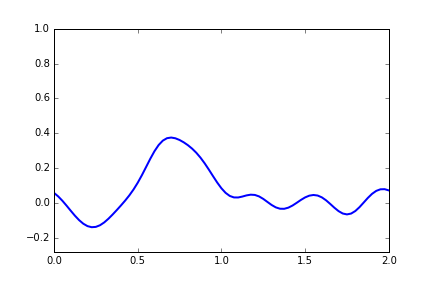
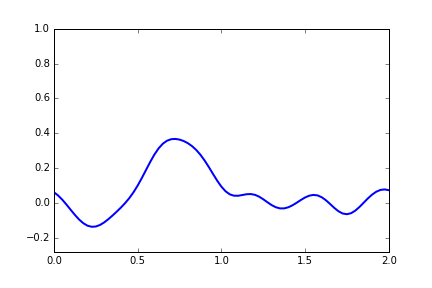
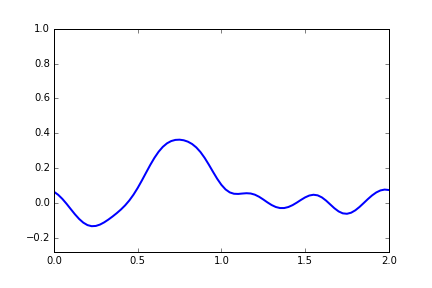
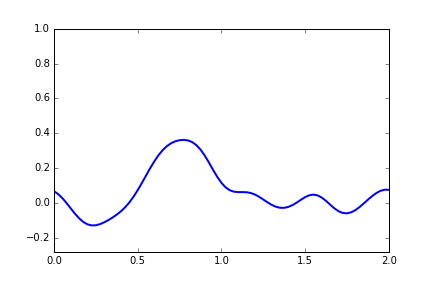
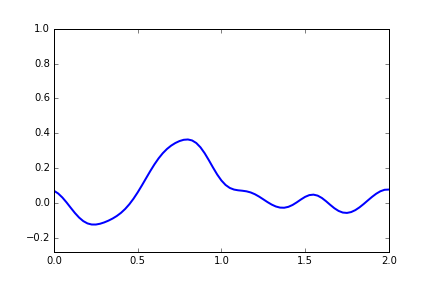
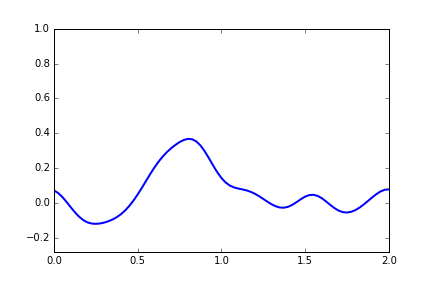
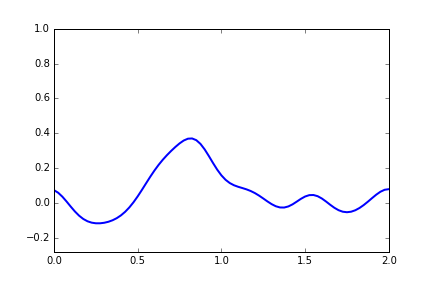
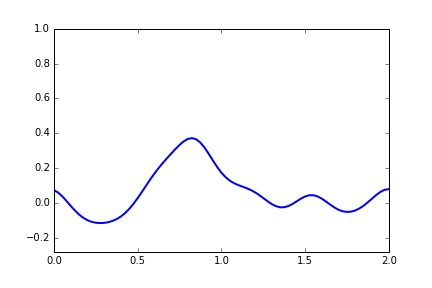
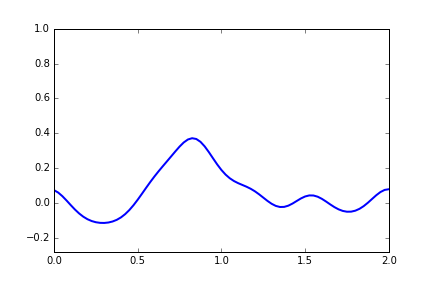
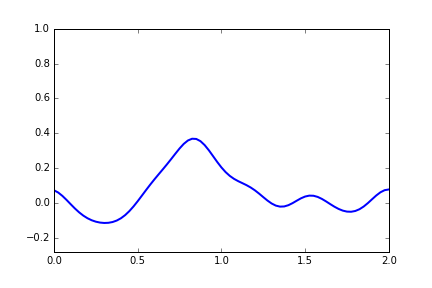
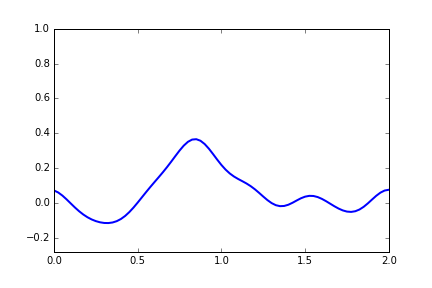
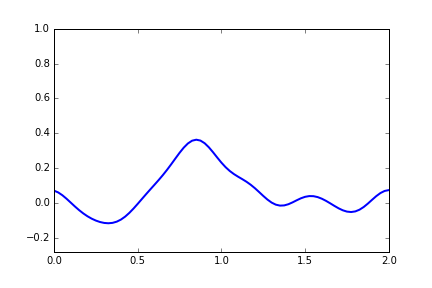
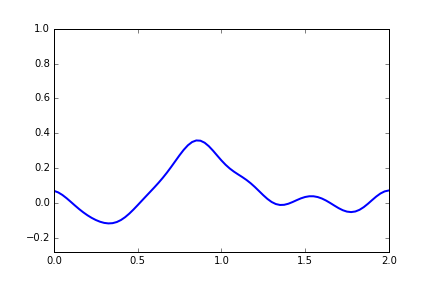
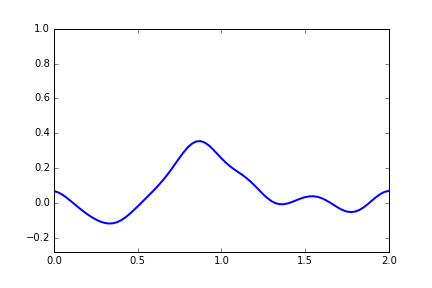
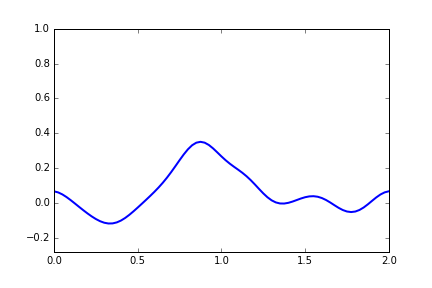
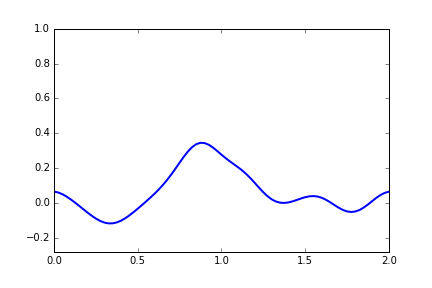
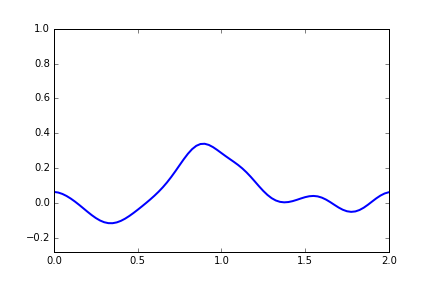
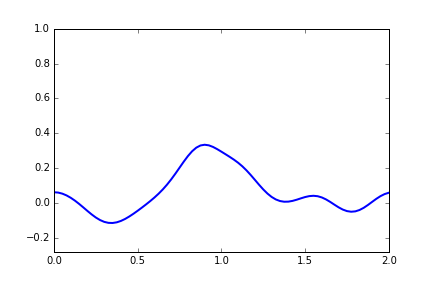
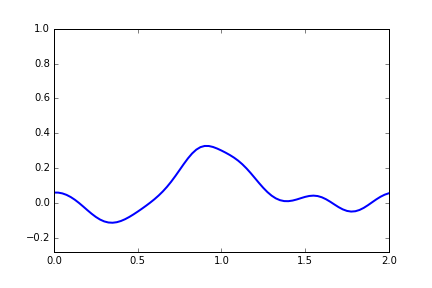
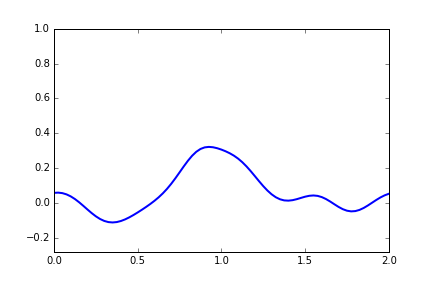
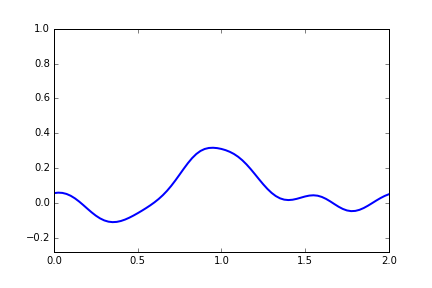
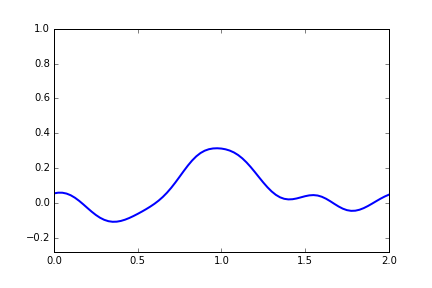
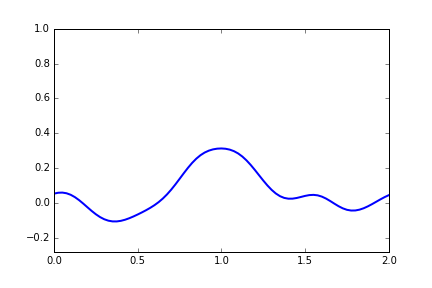
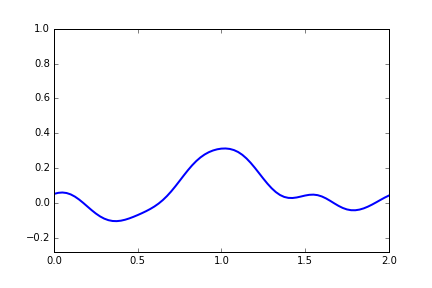
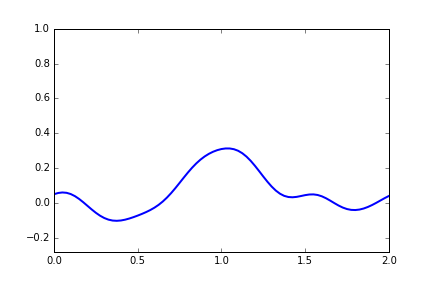
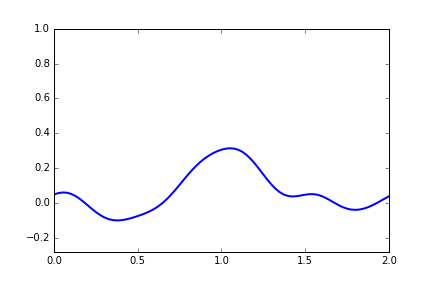
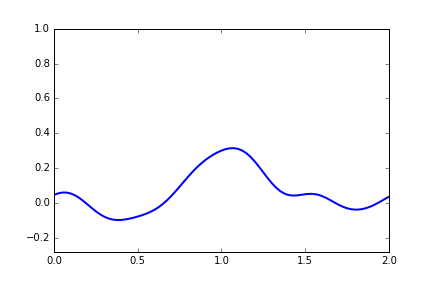
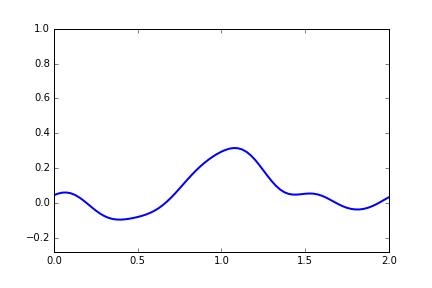
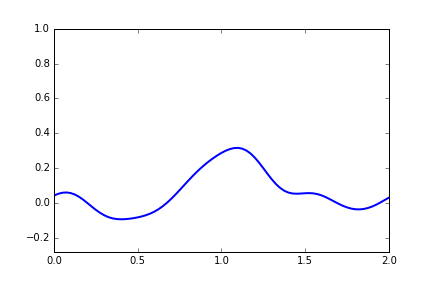
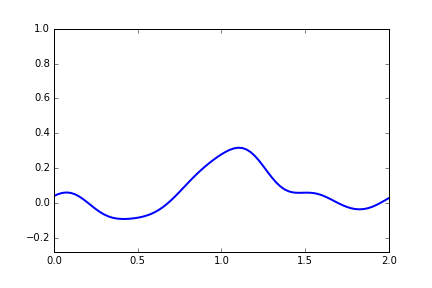
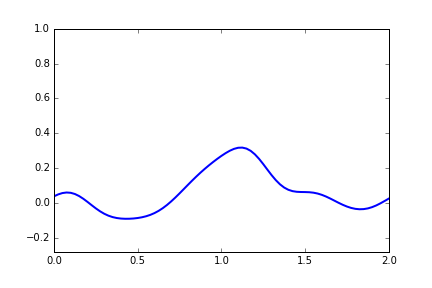
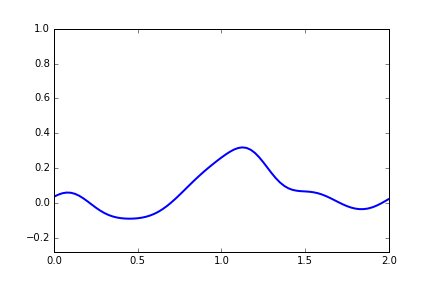
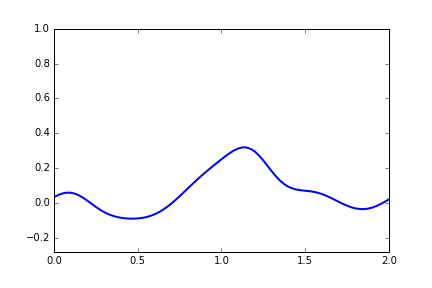
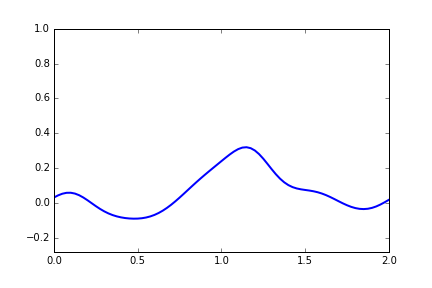
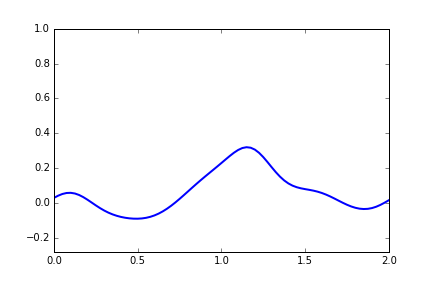
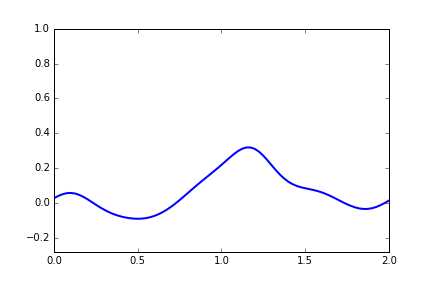
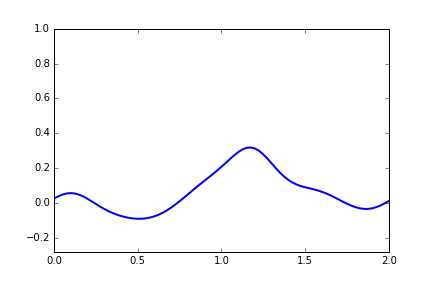
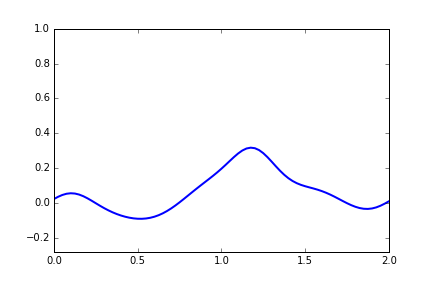
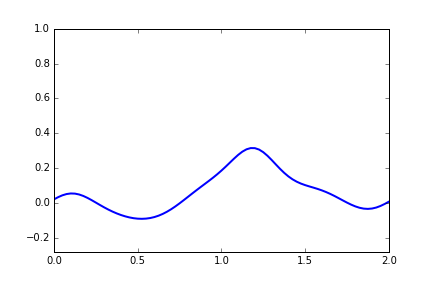
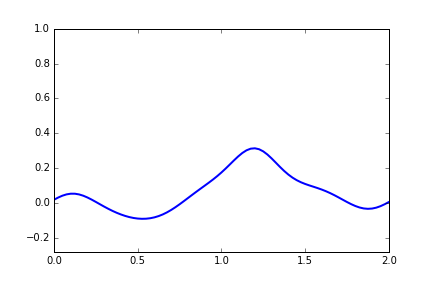
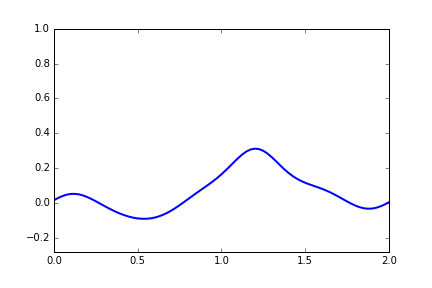
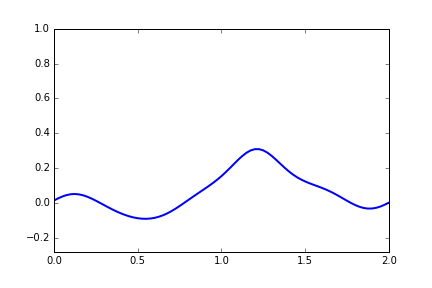
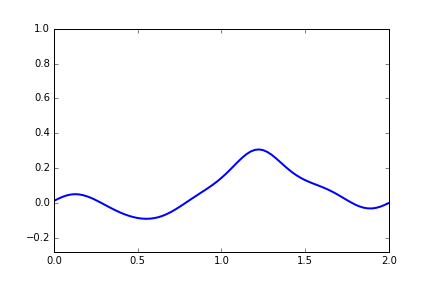
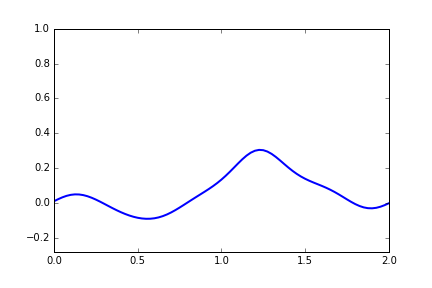
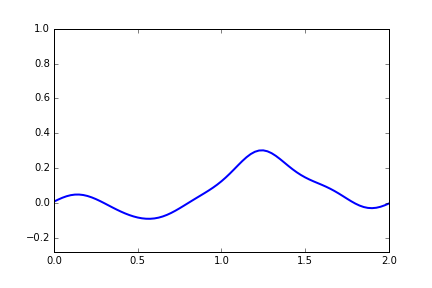
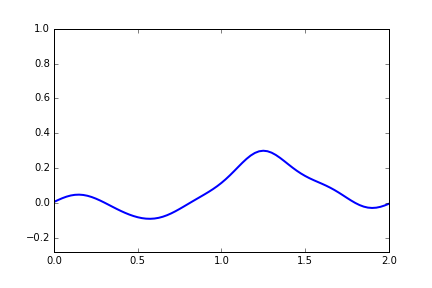
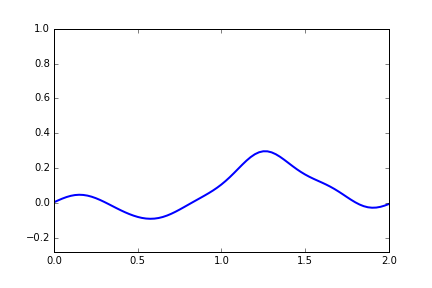
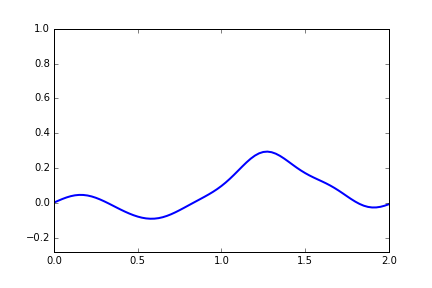
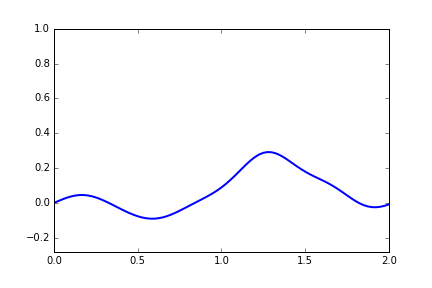
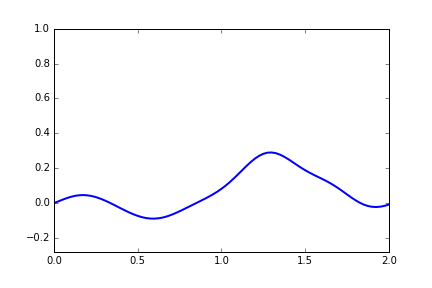
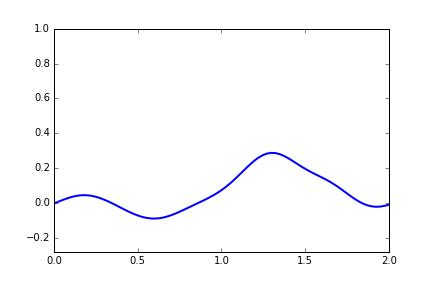
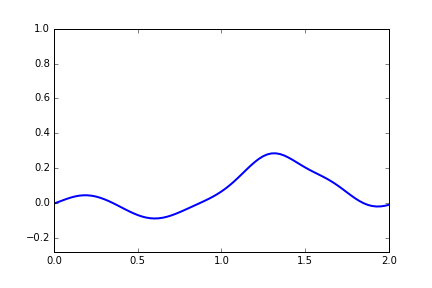
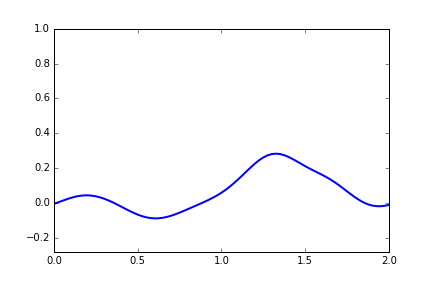
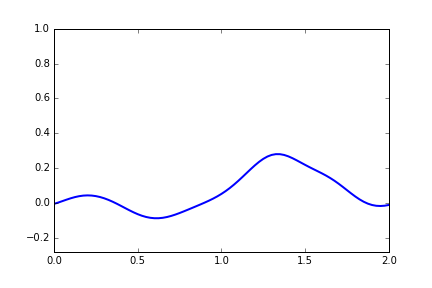
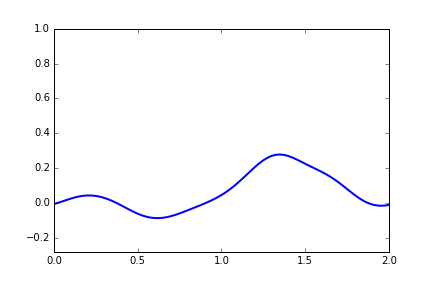
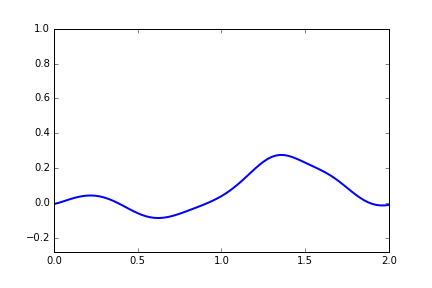
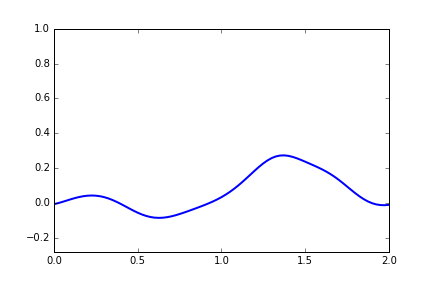
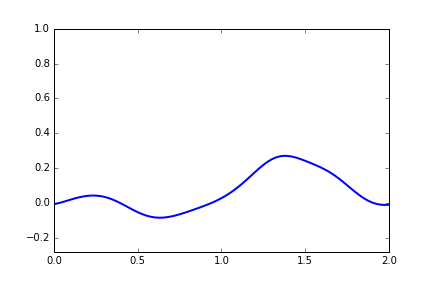
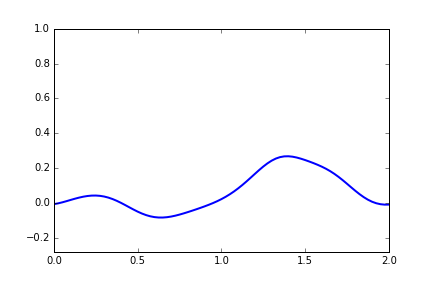
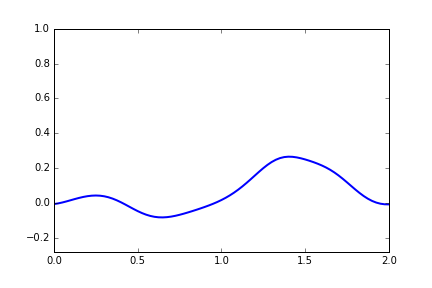
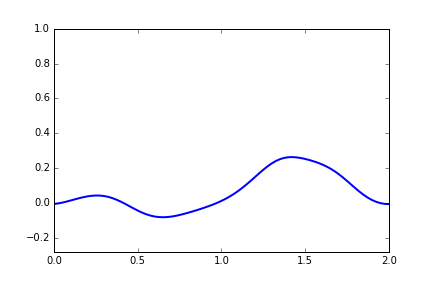
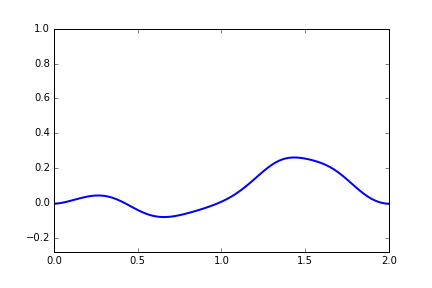
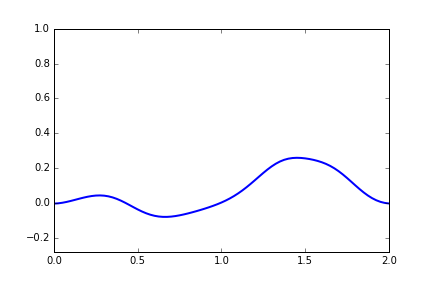
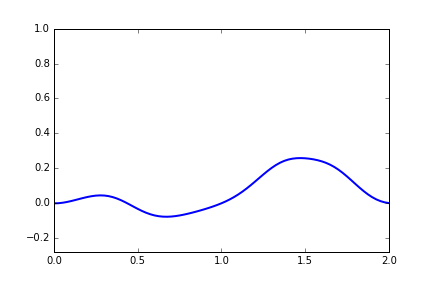
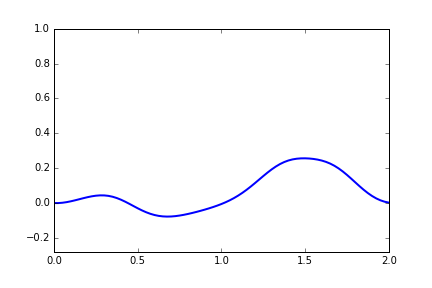
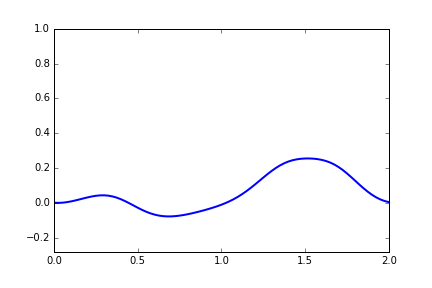
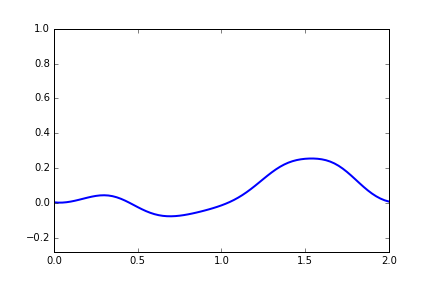
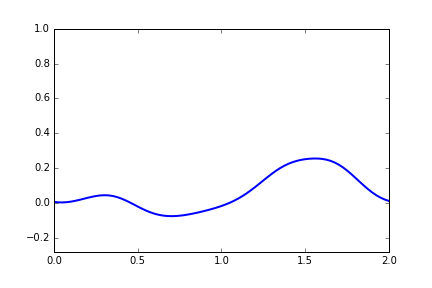
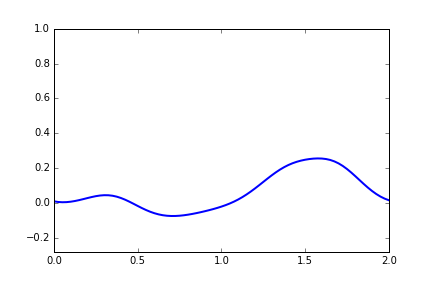
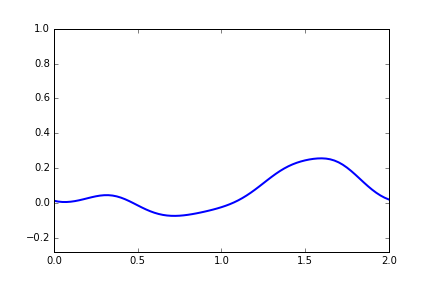
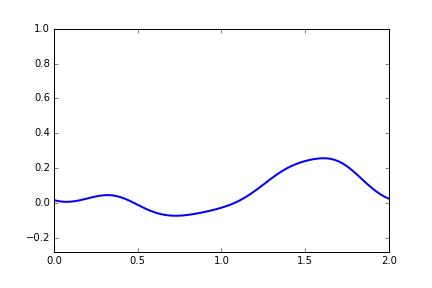
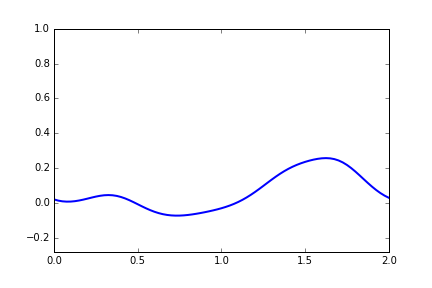
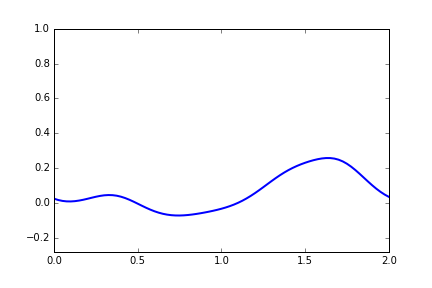
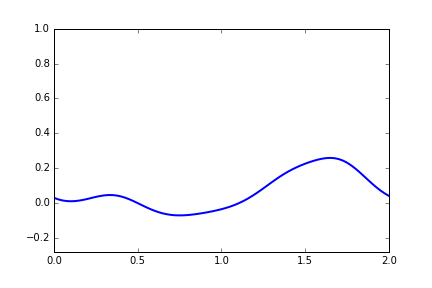
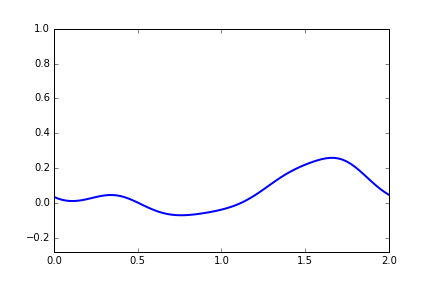
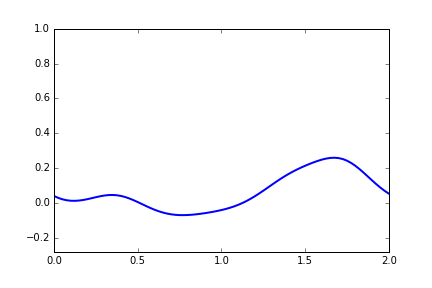
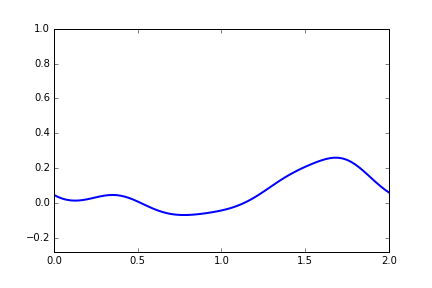
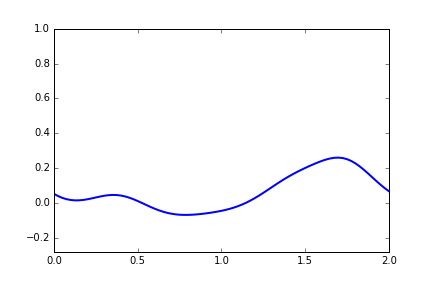
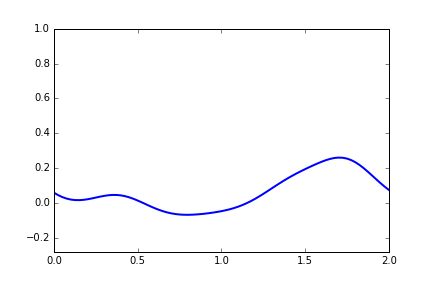
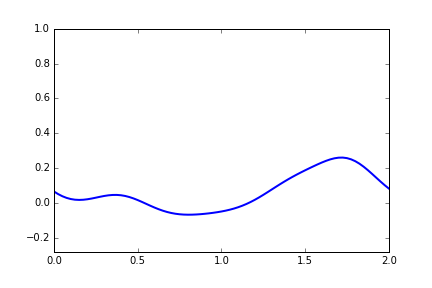
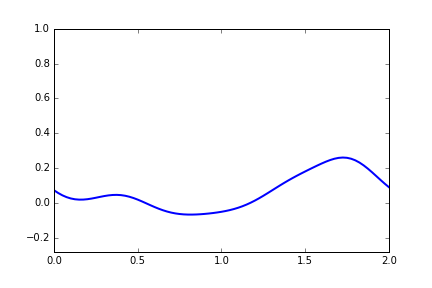
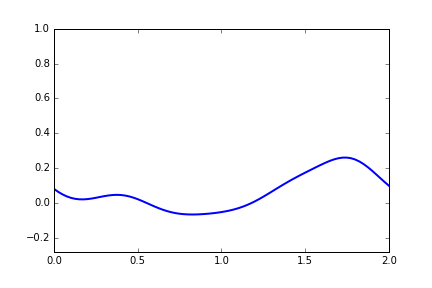
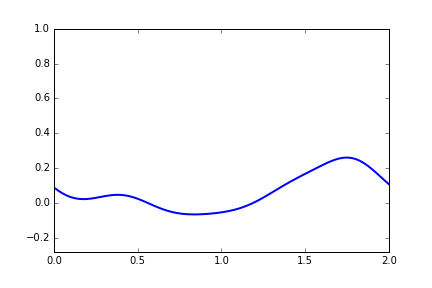
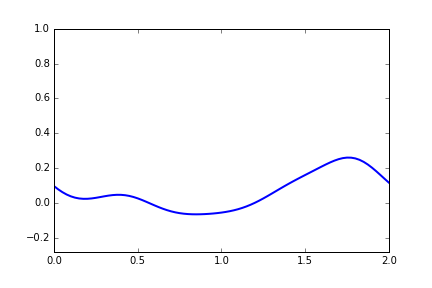
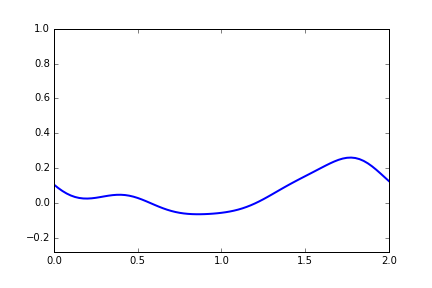
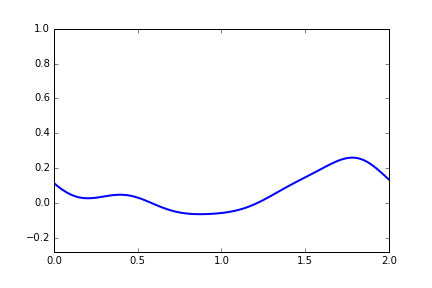
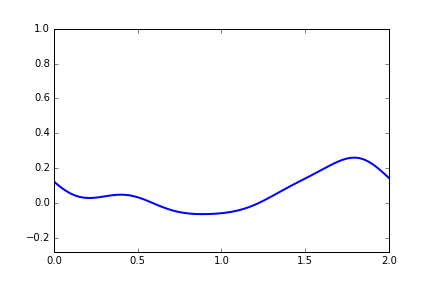
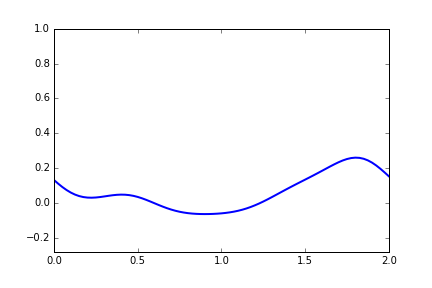
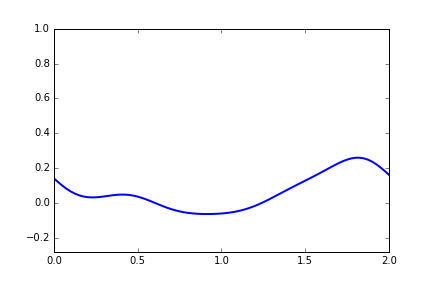
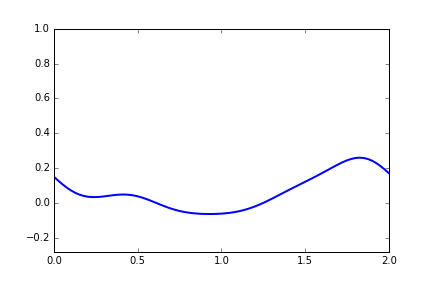
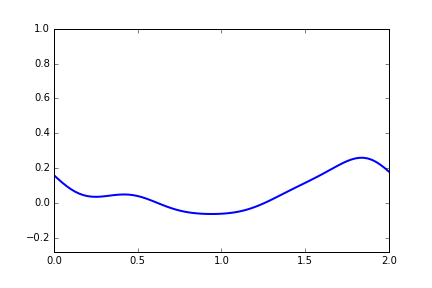
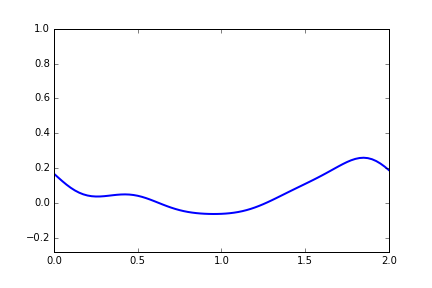
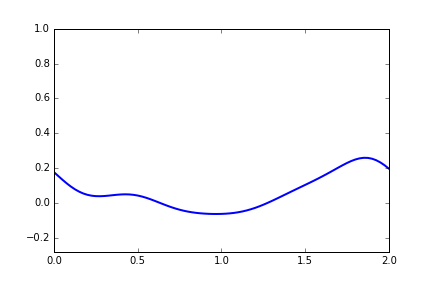
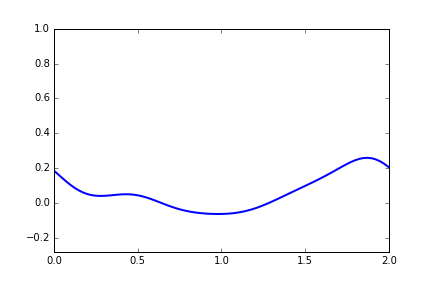
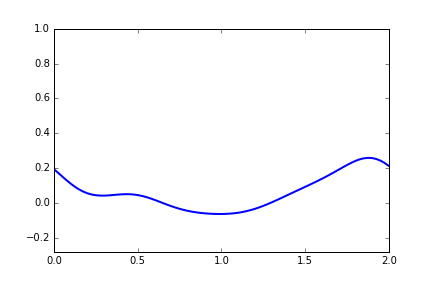
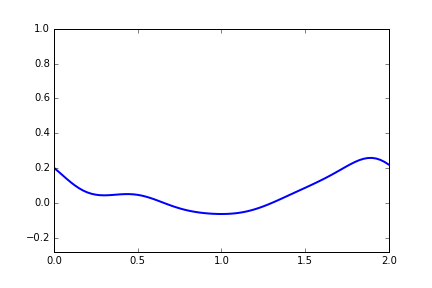
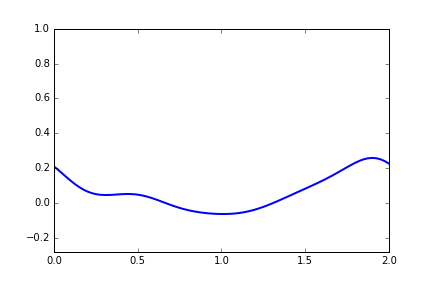
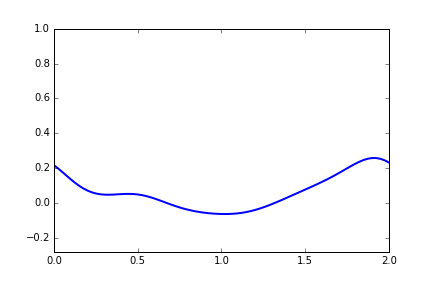
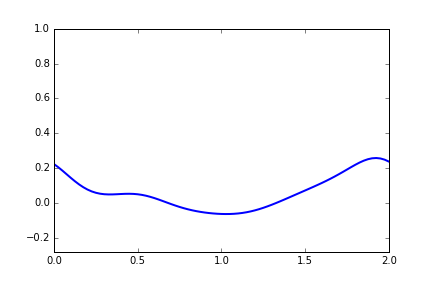
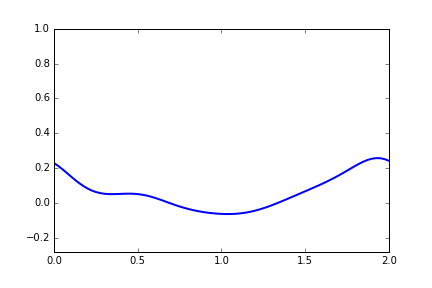
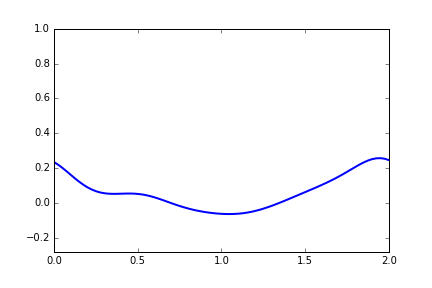
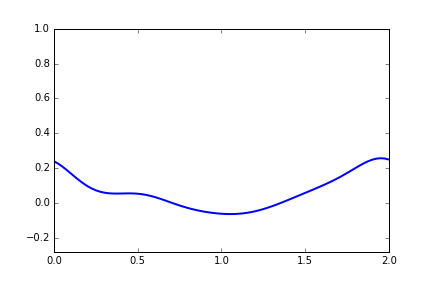
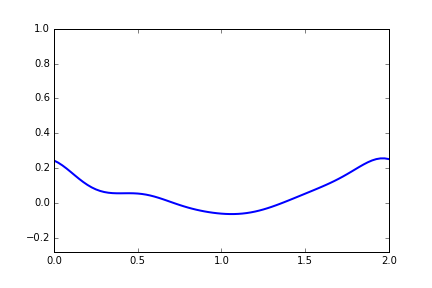
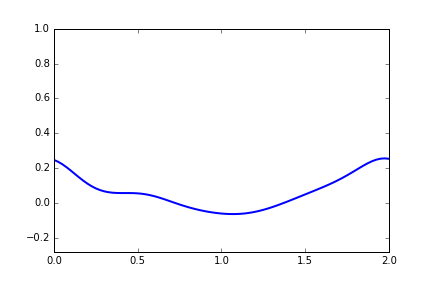
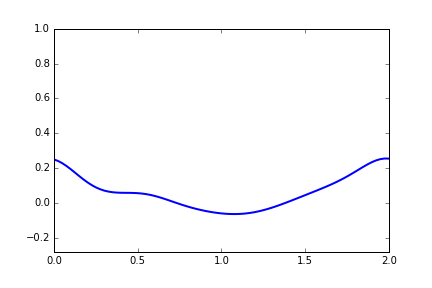
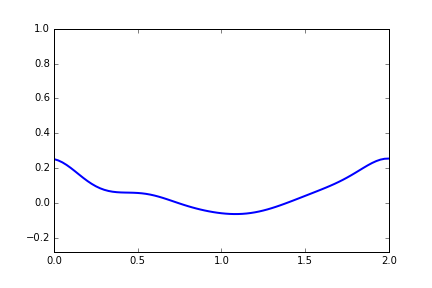
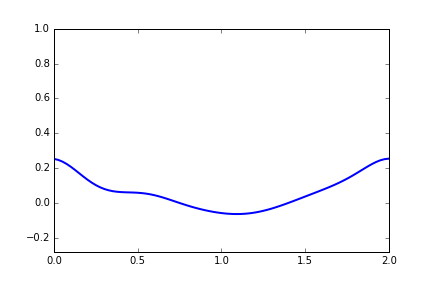
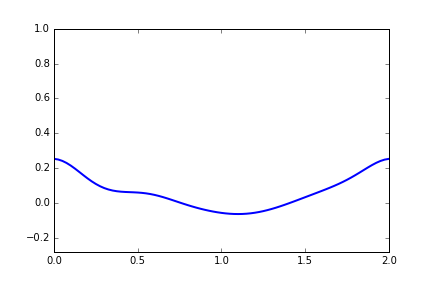
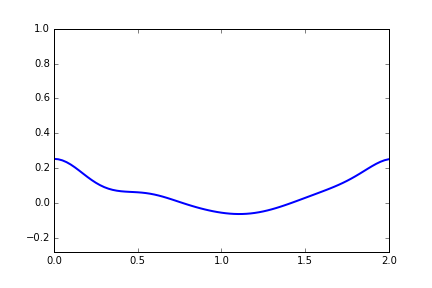
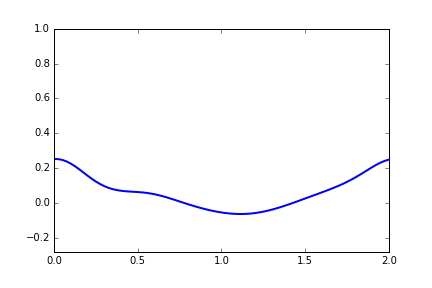
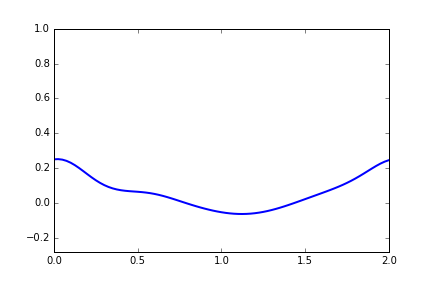
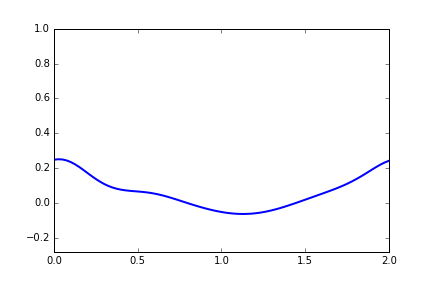
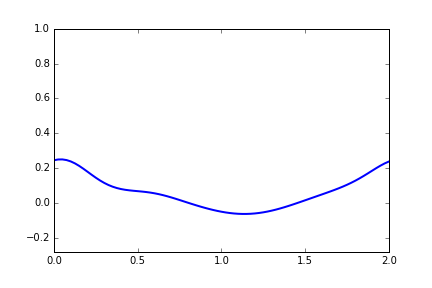
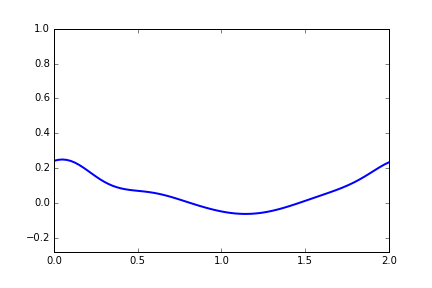
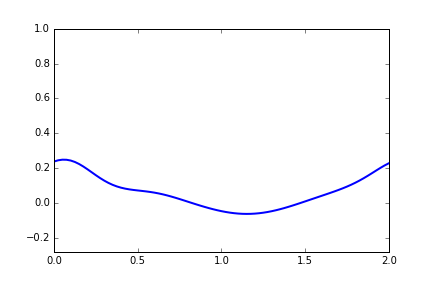
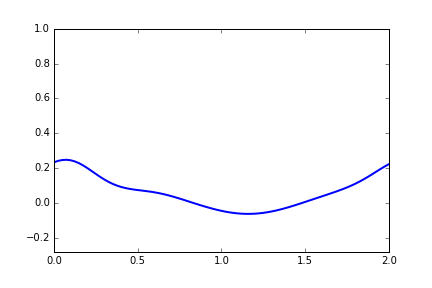
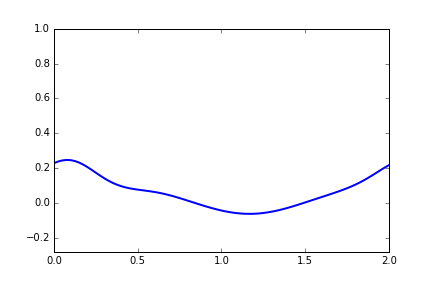
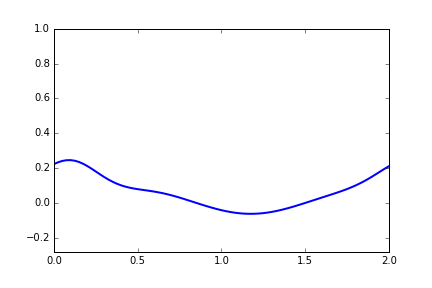
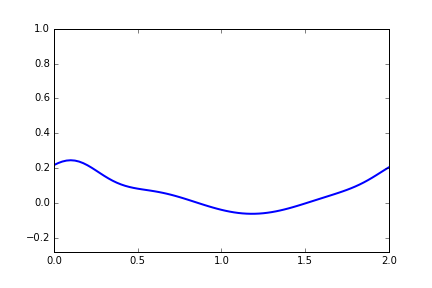
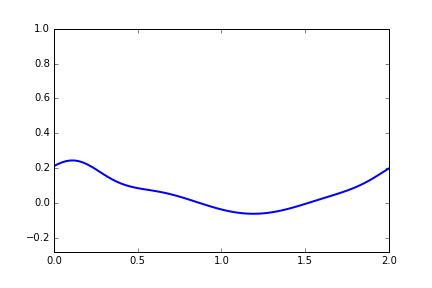
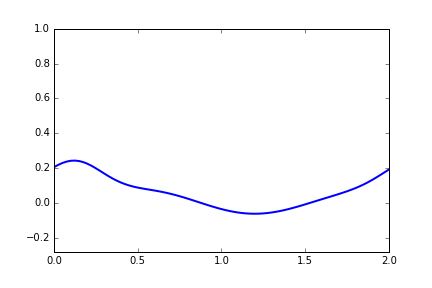
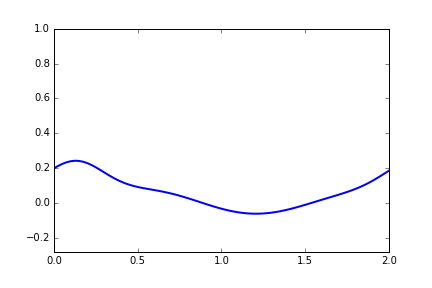
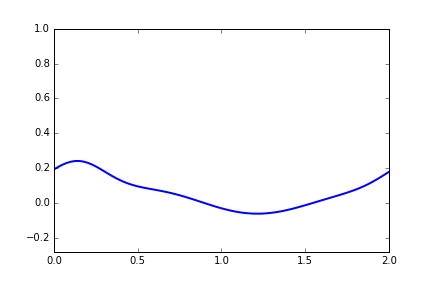
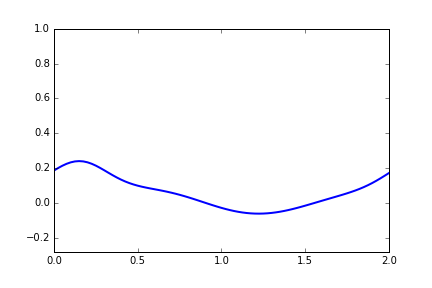
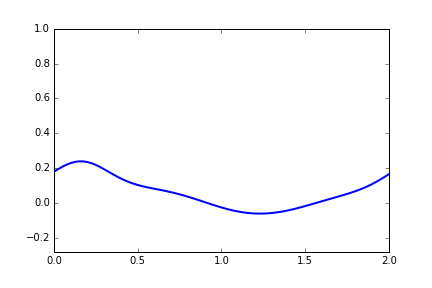
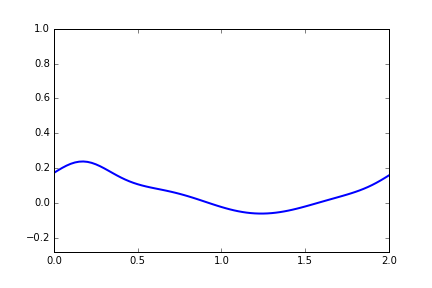
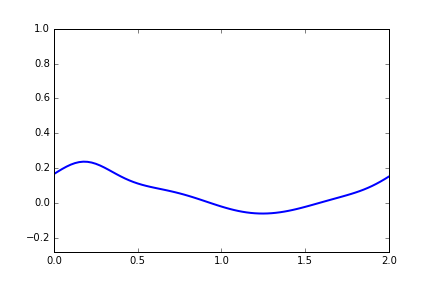
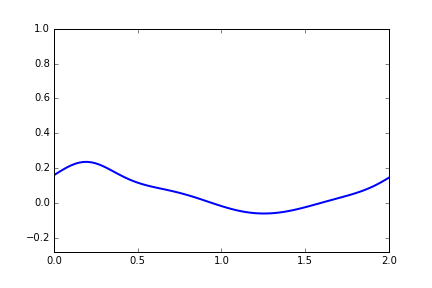
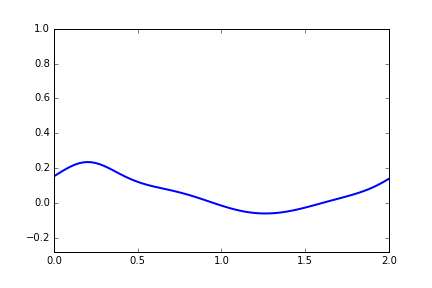
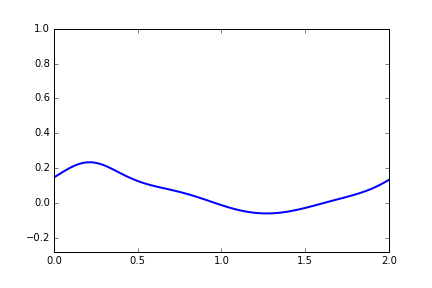
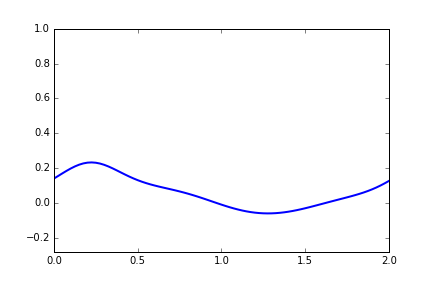
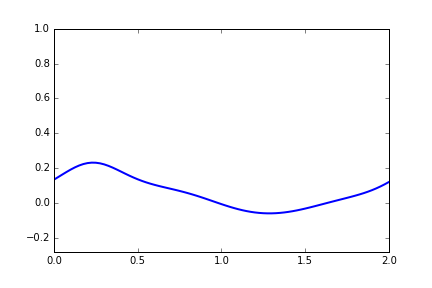
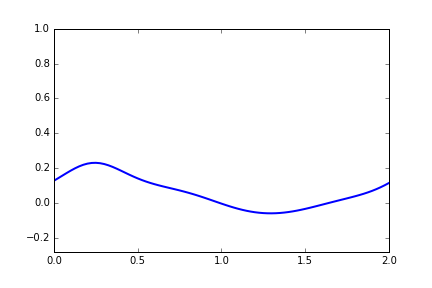
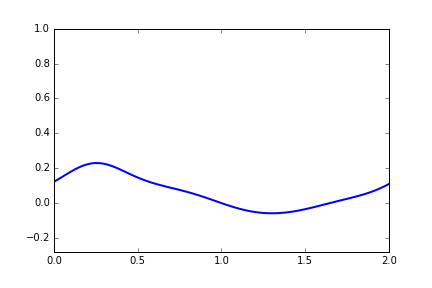
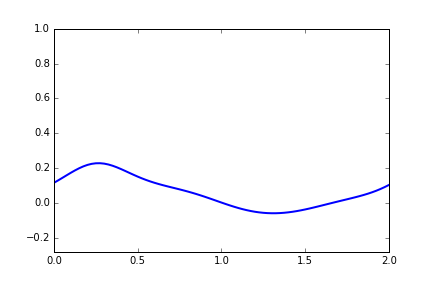
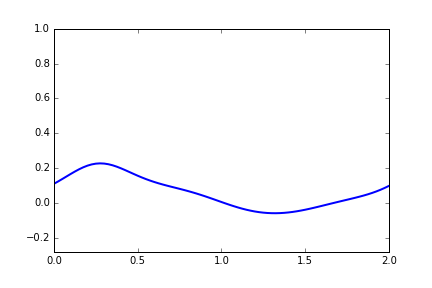
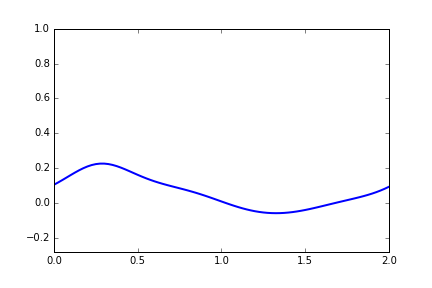
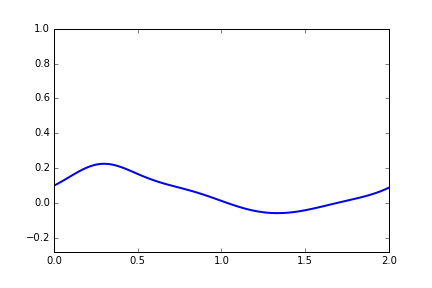
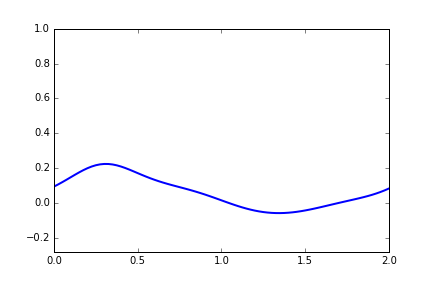
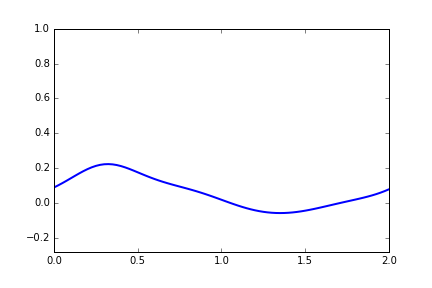
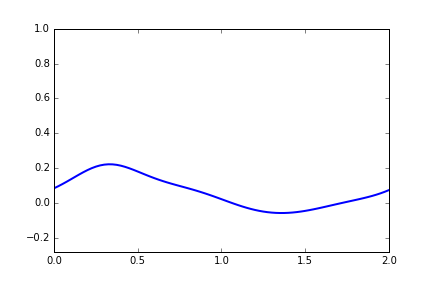
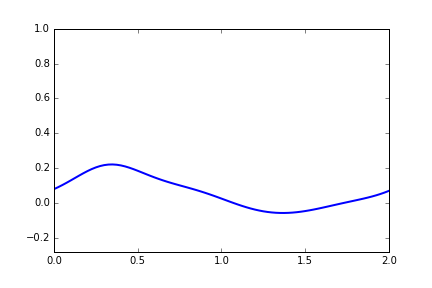
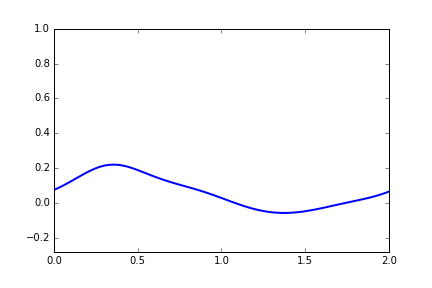
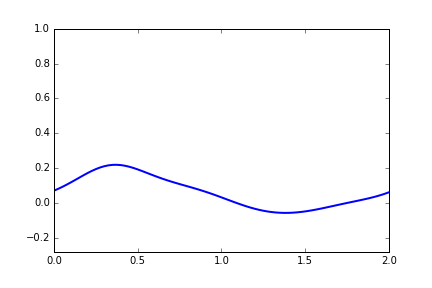
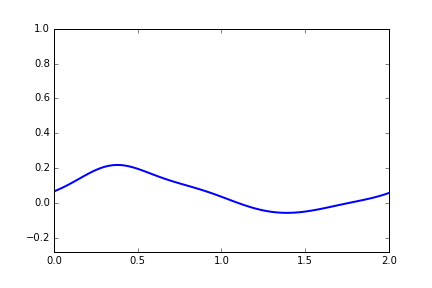
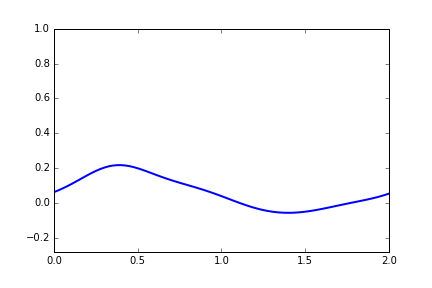
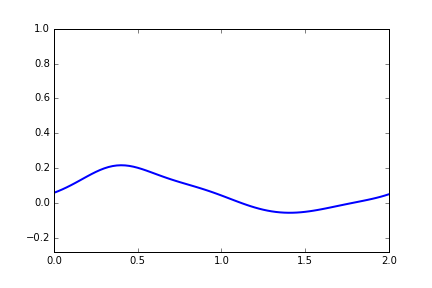
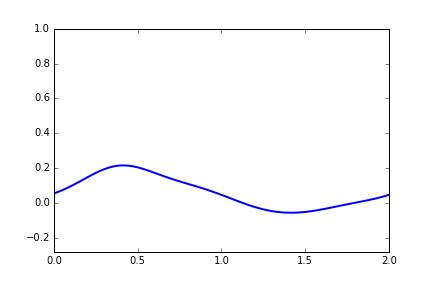
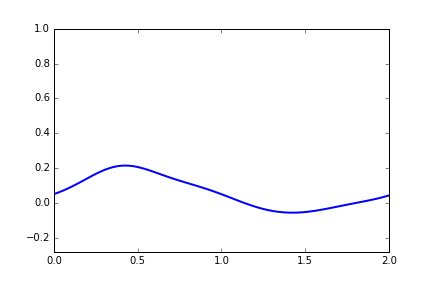
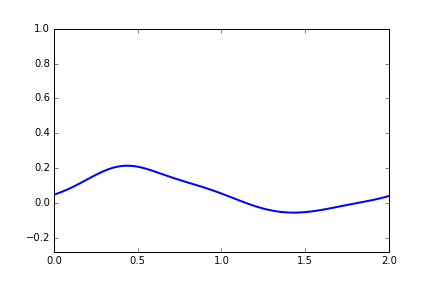
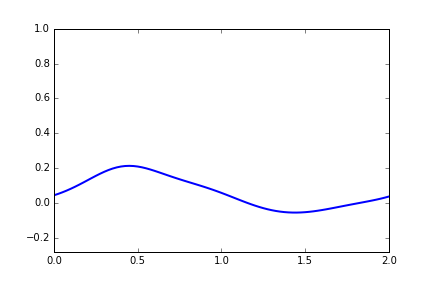
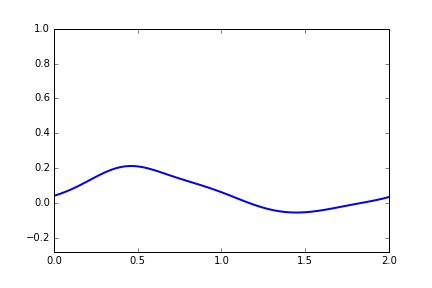
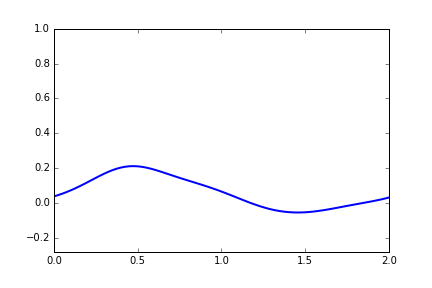
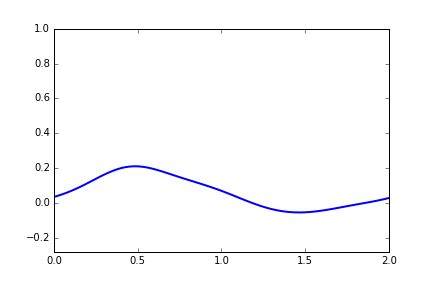
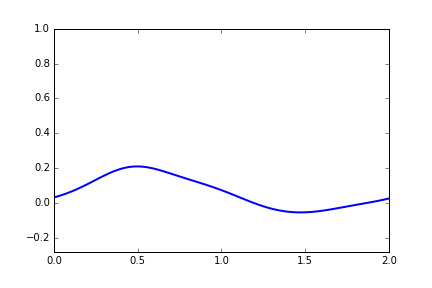
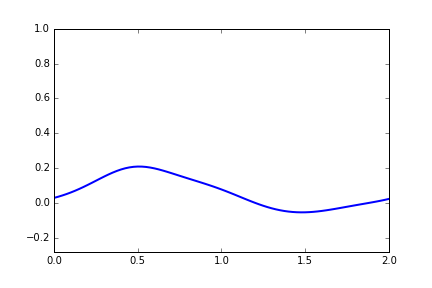
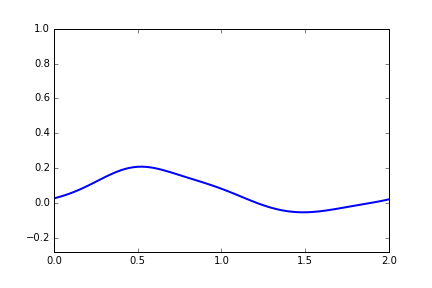
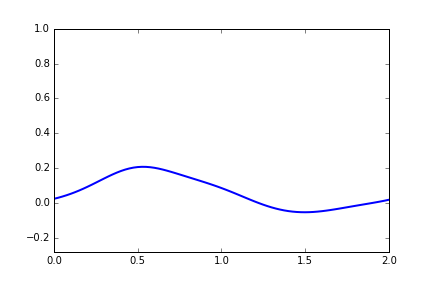
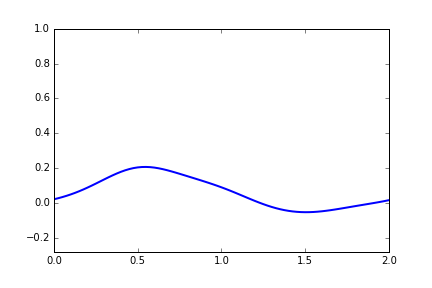
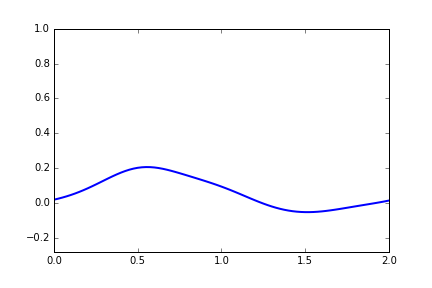
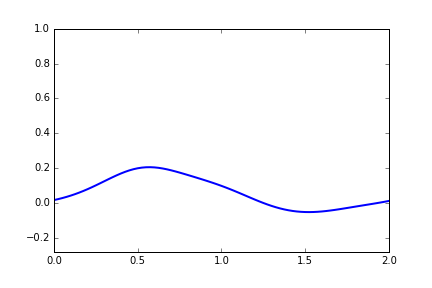
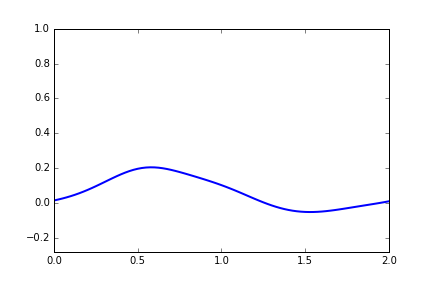
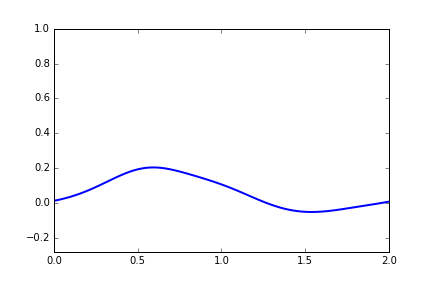
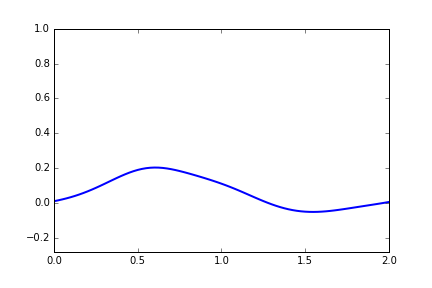
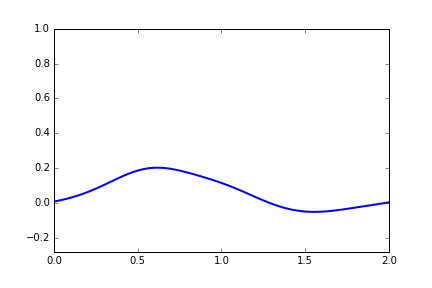
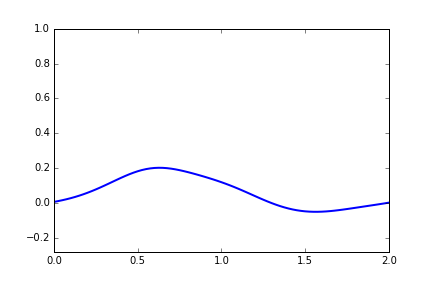
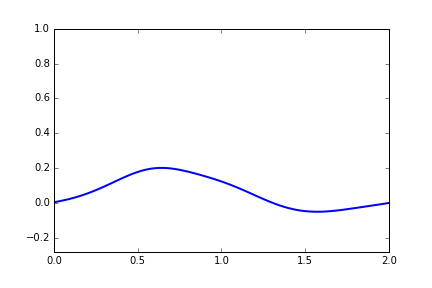
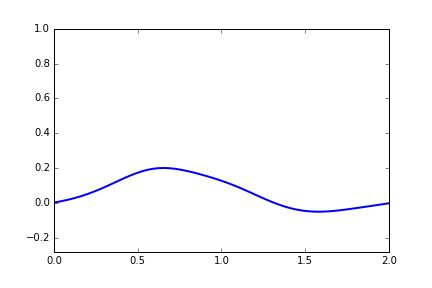

In [12]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(xmin, L), ylim=(np.amin(uall), np.amax(uall)))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    #ax.annotate(r'$t = %f $' %tall[i],(1,1))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=uall.shape[-1], interval=30)

## Case Study 2 : Gaussian Profile

In [13]:
u = np.exp(-(x-xmax/2.)**2)   
uall, tall = kdv.runRk4FVFourier(x,u,t0=0,tmax=2,a=1,b=1)

### Animation of the simulation


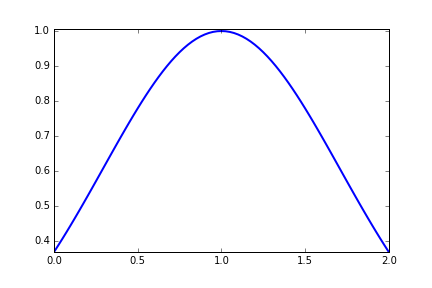
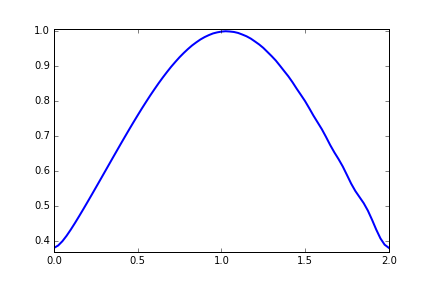
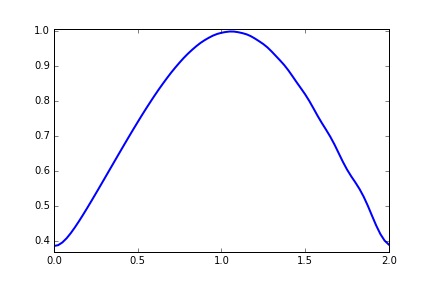
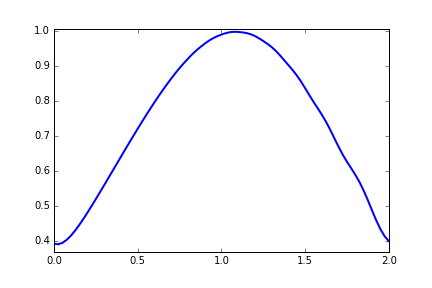
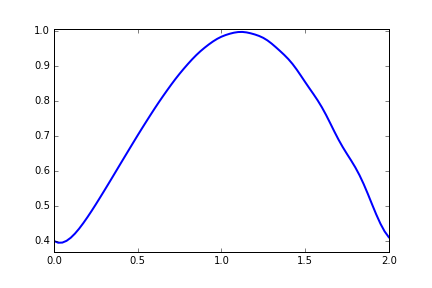
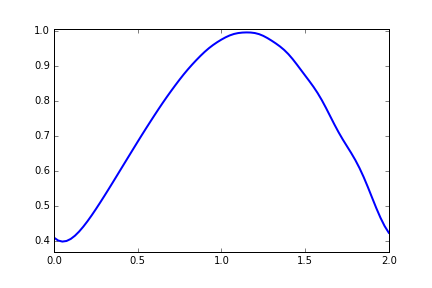
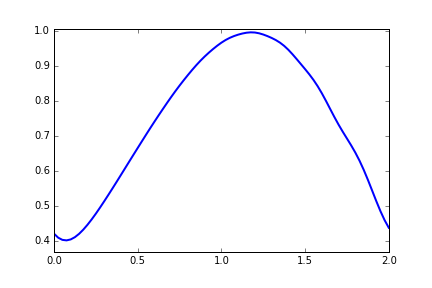
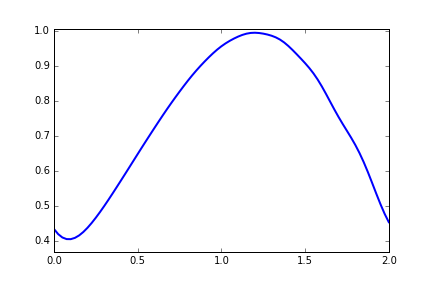
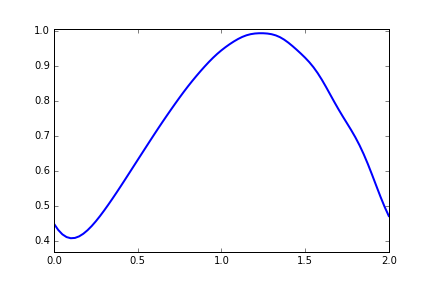
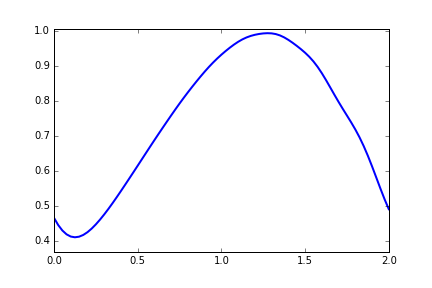
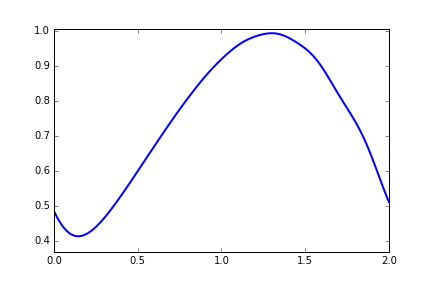
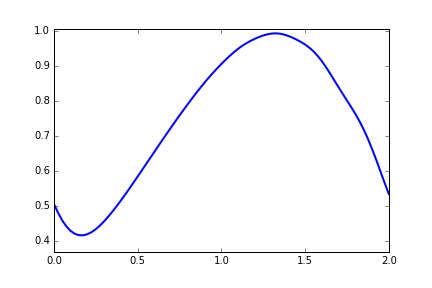
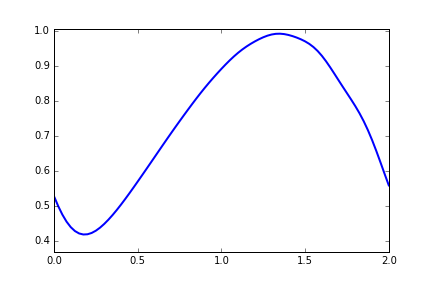
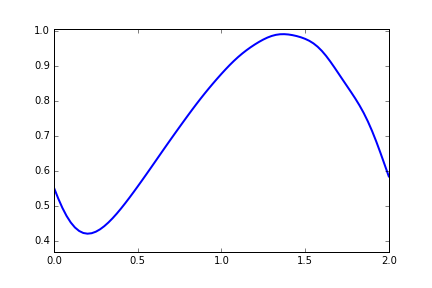
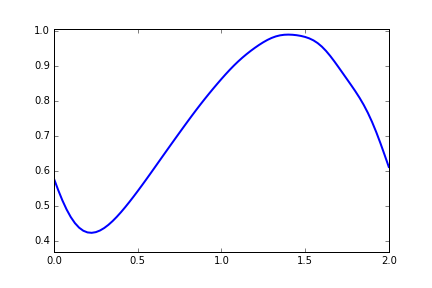
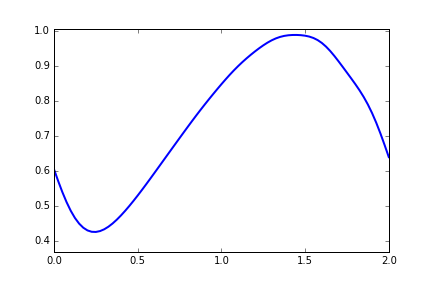
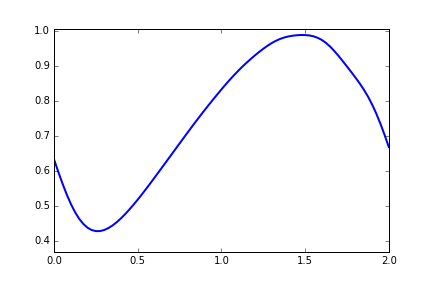
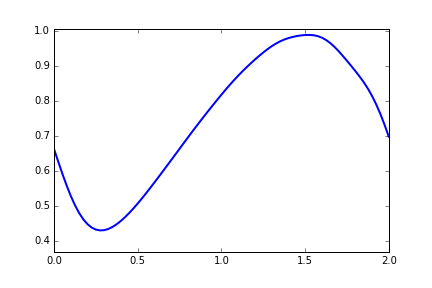
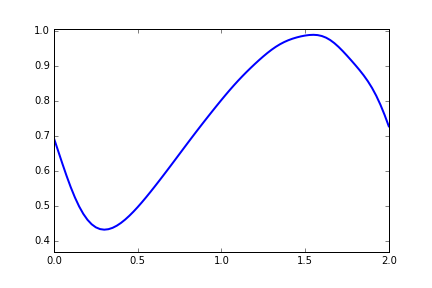
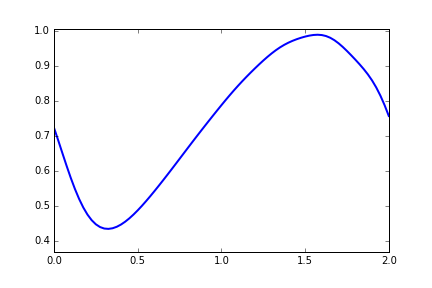
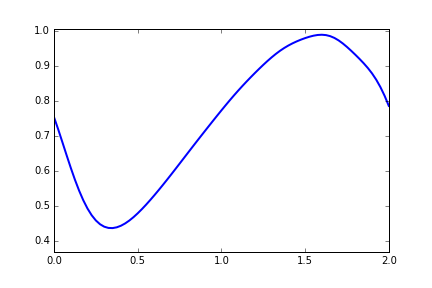
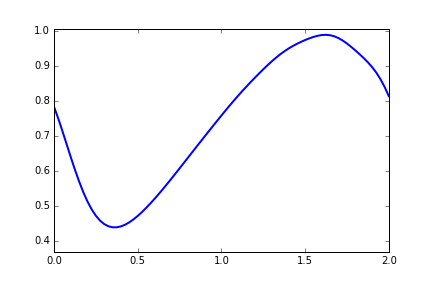
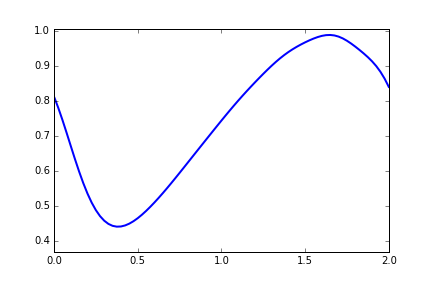
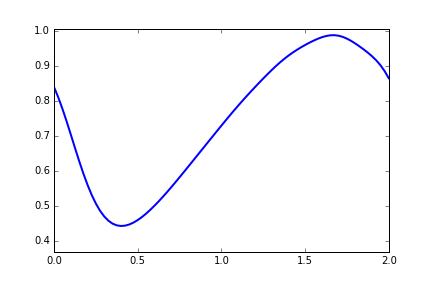
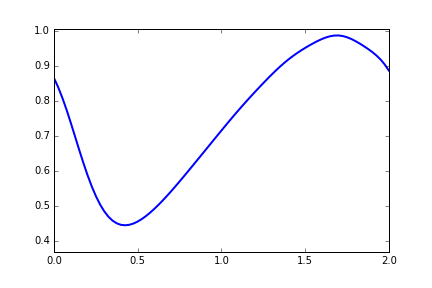
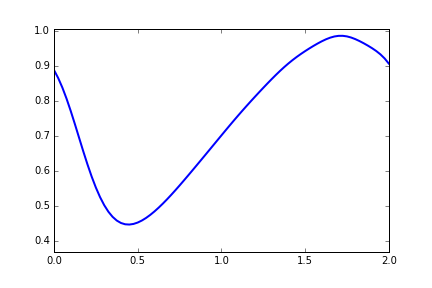
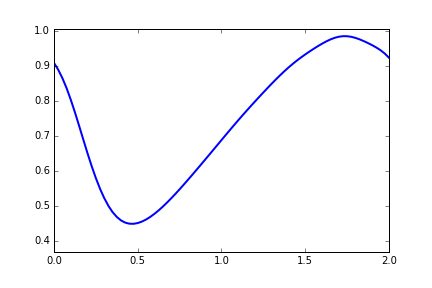
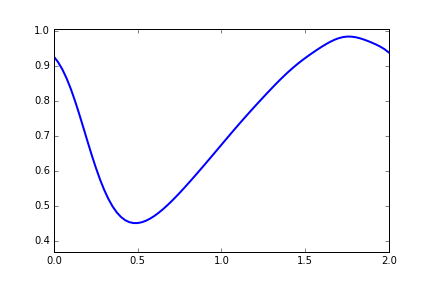
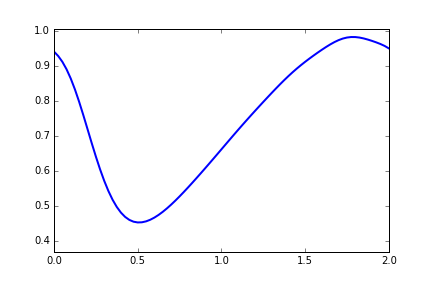
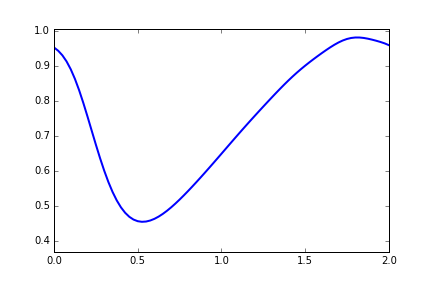
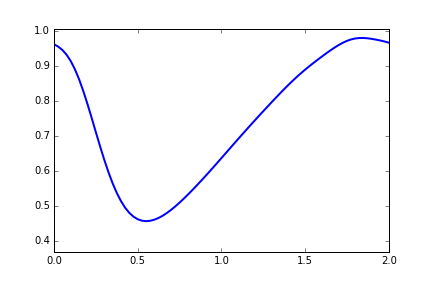
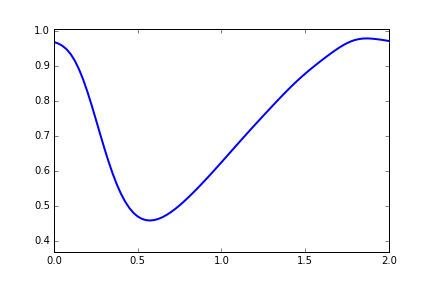
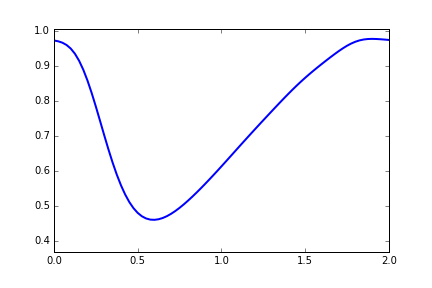
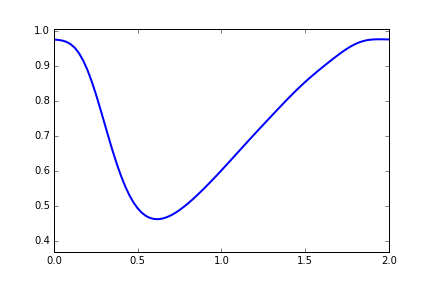
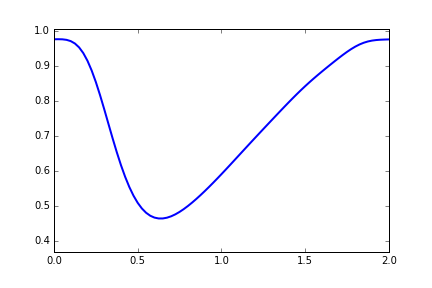
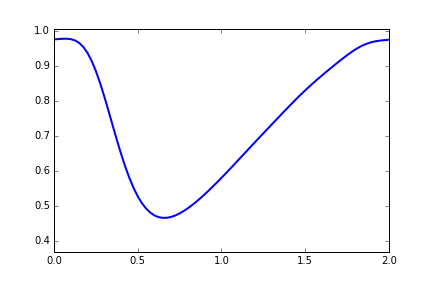
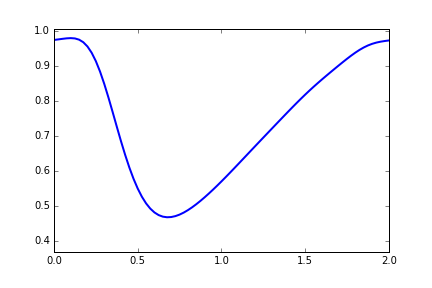
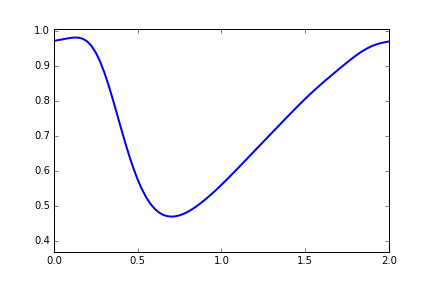
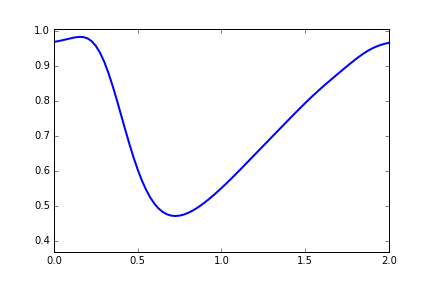
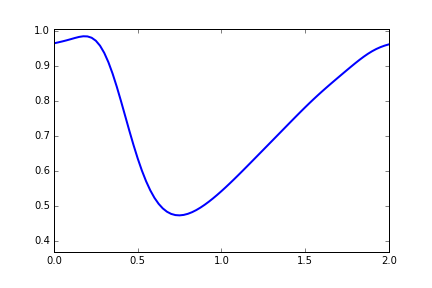
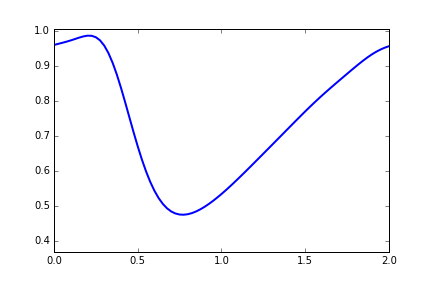
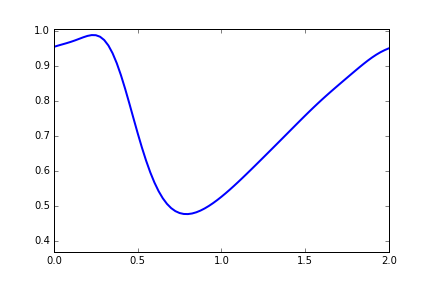
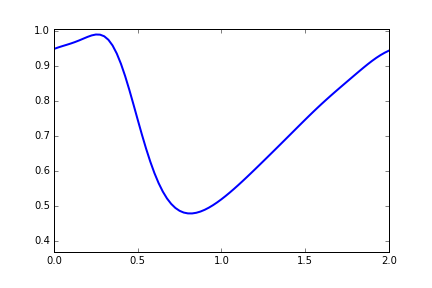
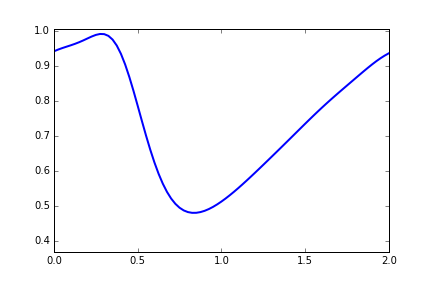
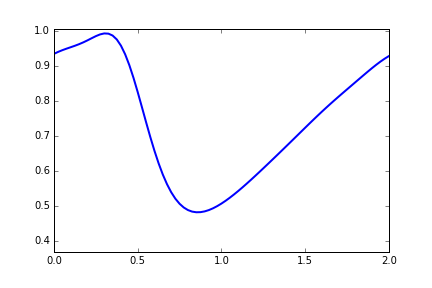
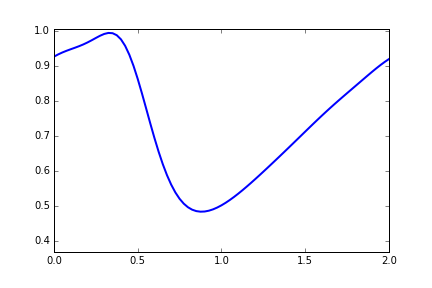
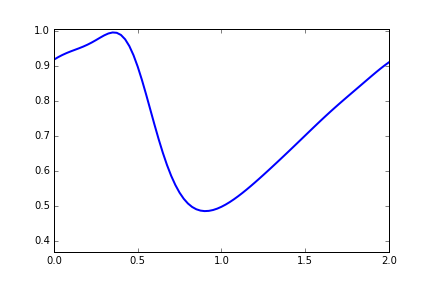
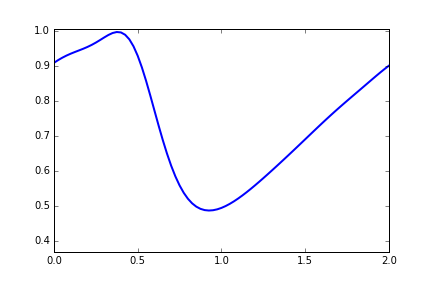
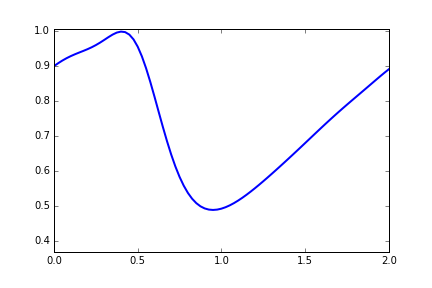
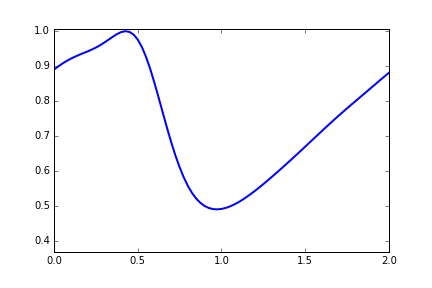
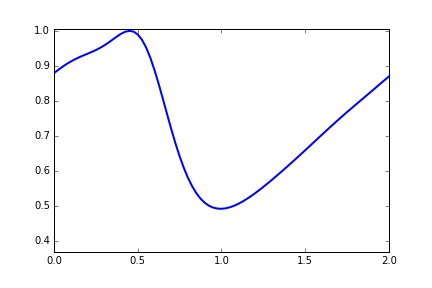
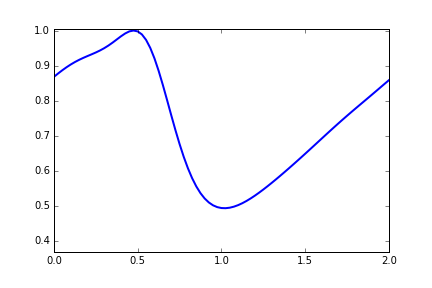
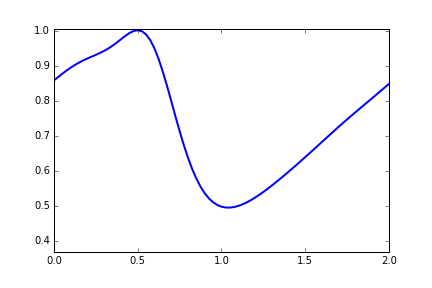
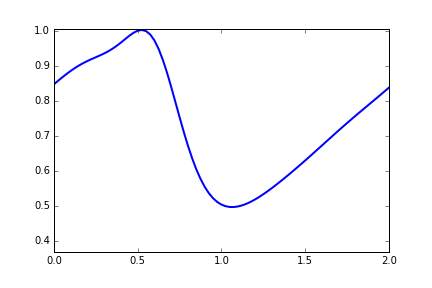
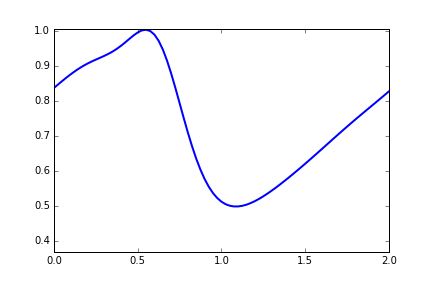
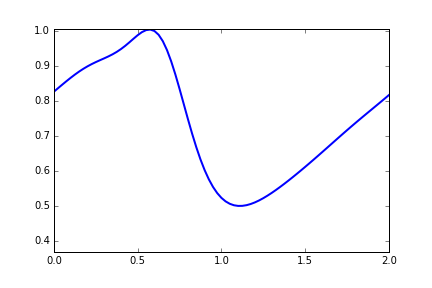
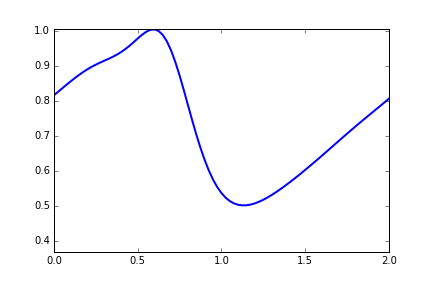
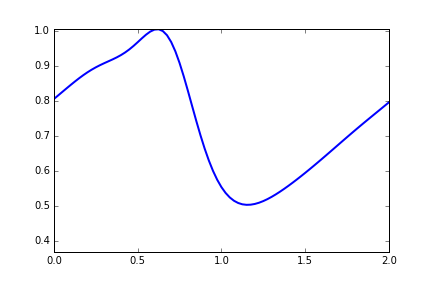
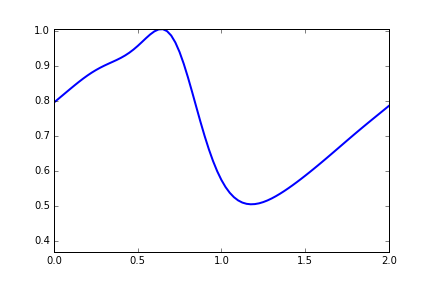
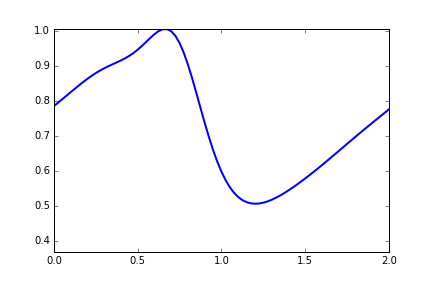
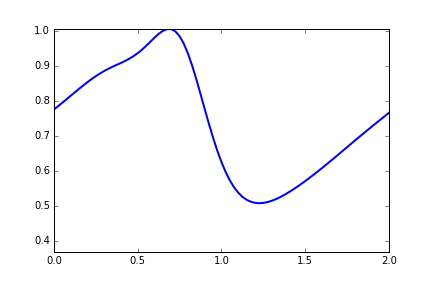
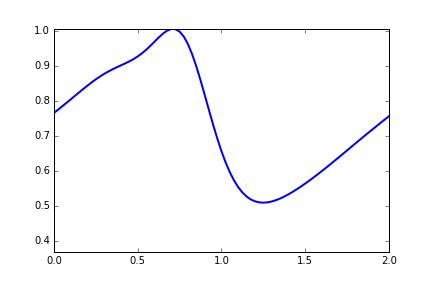
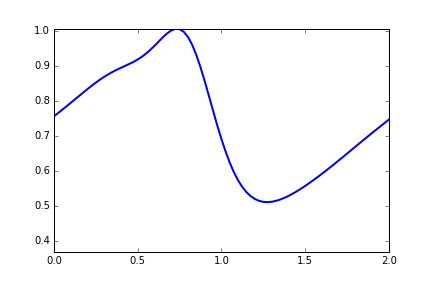
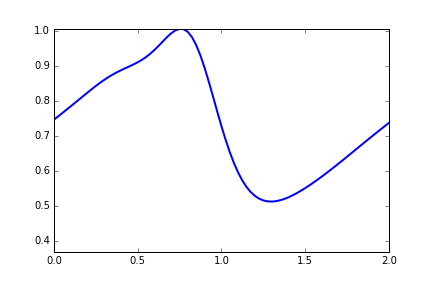
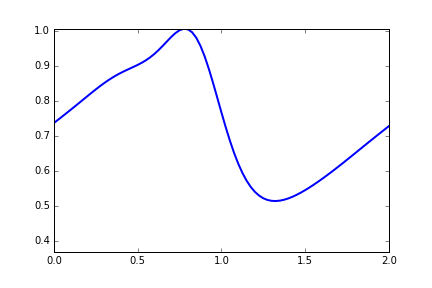
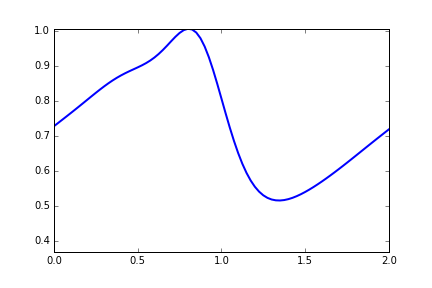
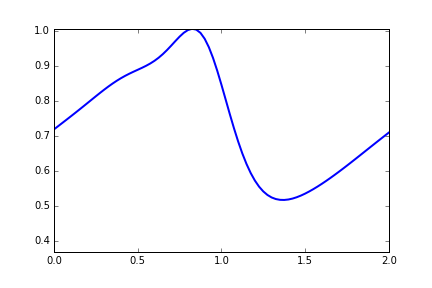
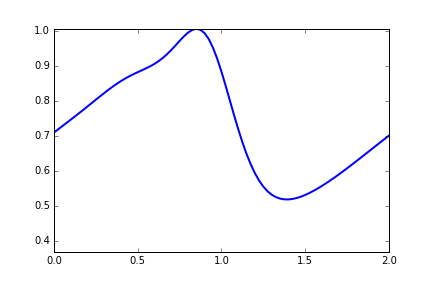
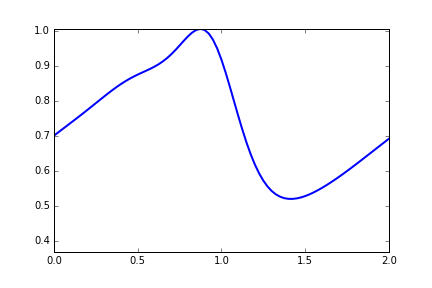
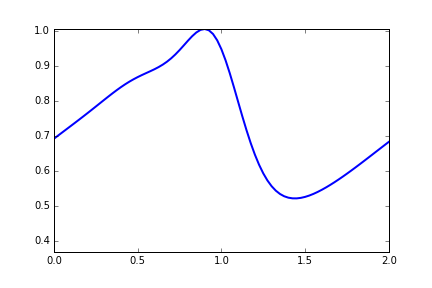
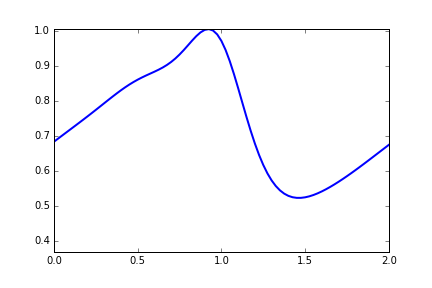
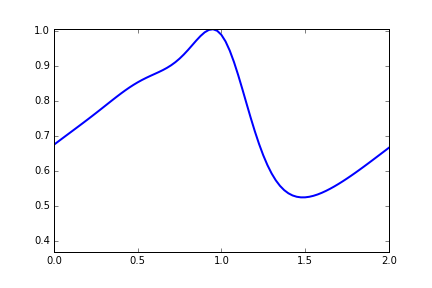
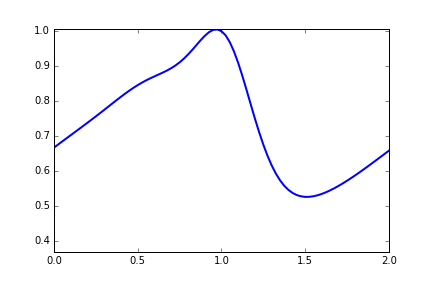
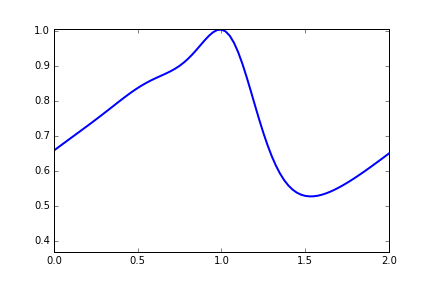
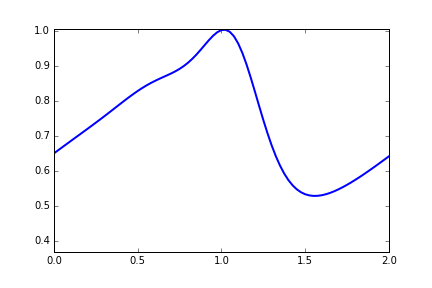
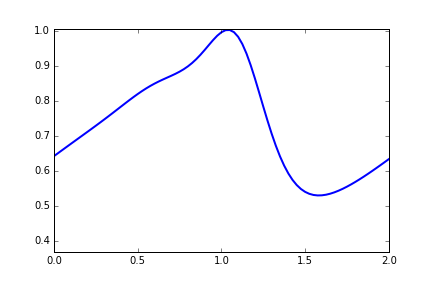
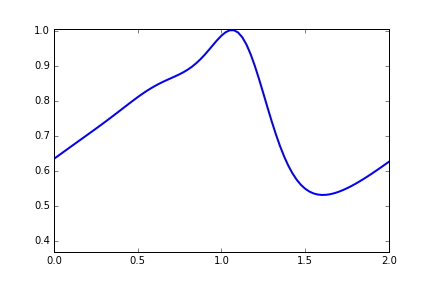
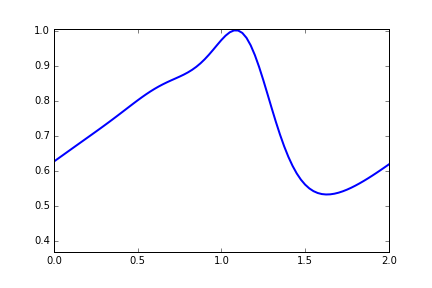
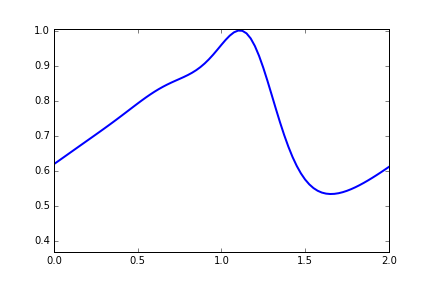
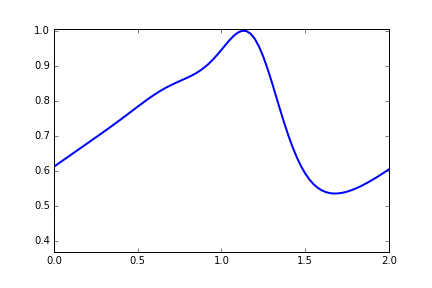
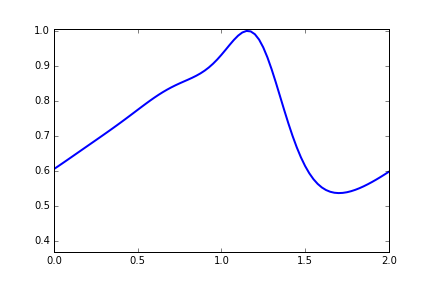
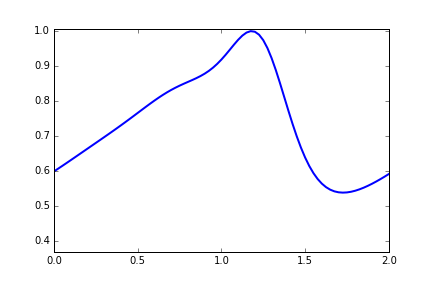
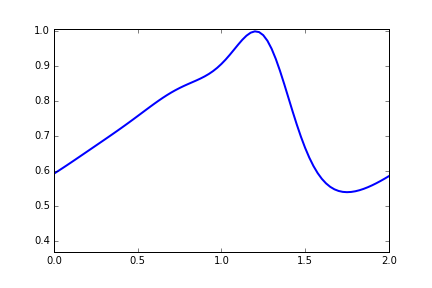
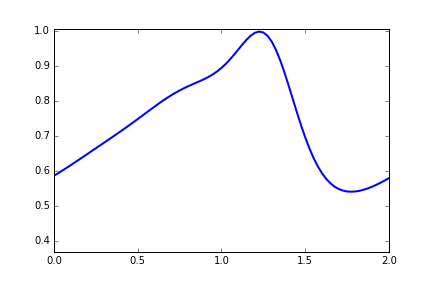
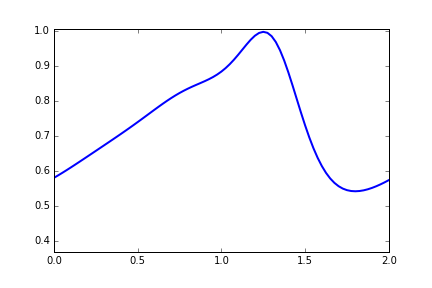
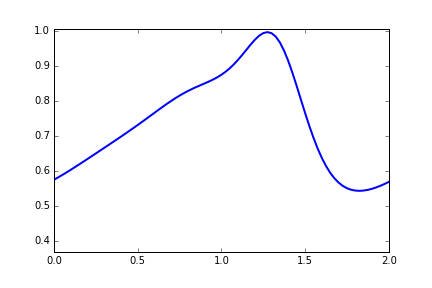
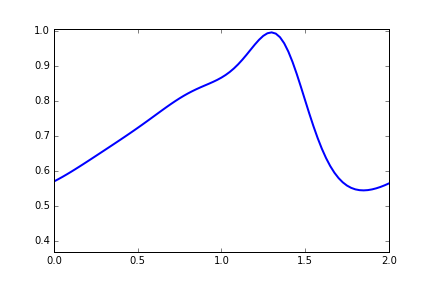
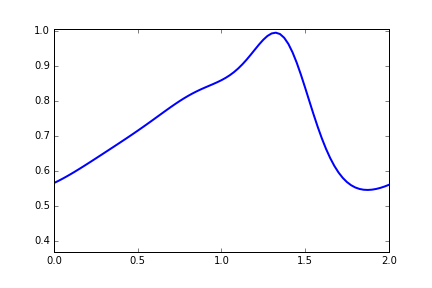
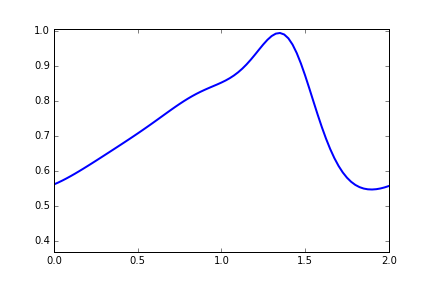
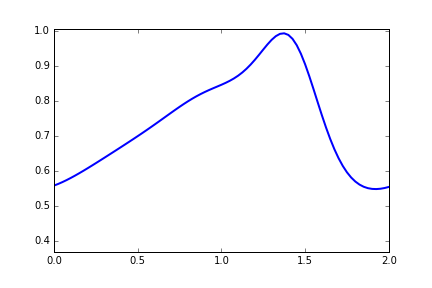
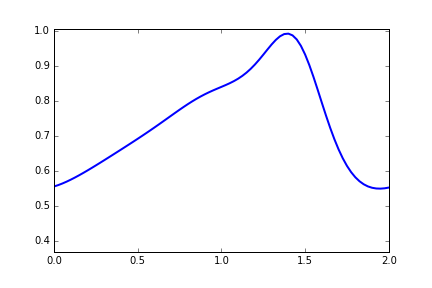
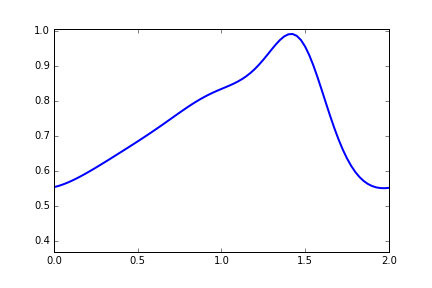
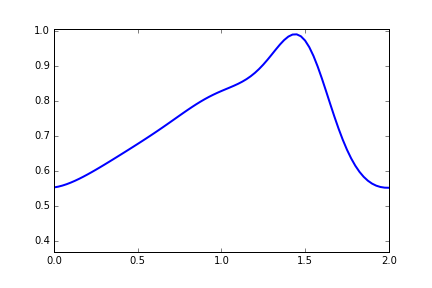
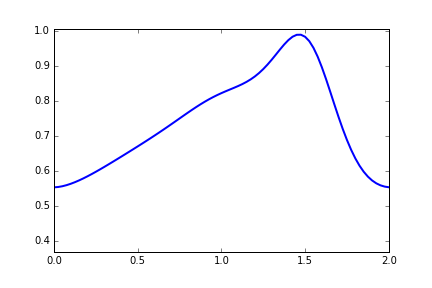
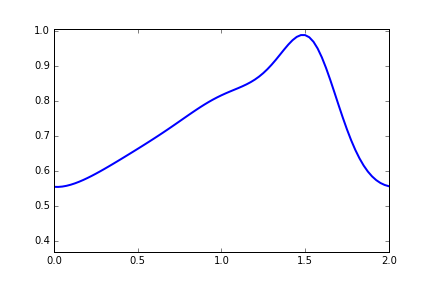
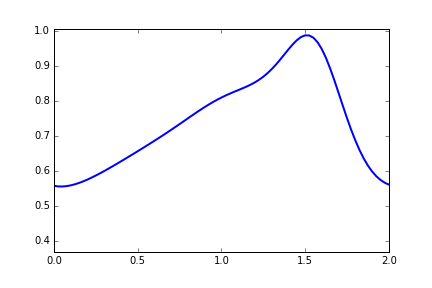
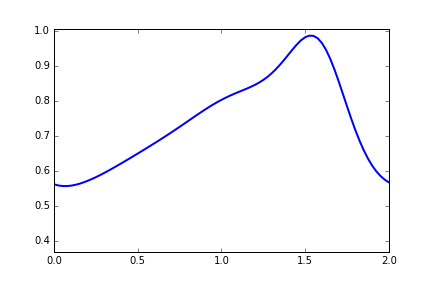
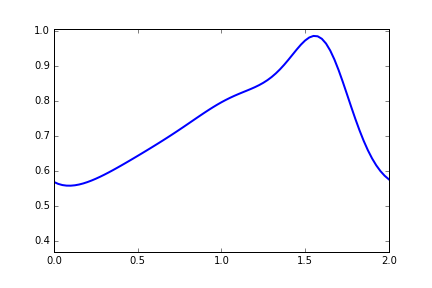
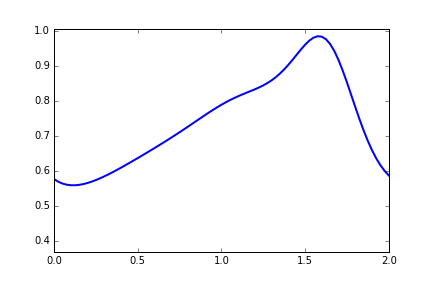
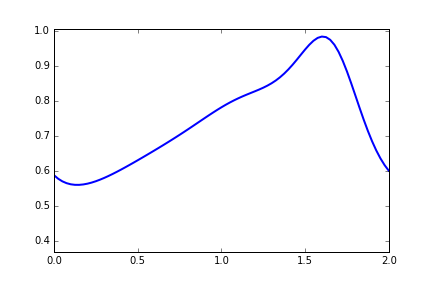
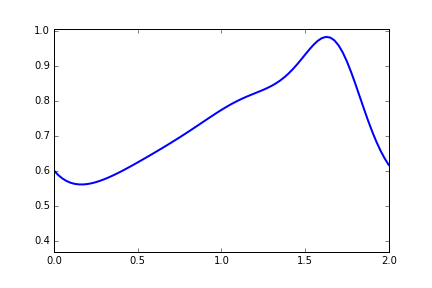
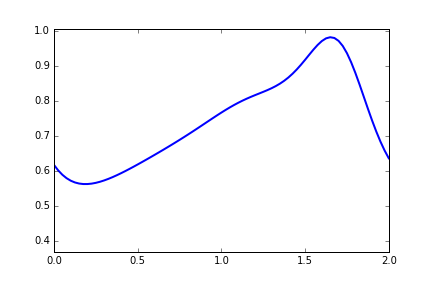
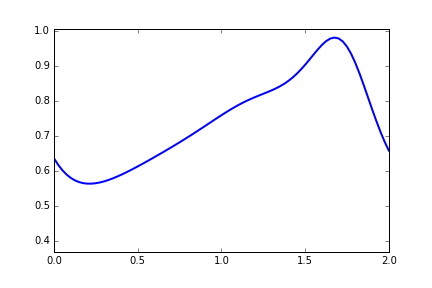
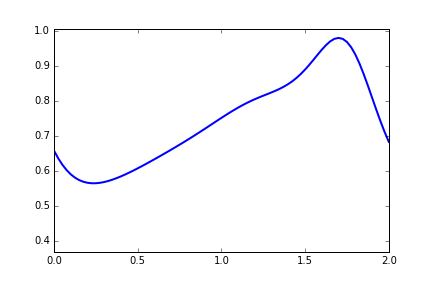
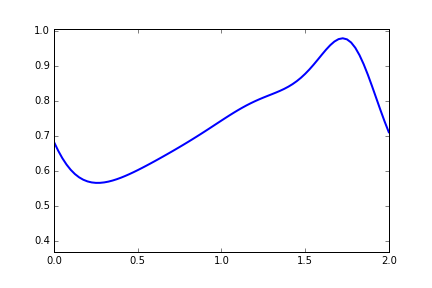
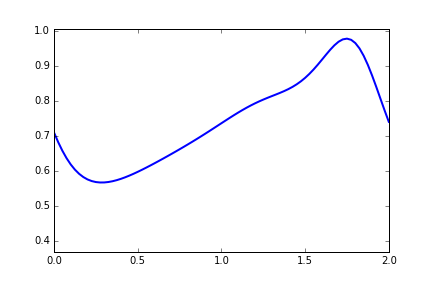
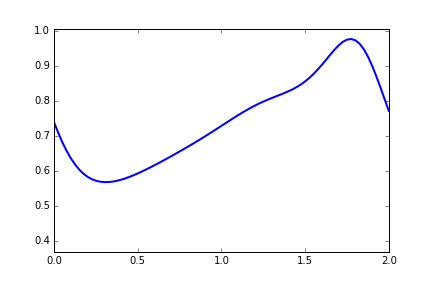
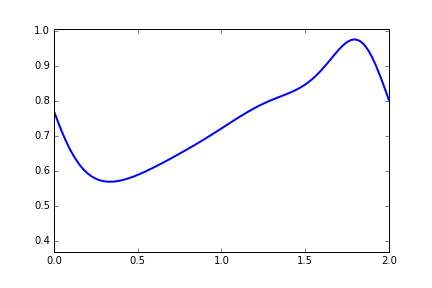
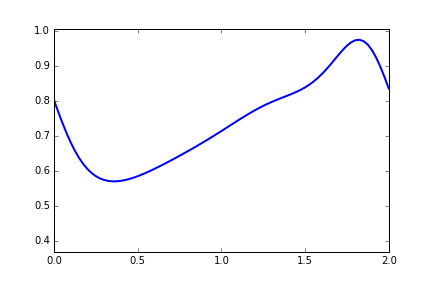
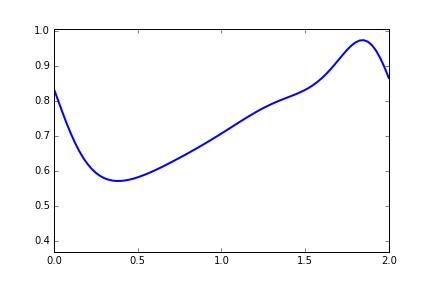
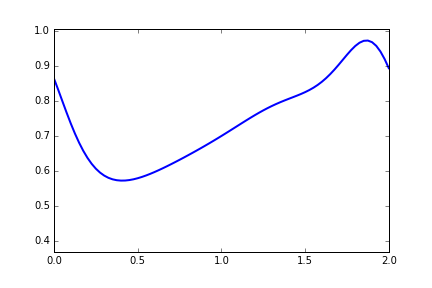
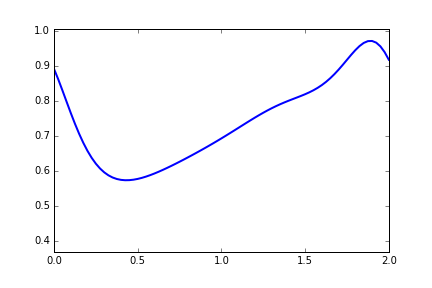
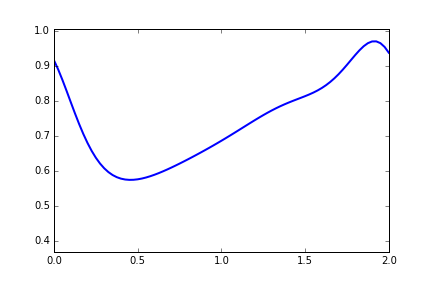
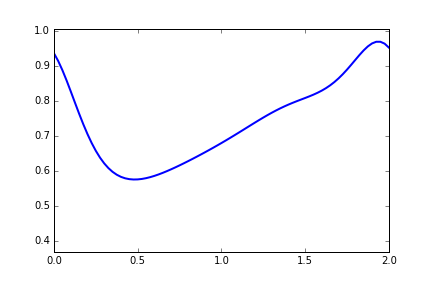
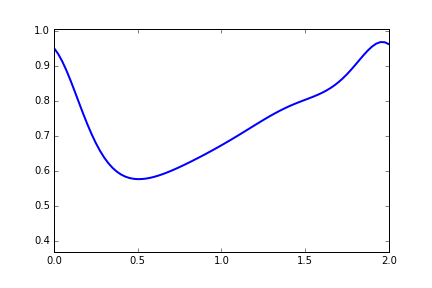
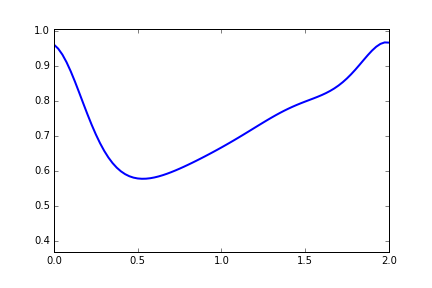
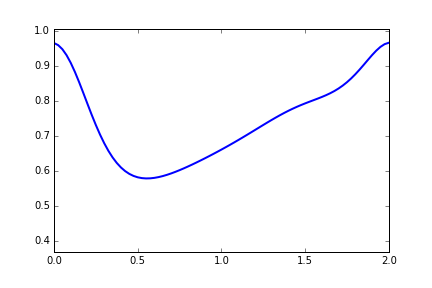
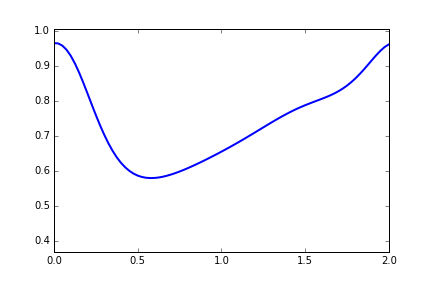
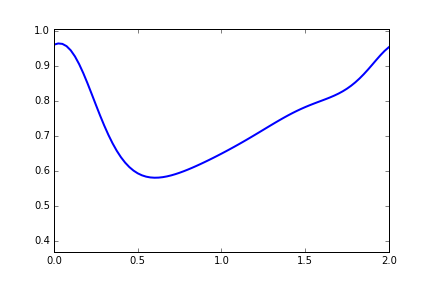
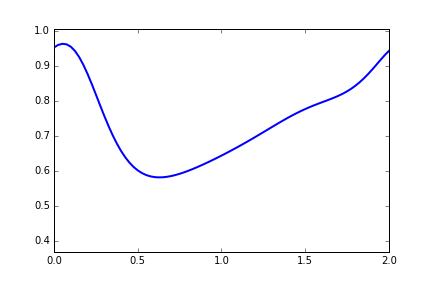
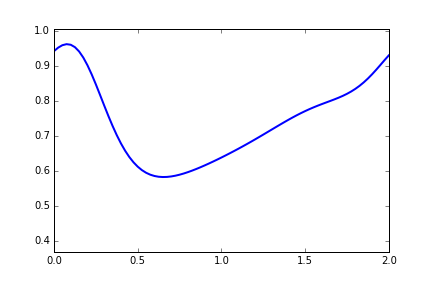
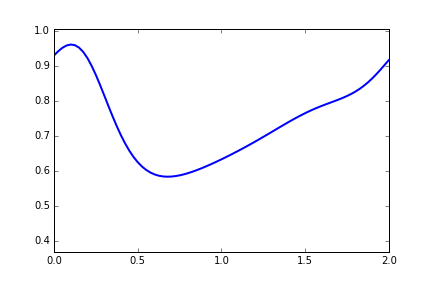
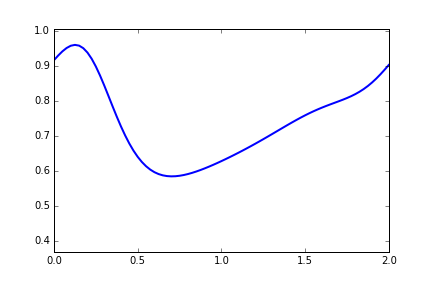
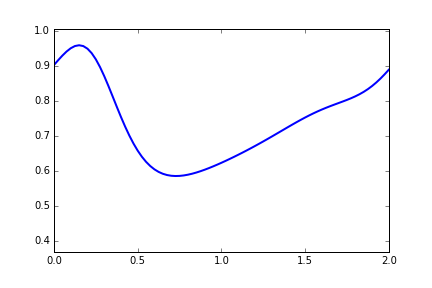
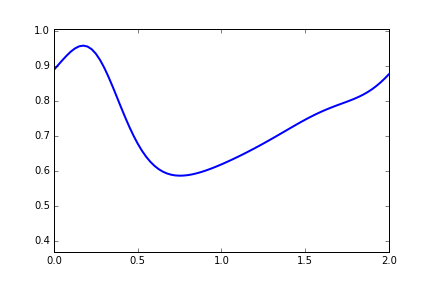
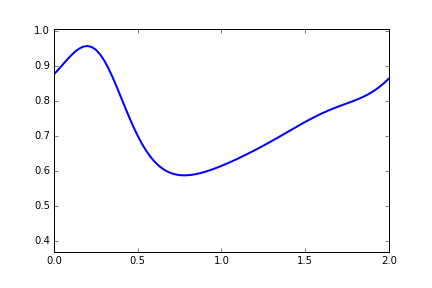
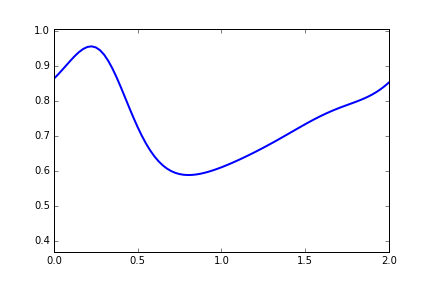
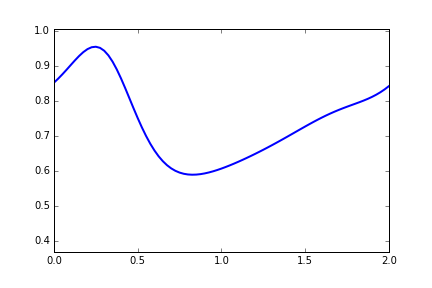
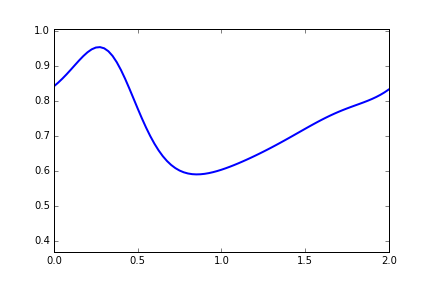
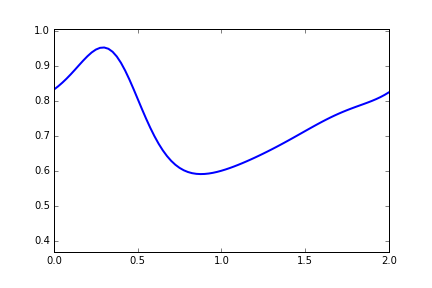
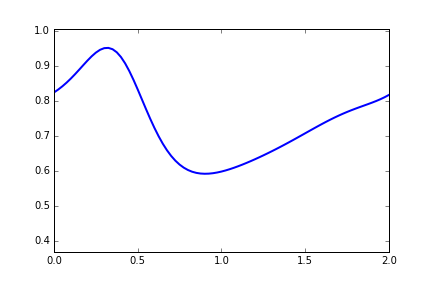
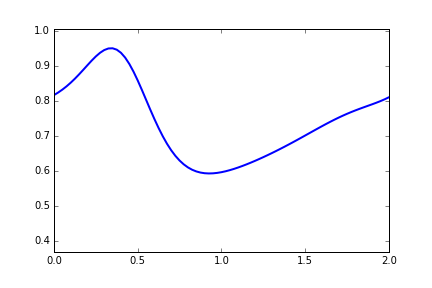
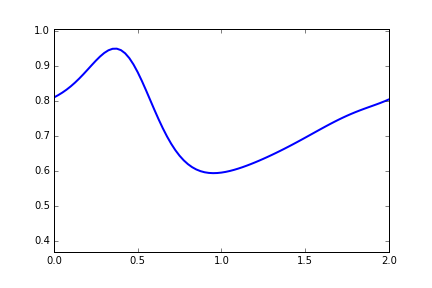
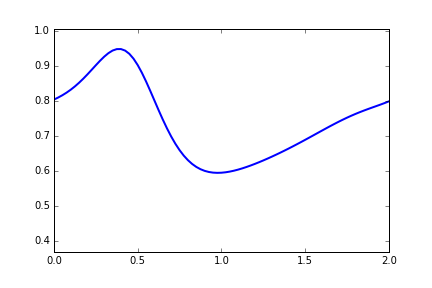
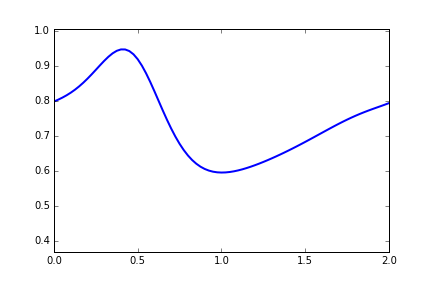
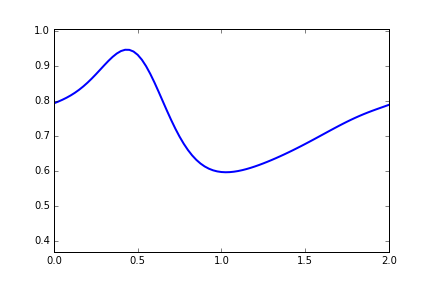
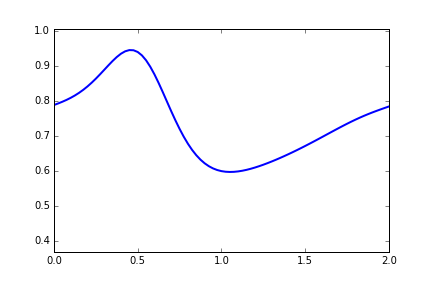
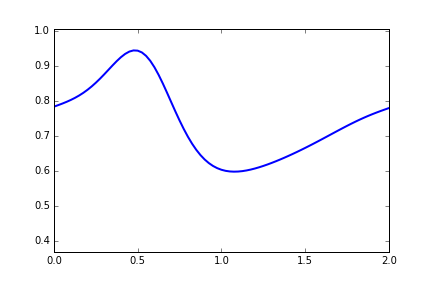
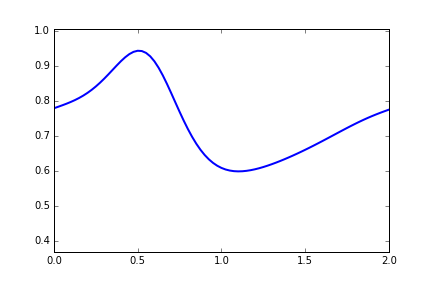
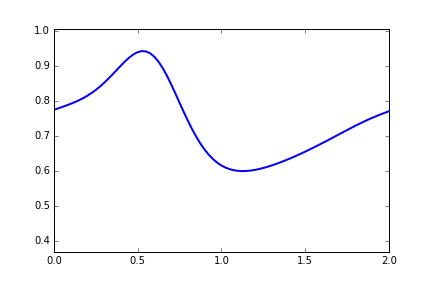
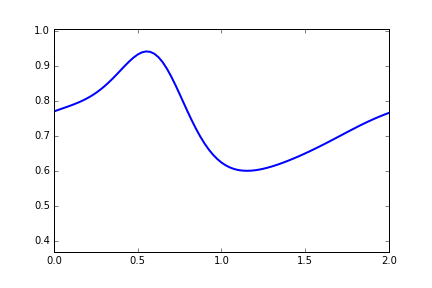
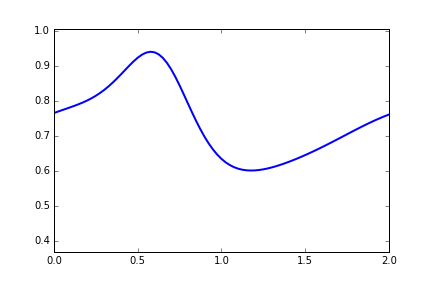
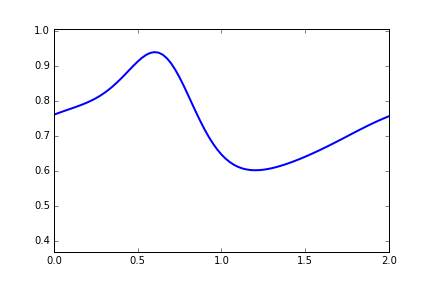
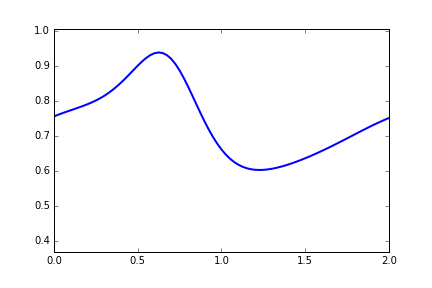
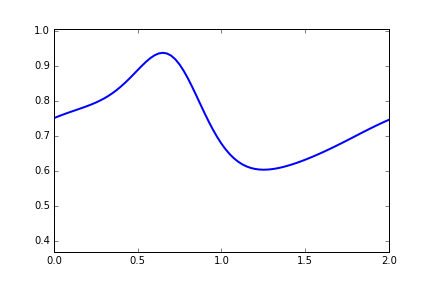
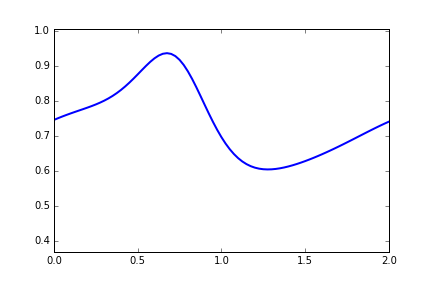
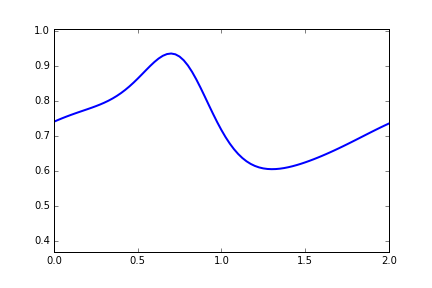
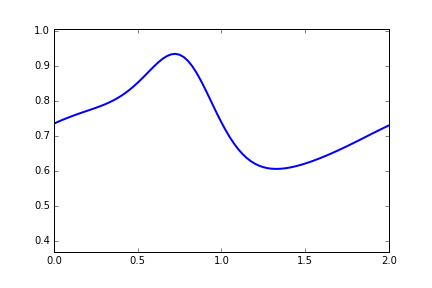
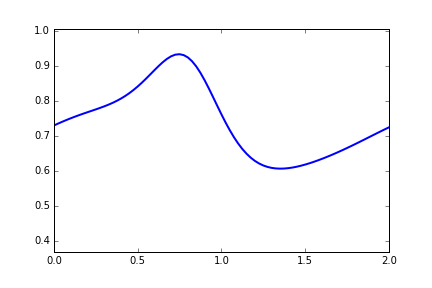
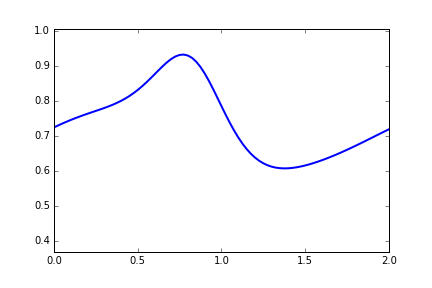
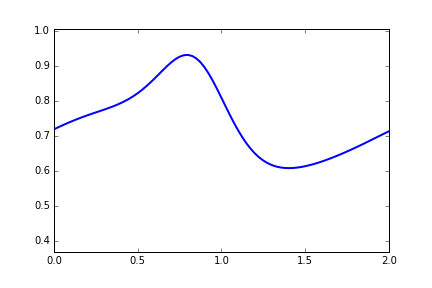
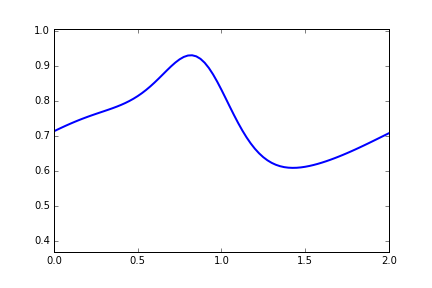
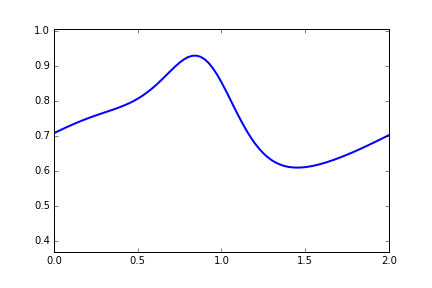
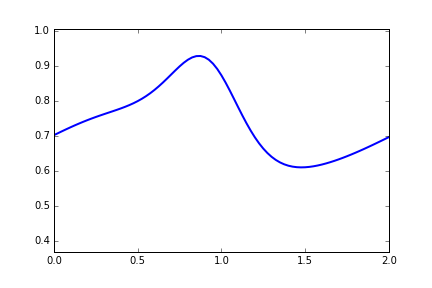
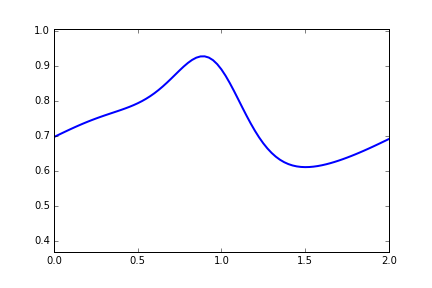
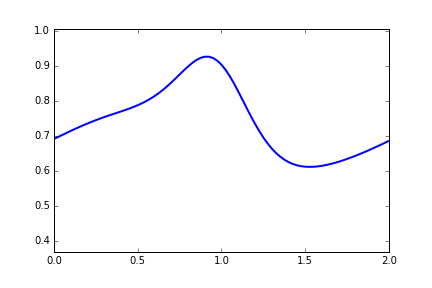
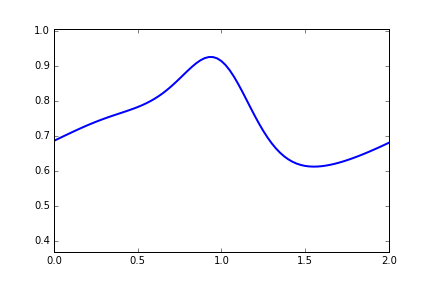
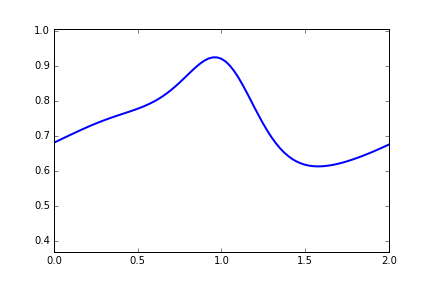
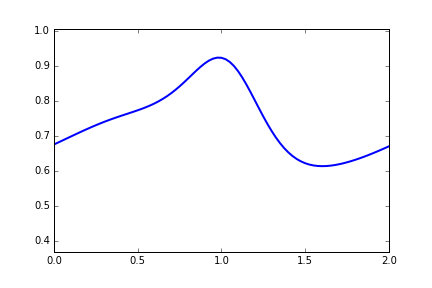
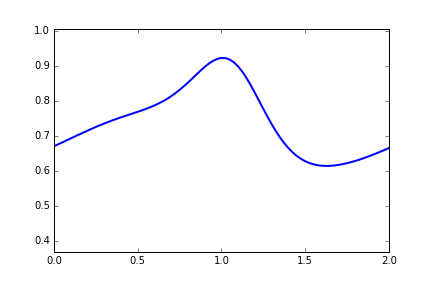
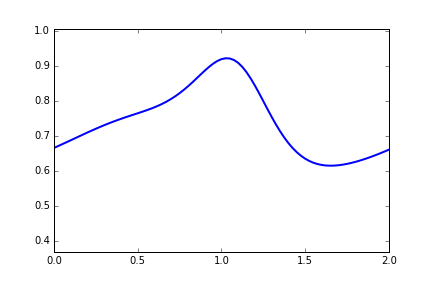
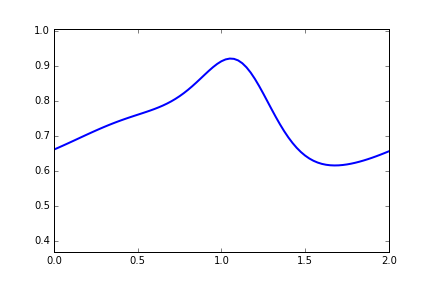
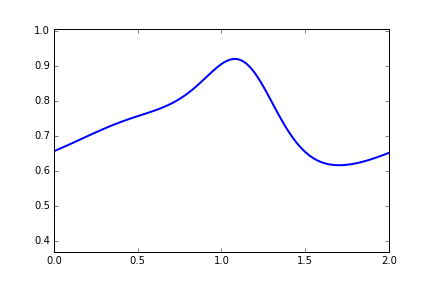
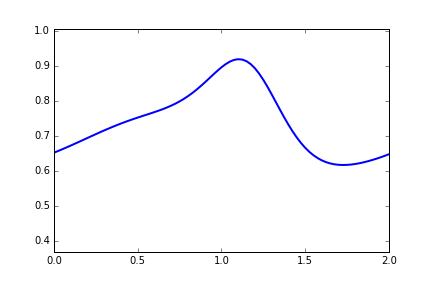
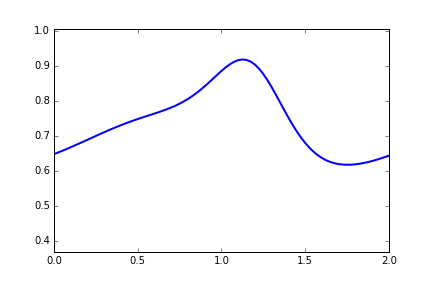
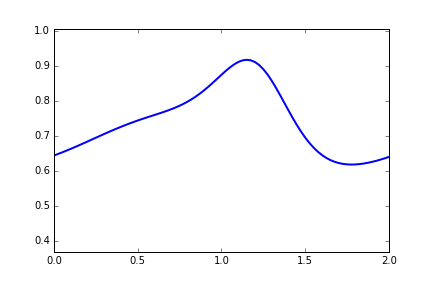
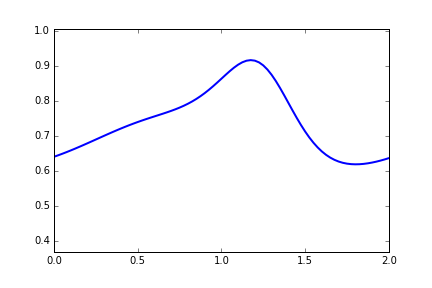
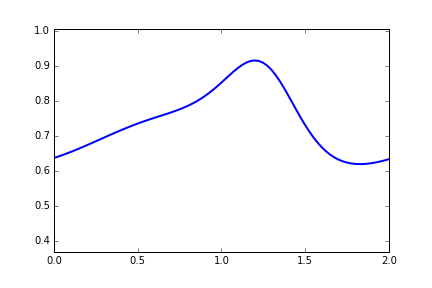
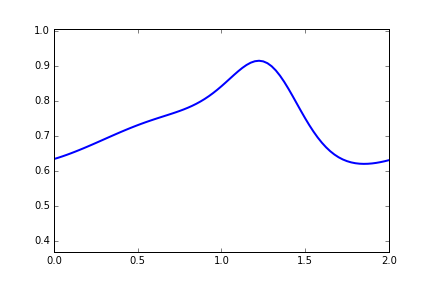
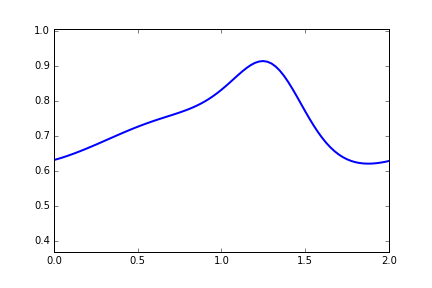
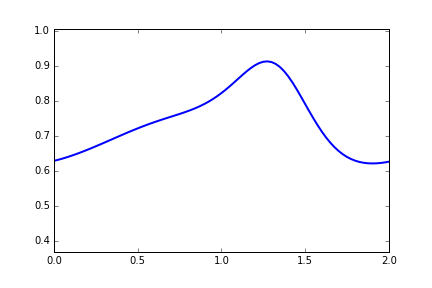
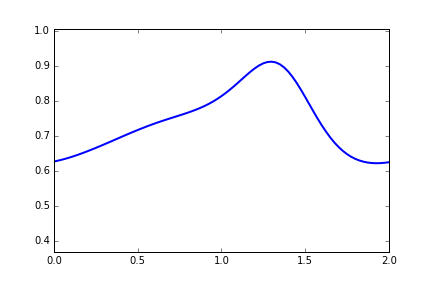
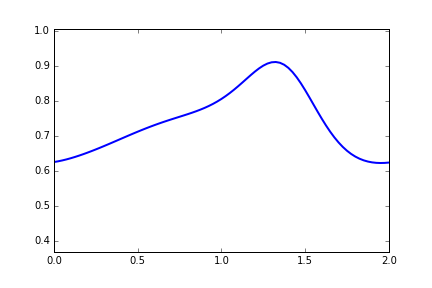
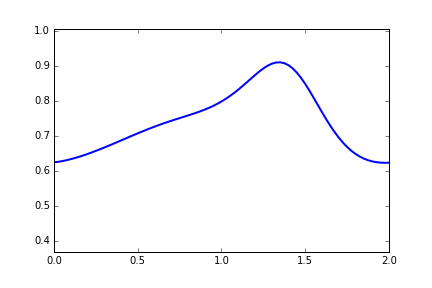
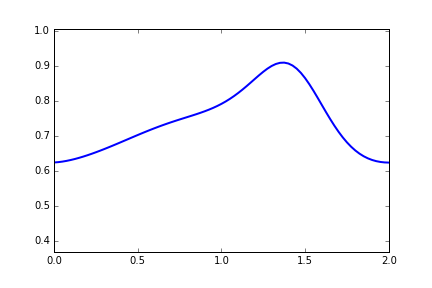
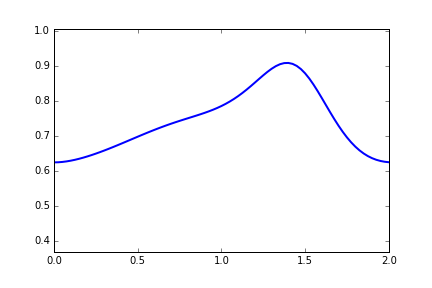
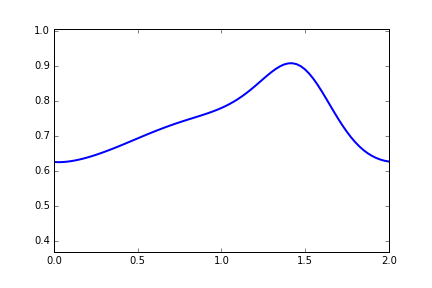
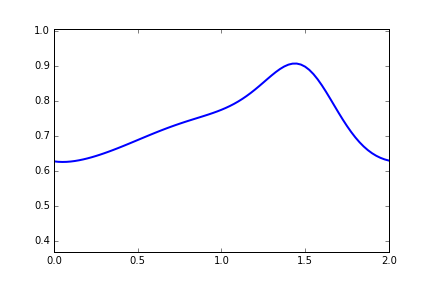
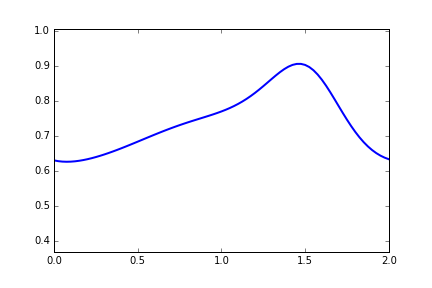
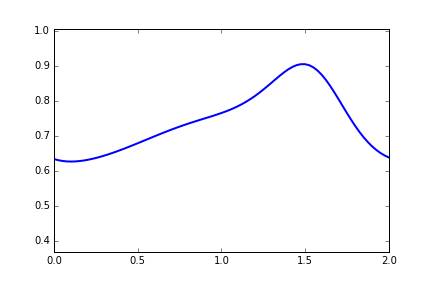
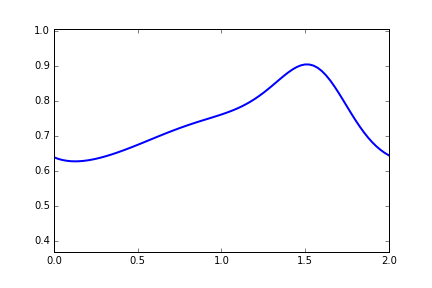
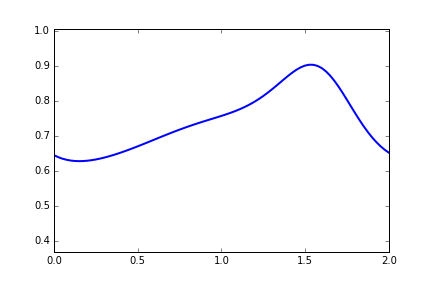
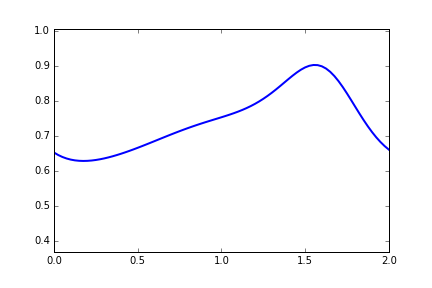
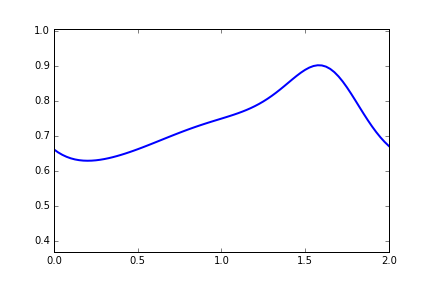
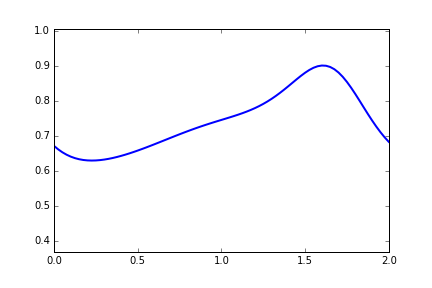
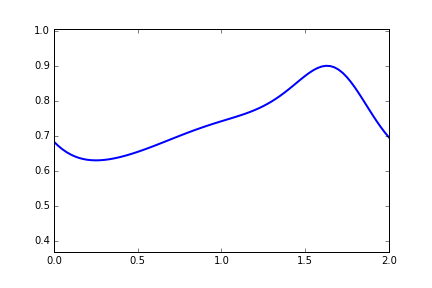
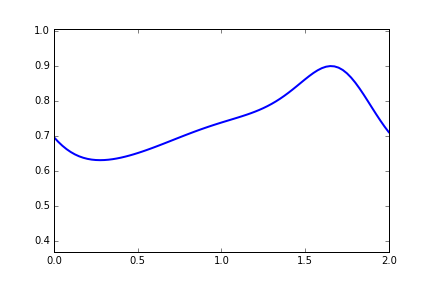
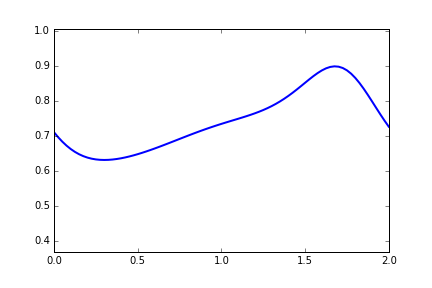
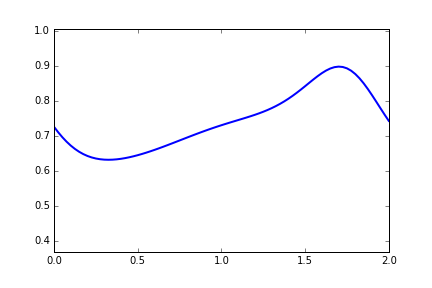
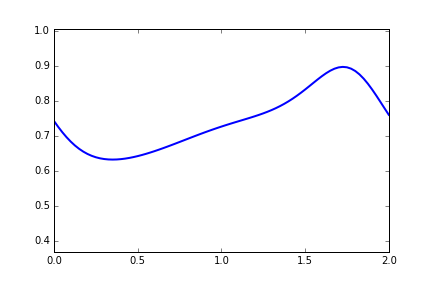
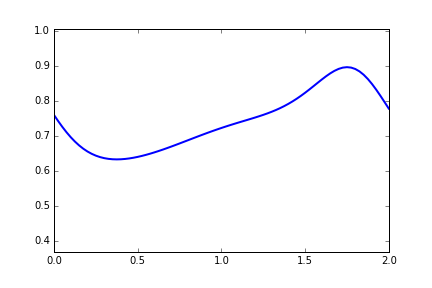
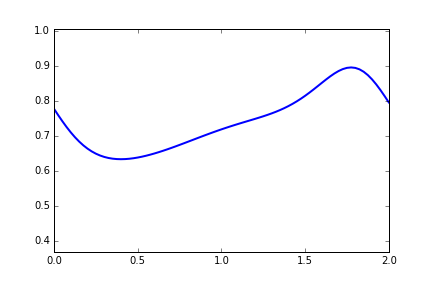
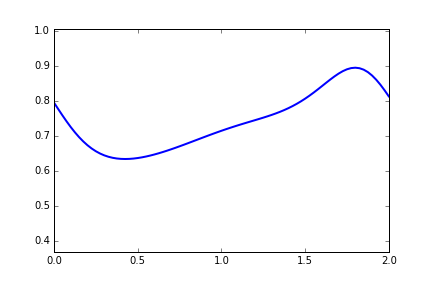
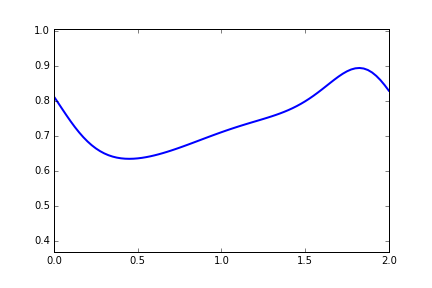
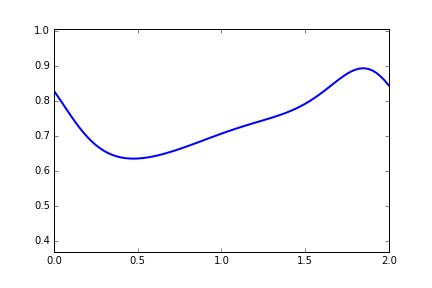
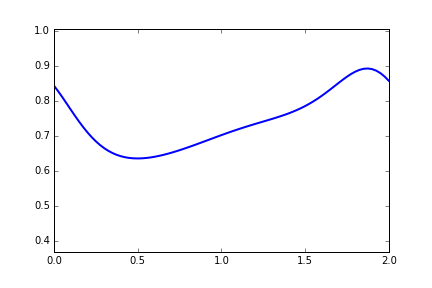
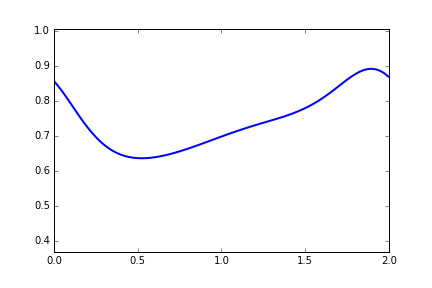
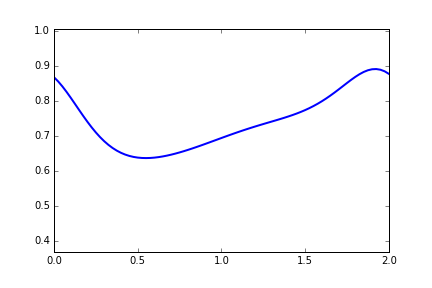
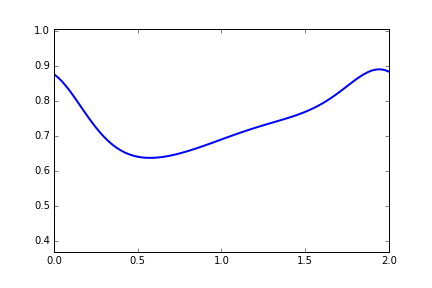
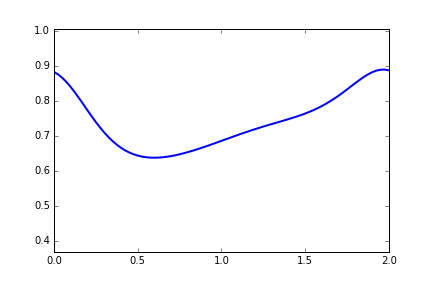
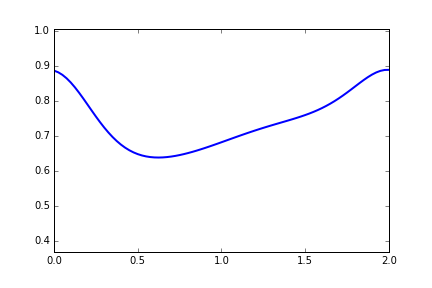

In [14]:
fig = plt.figure()
ax = plt.axes(xlim=(xmin, L), ylim=(np.amin(uall), np.amax(uall)))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    #ax.annotate(r'$t = %f $' %tall[i],(1,1))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=uall.shape[-1], interval=30)

## Case Study 3: Sinusoidal profile

In [15]:
u = np.cos(x*np.pi)
uall, tall = kdv.runRk4FVFourier(x,u,t0=0,tmax=2,a=1,b=1)


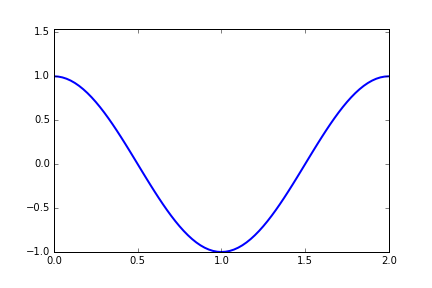
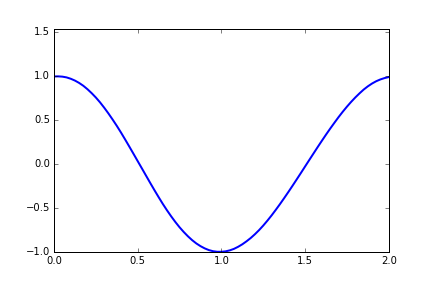
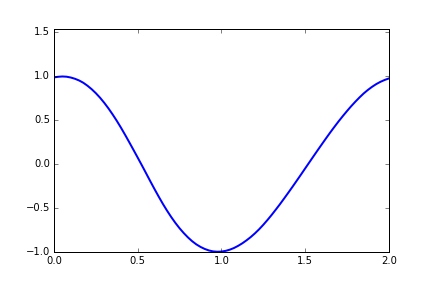
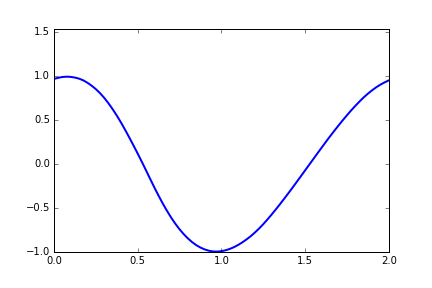
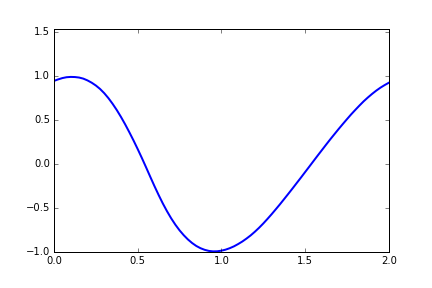
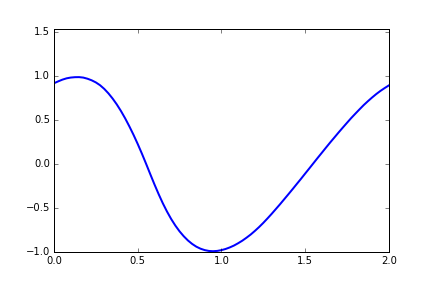
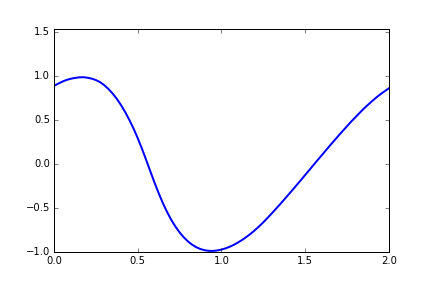
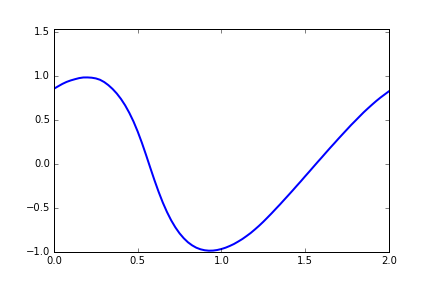
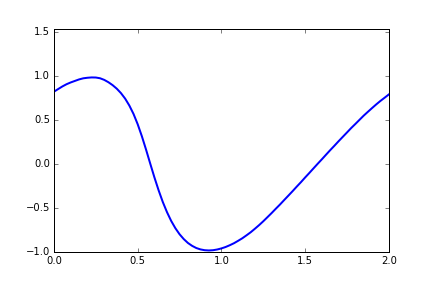
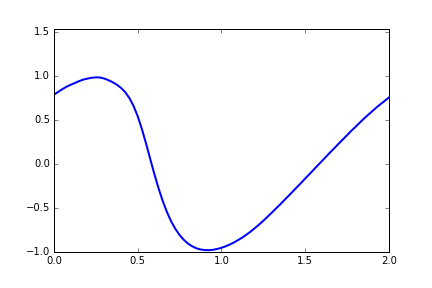
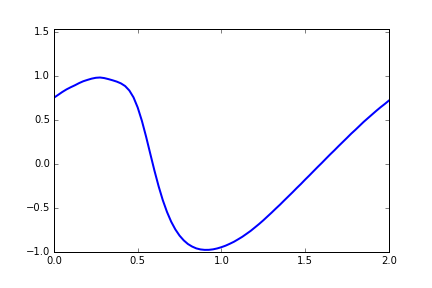
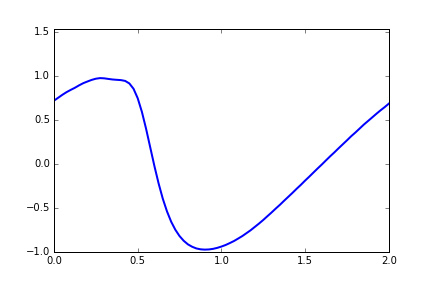
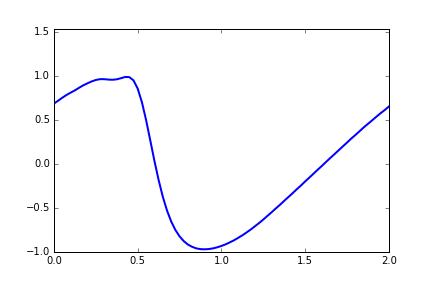
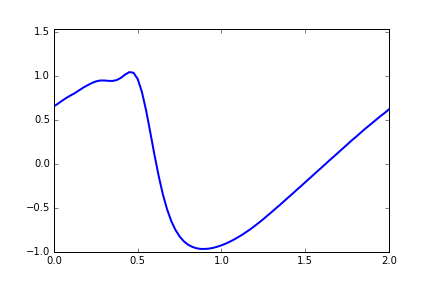
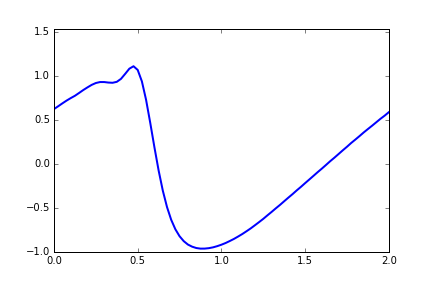
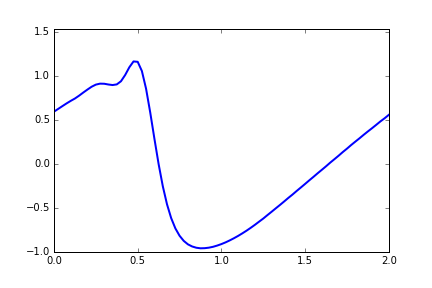
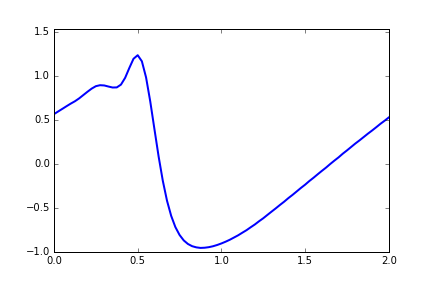
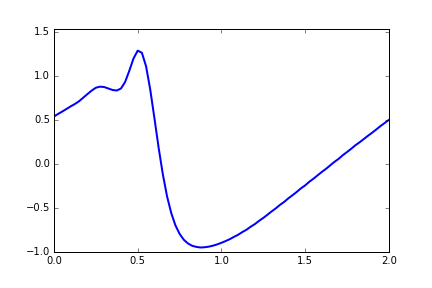
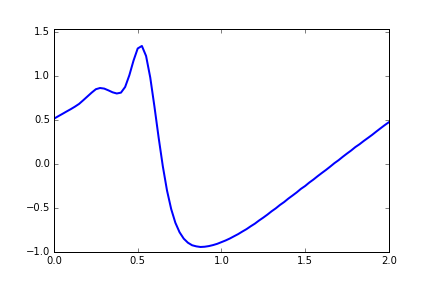
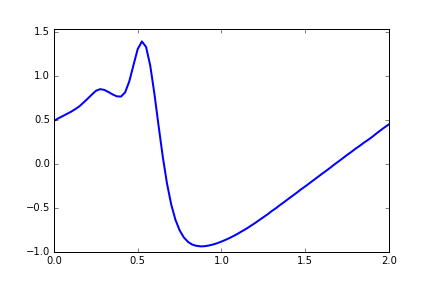
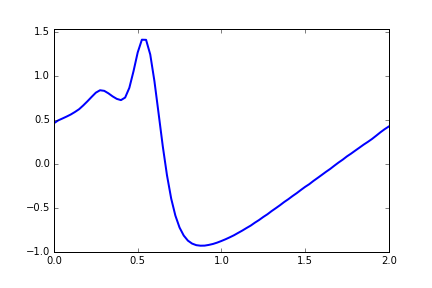
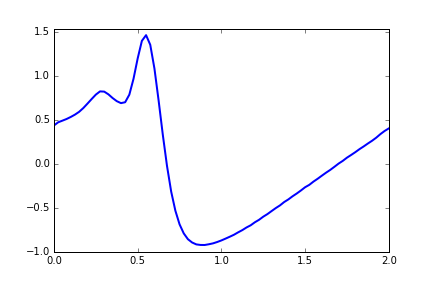
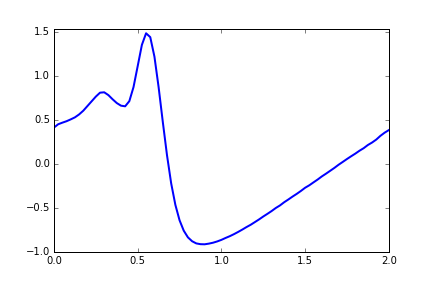
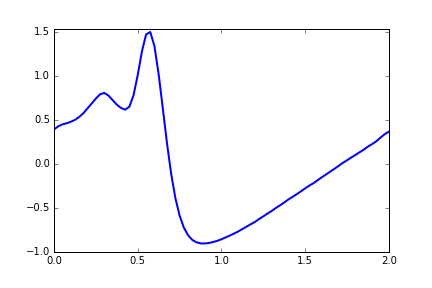
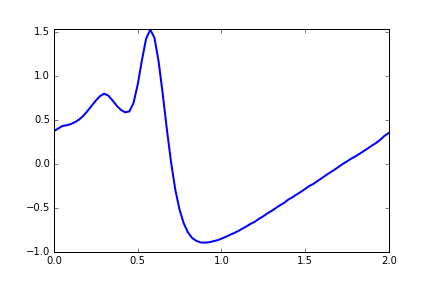
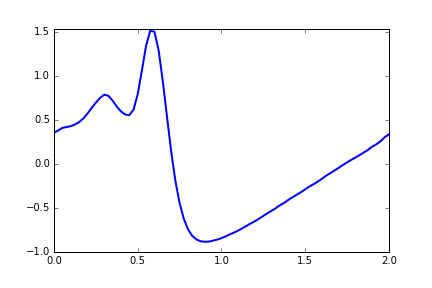
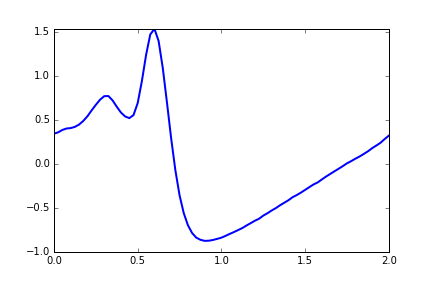
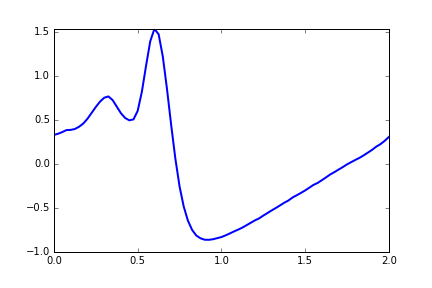
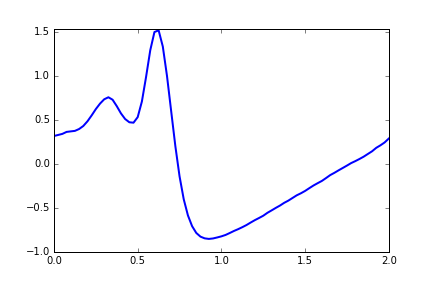
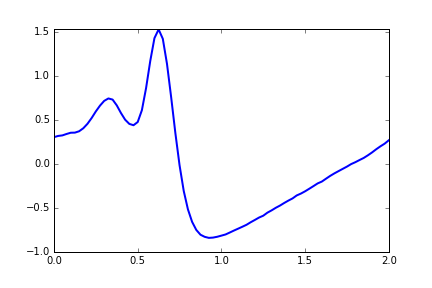
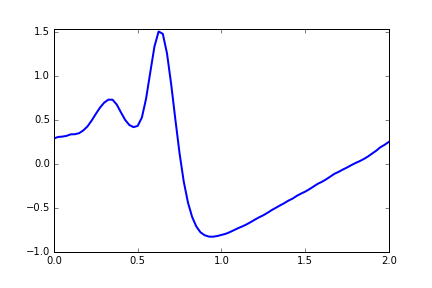
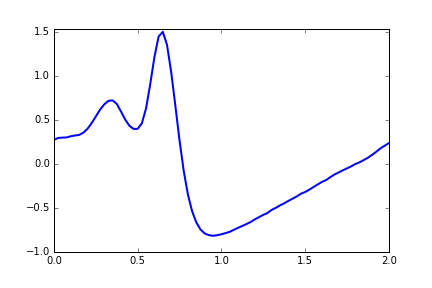
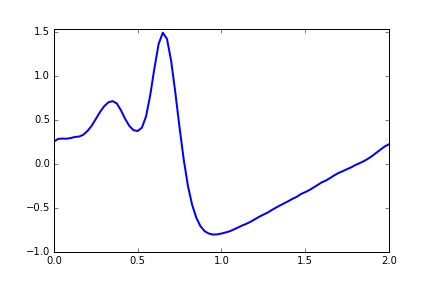
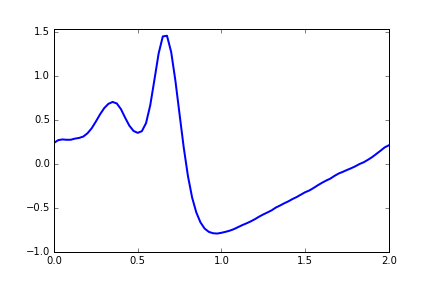
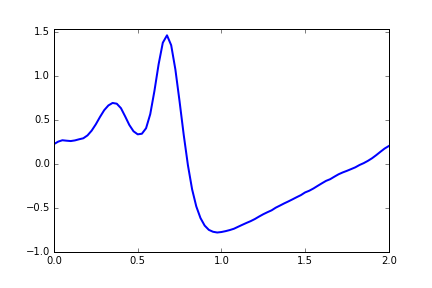
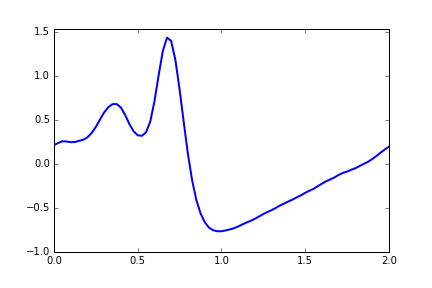
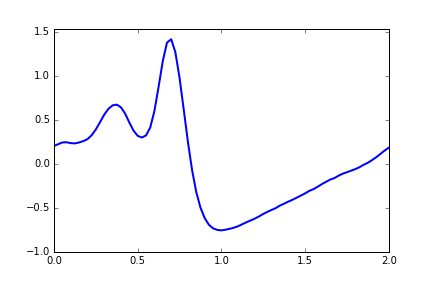
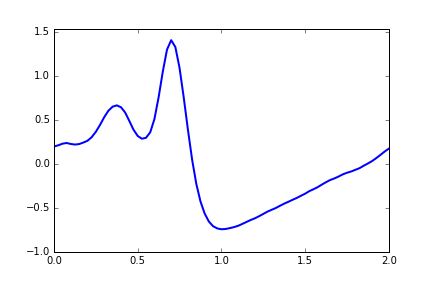
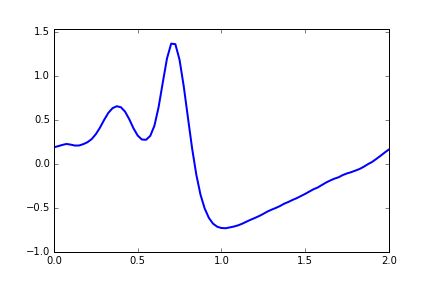
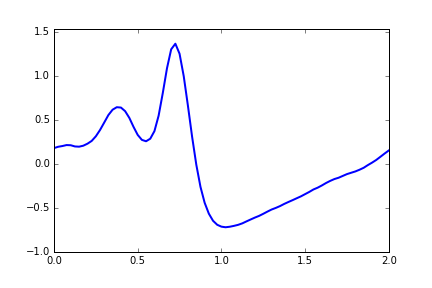
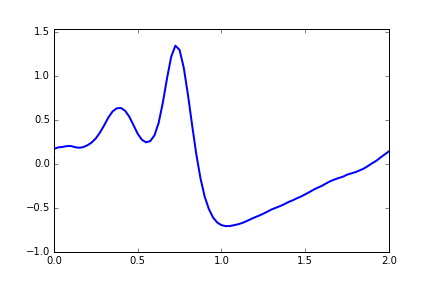
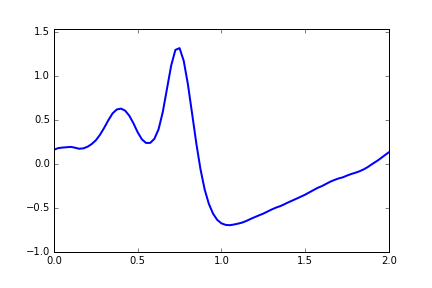
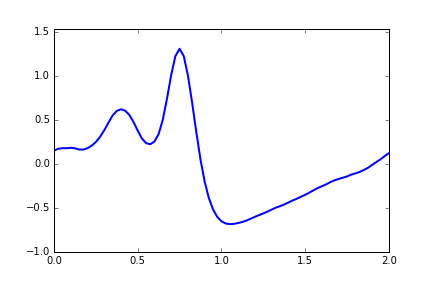
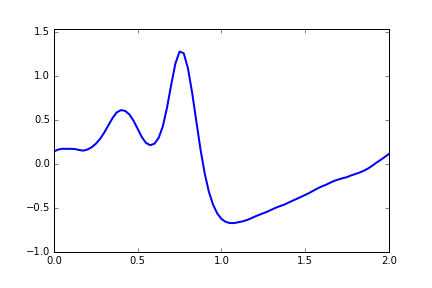
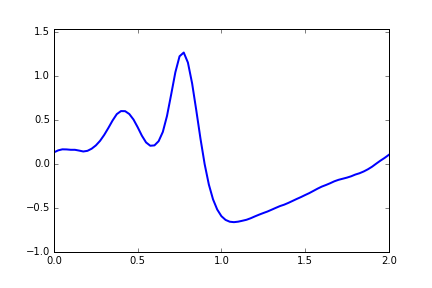
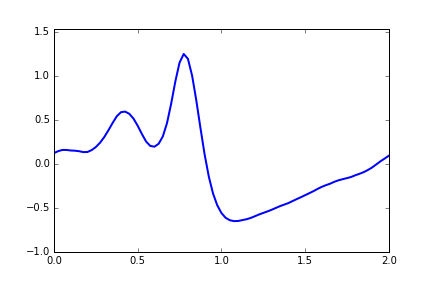
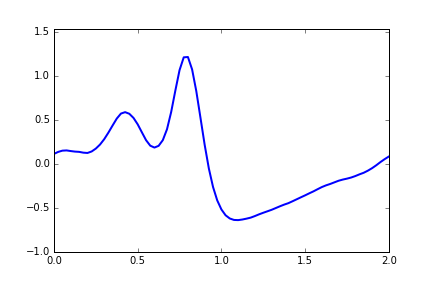
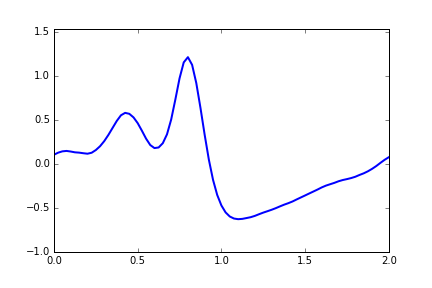
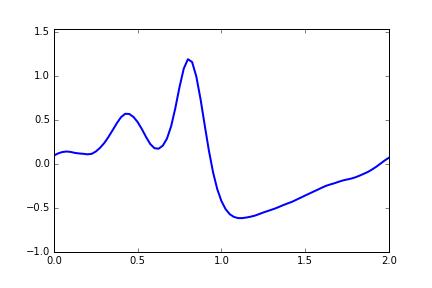
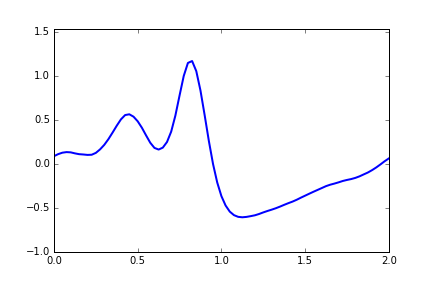
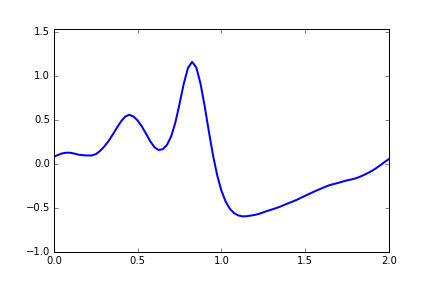
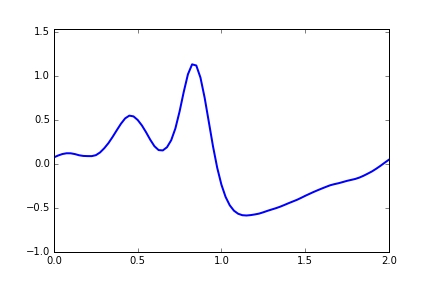
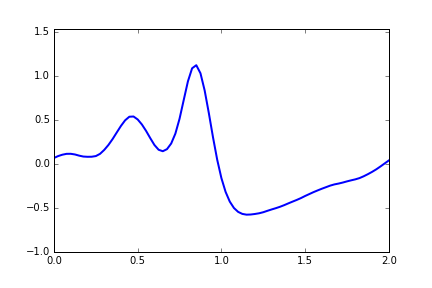
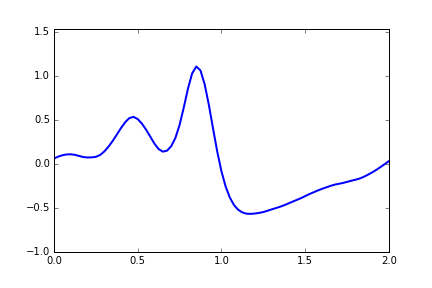
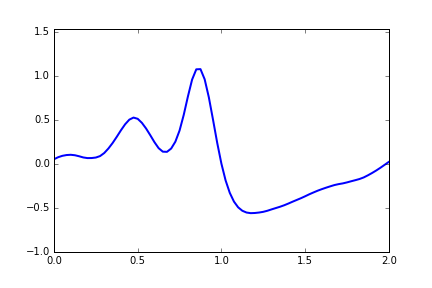
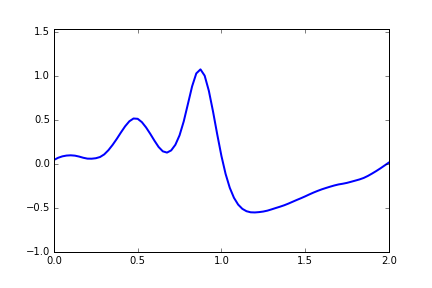
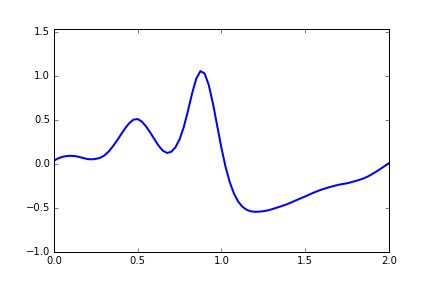
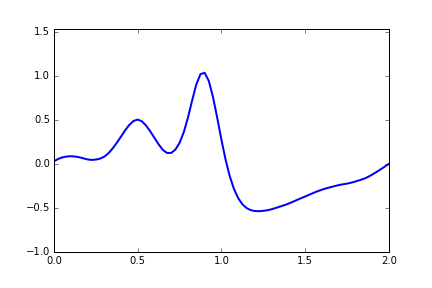
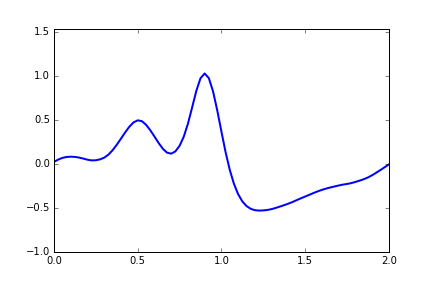
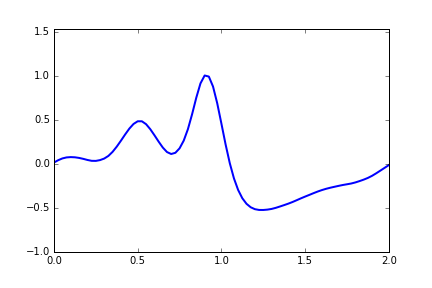
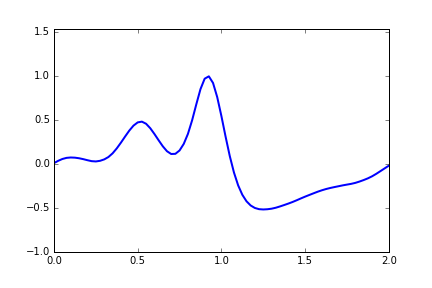
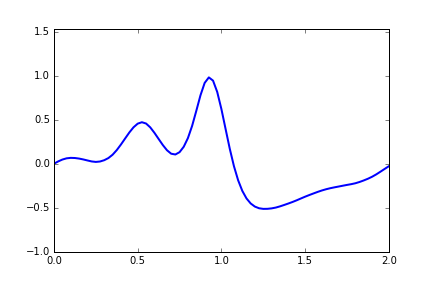
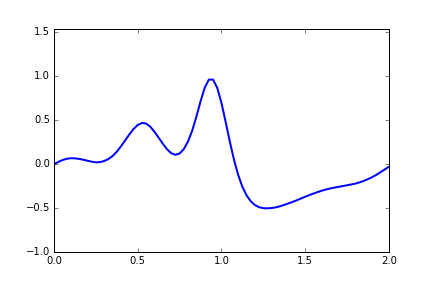
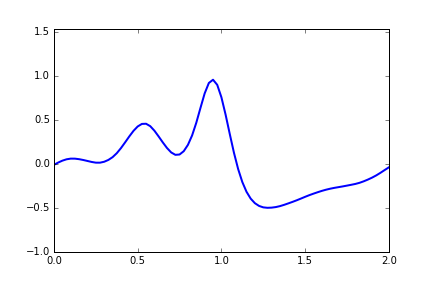
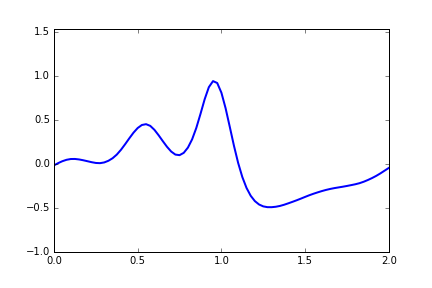
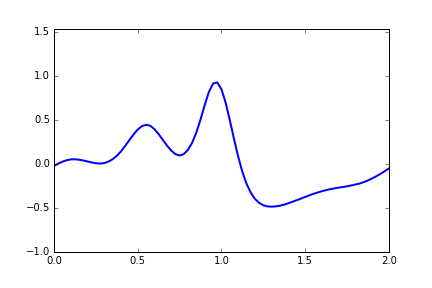
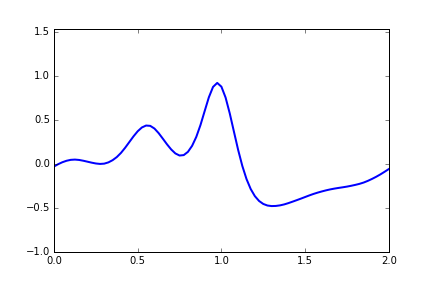
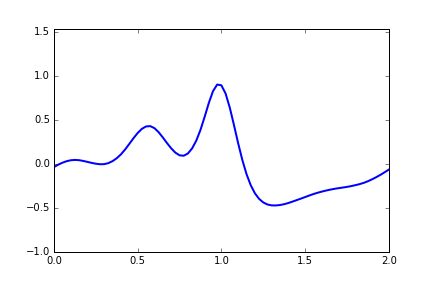
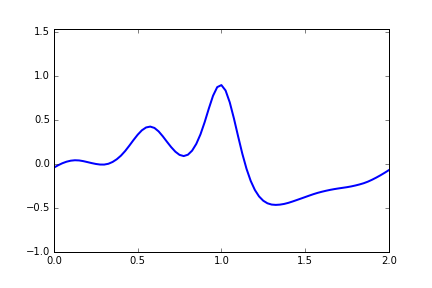
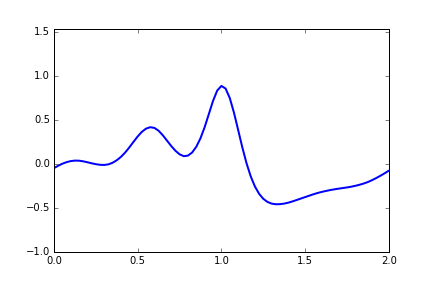
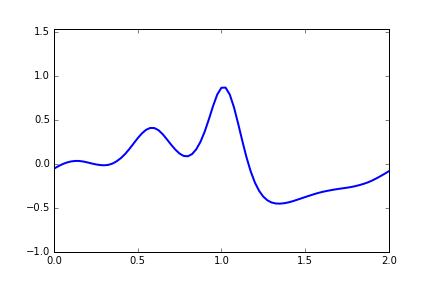
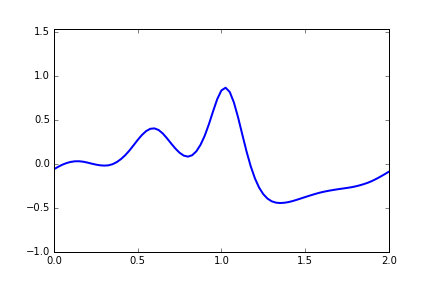
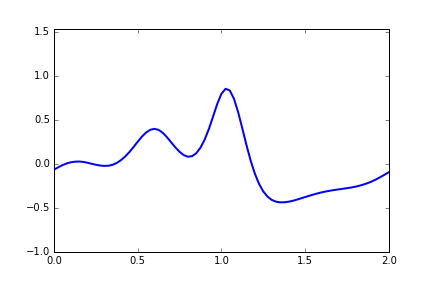
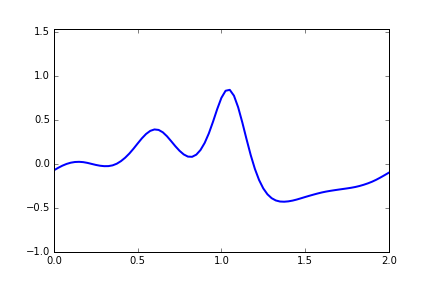
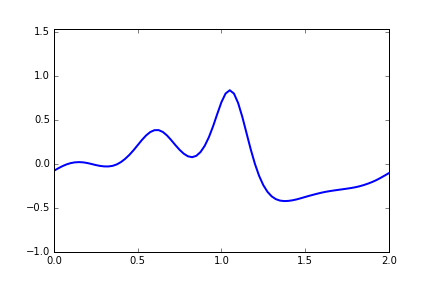
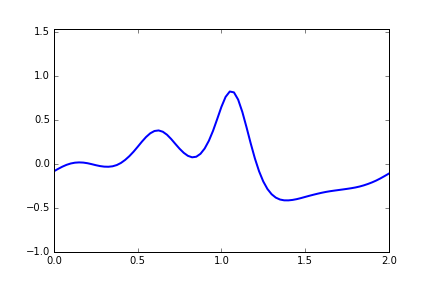
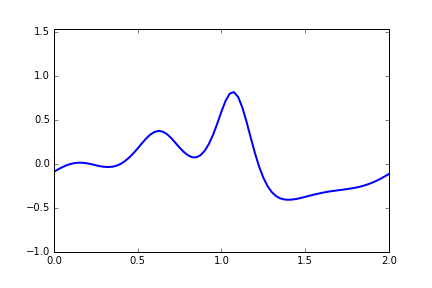
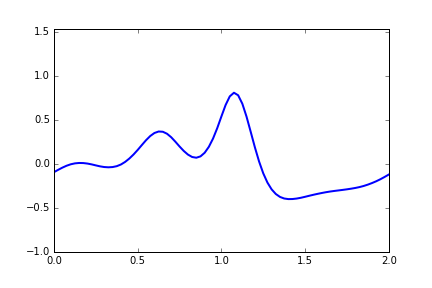
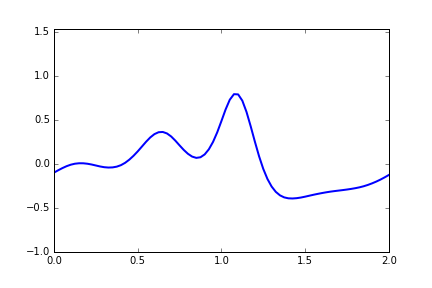
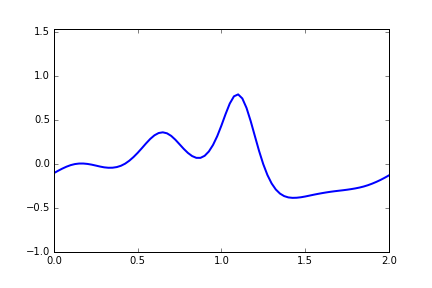
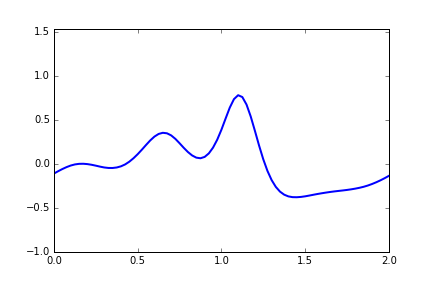
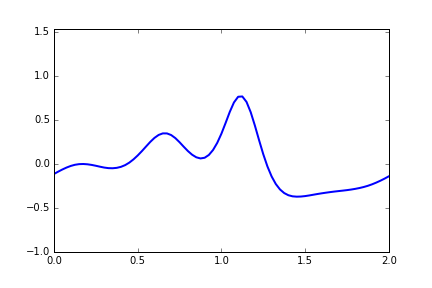
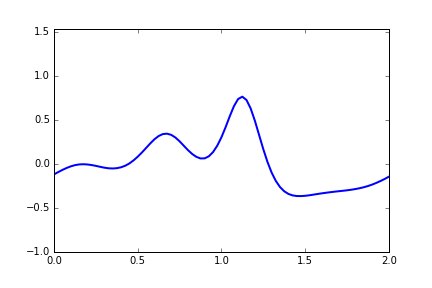
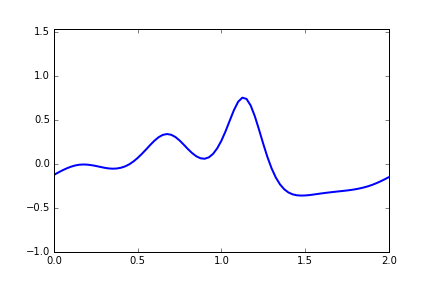
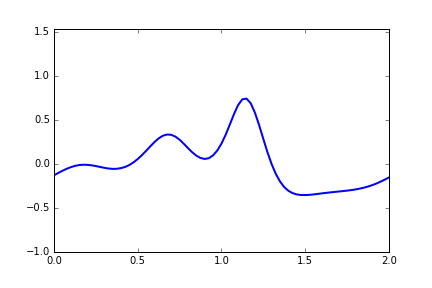
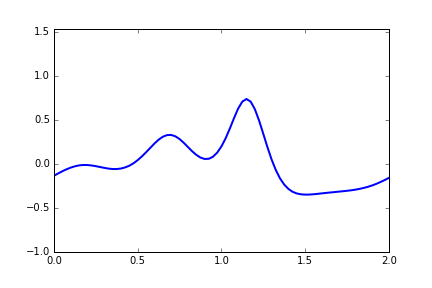
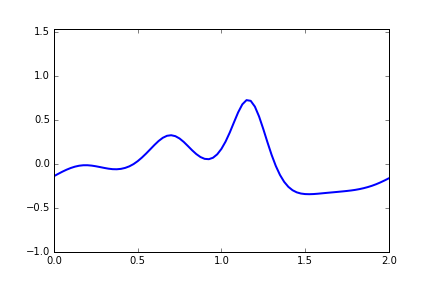
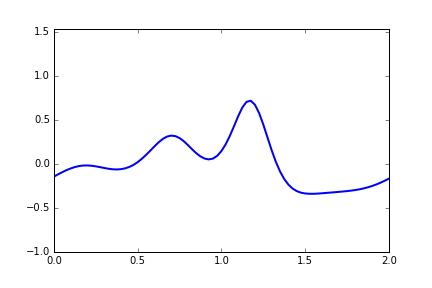
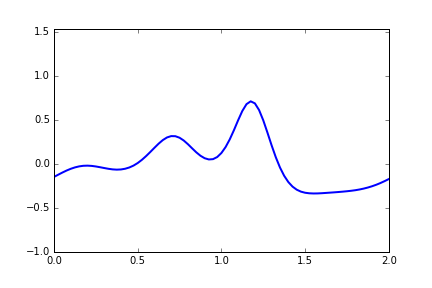
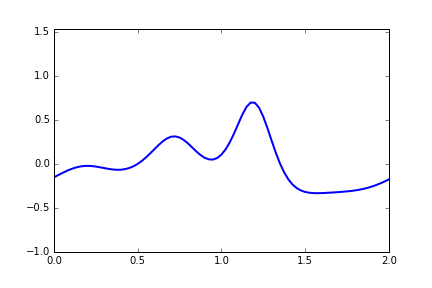
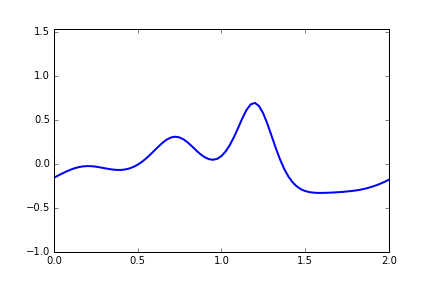
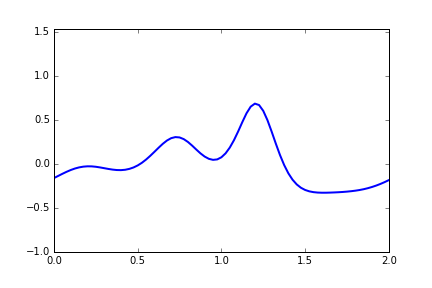
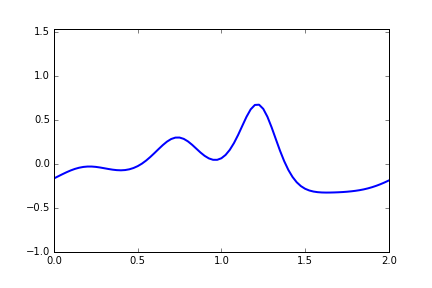
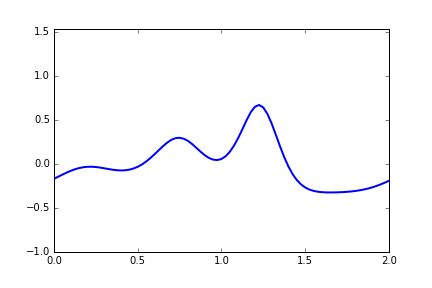
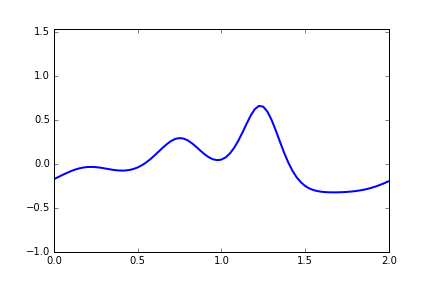
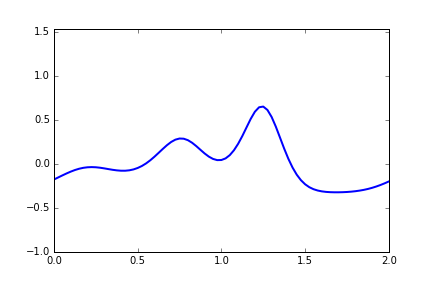
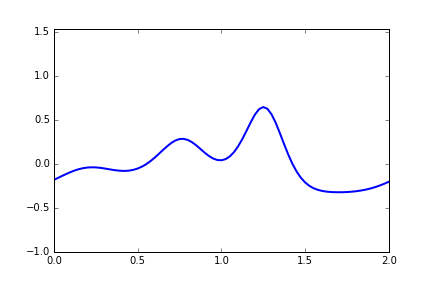
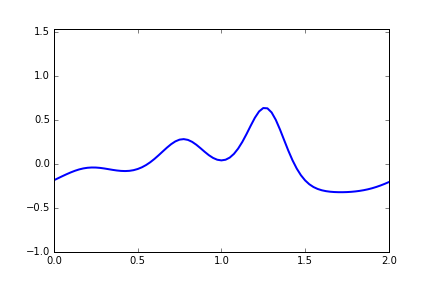
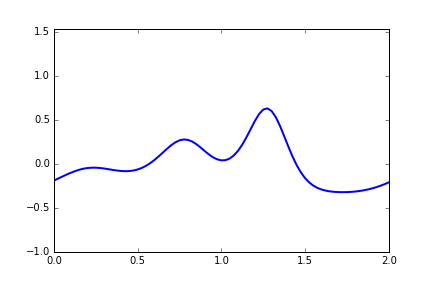
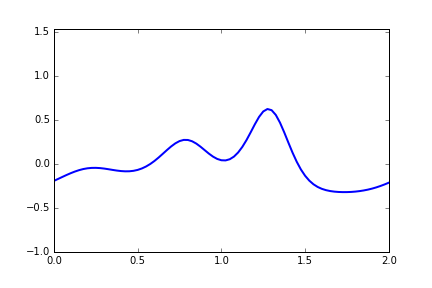
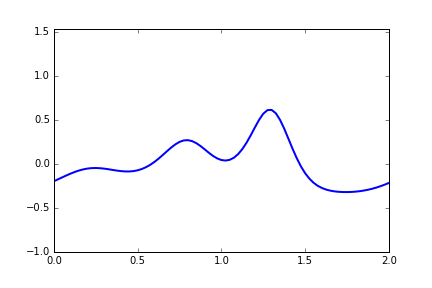
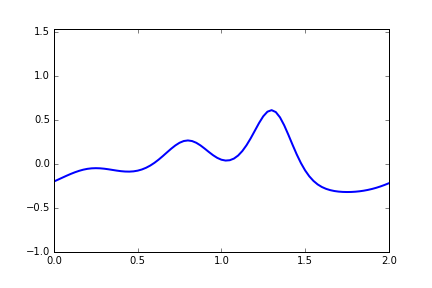
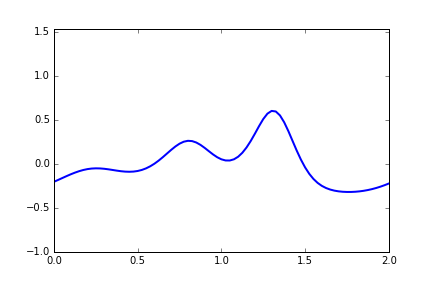
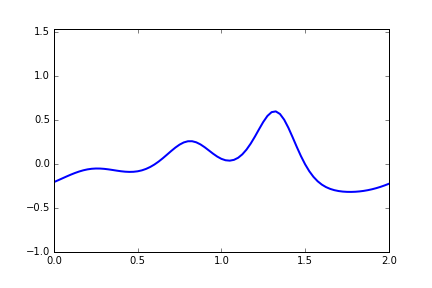
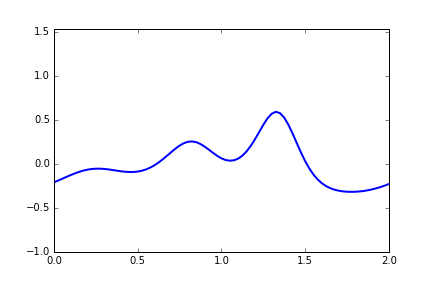
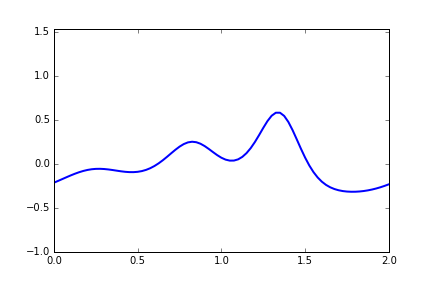
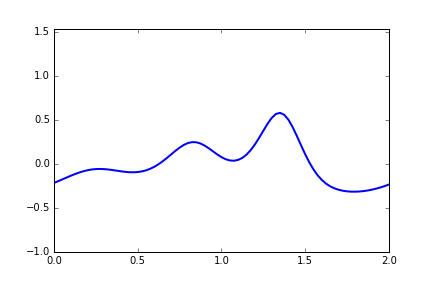
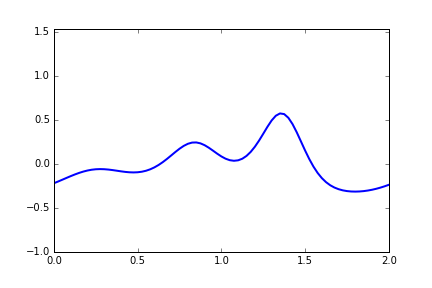
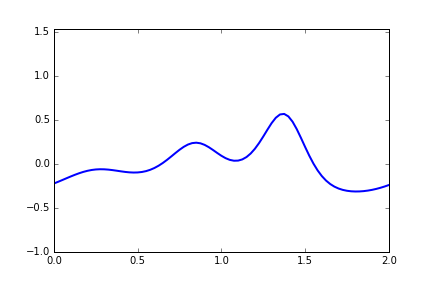
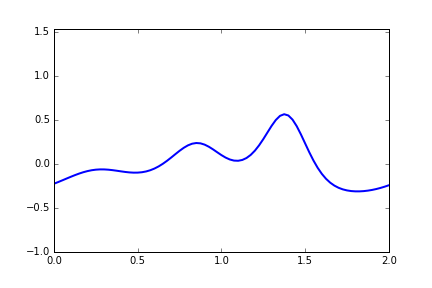
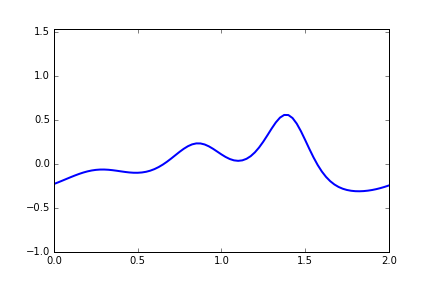
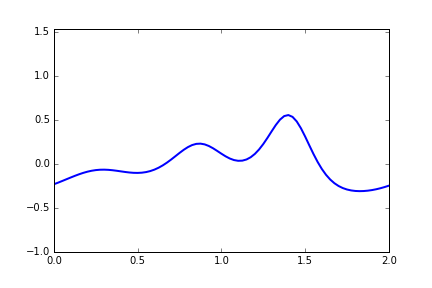
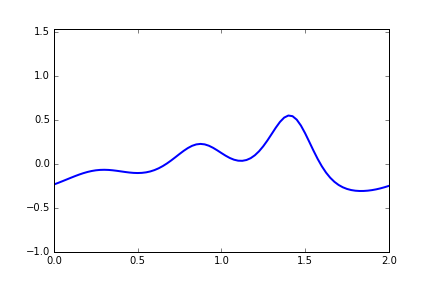
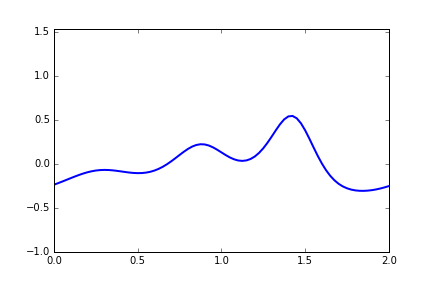
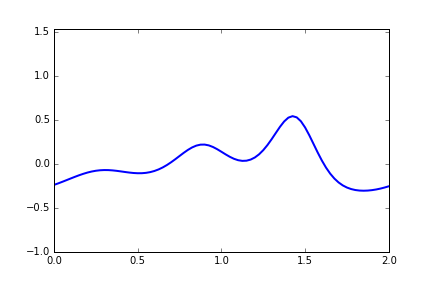
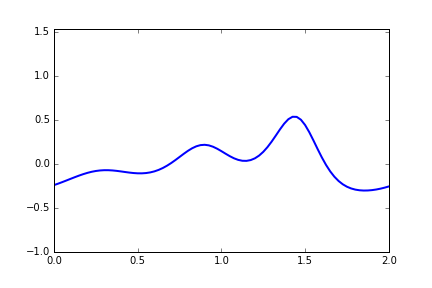
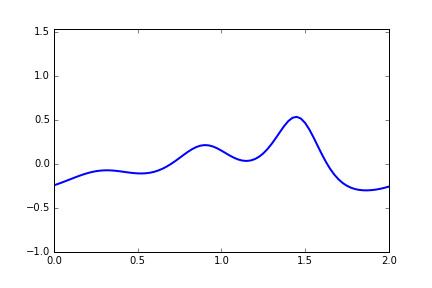
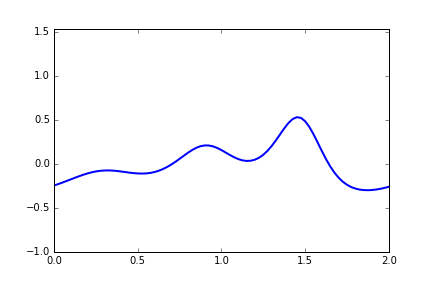
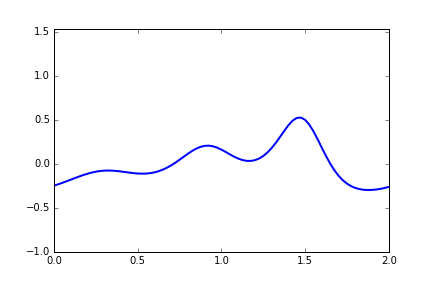
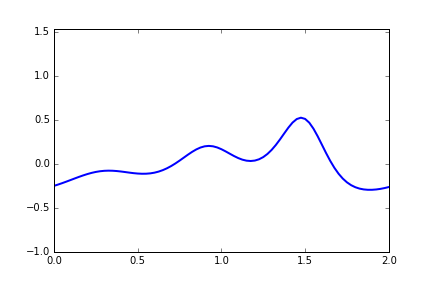
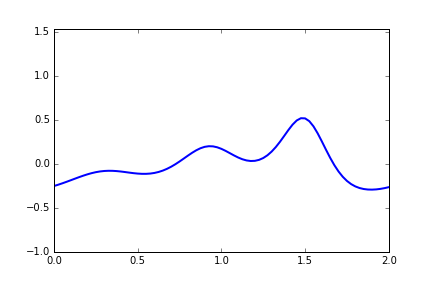
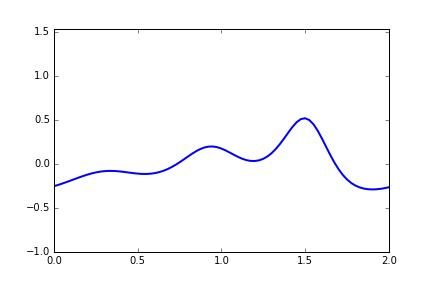
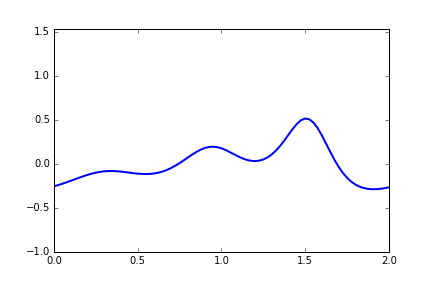
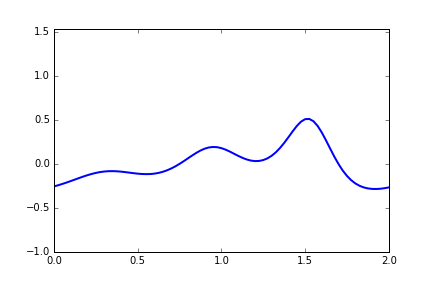
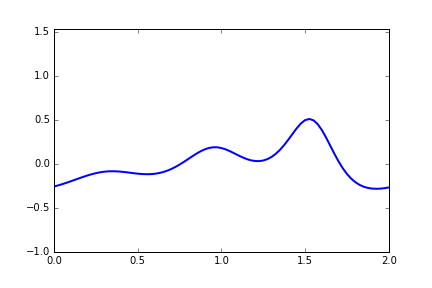
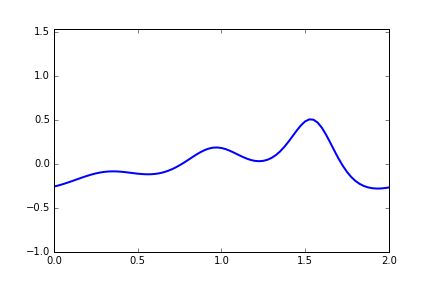
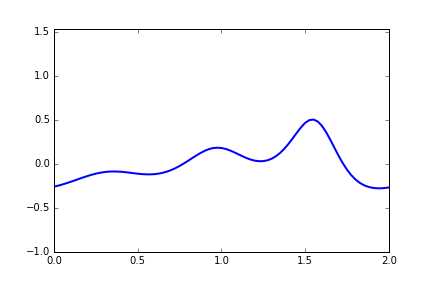
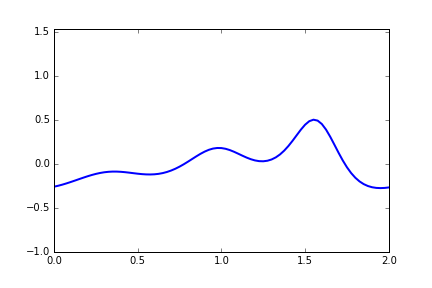
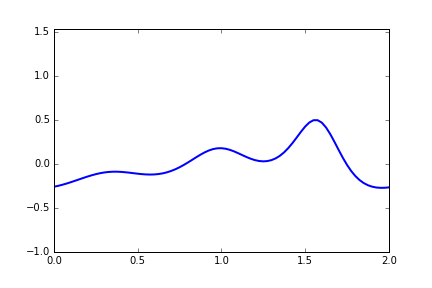
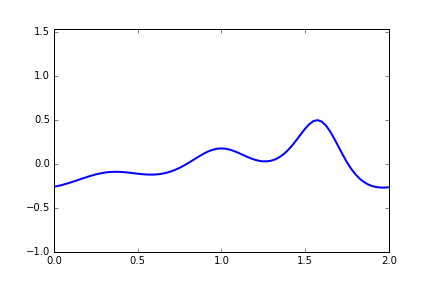
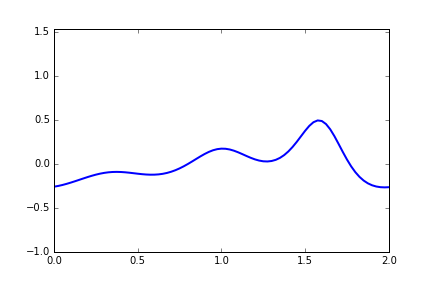
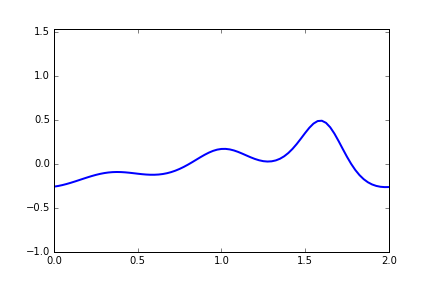
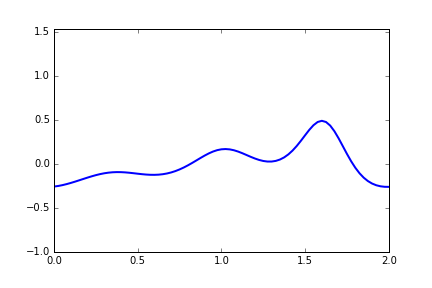
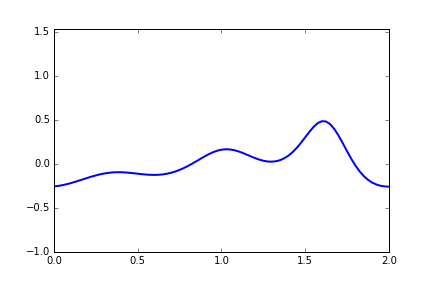
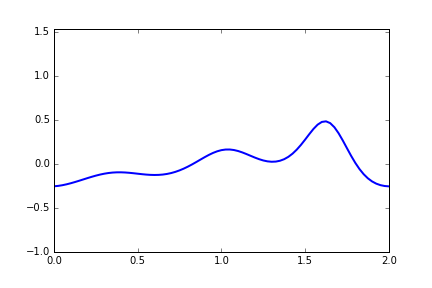
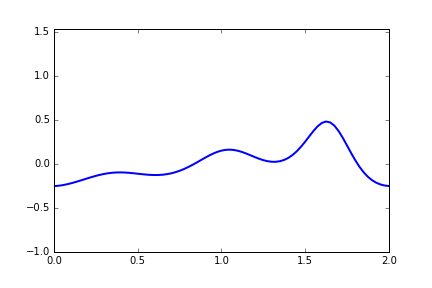
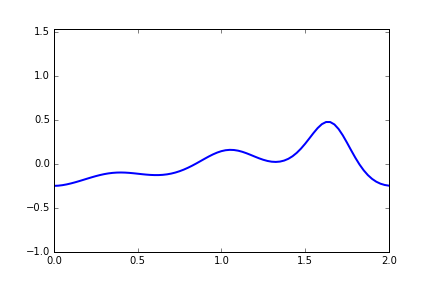
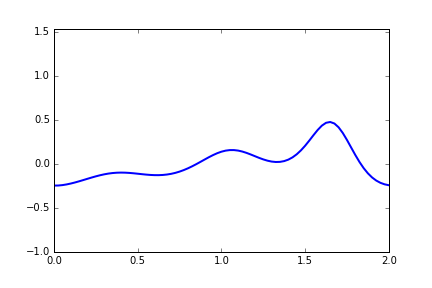
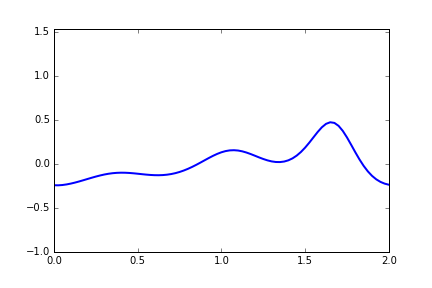
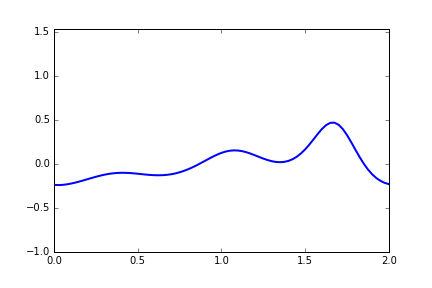
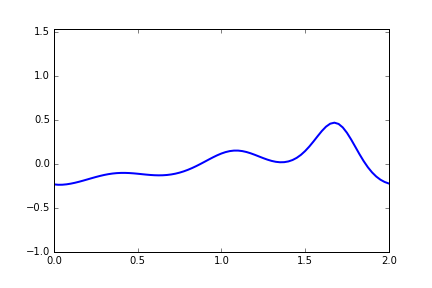
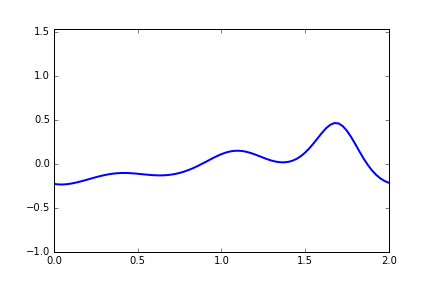
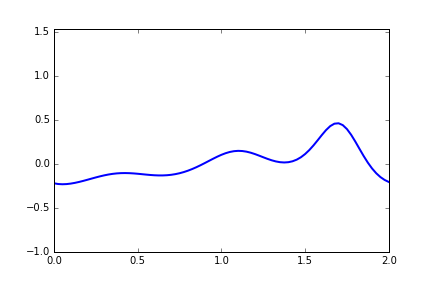
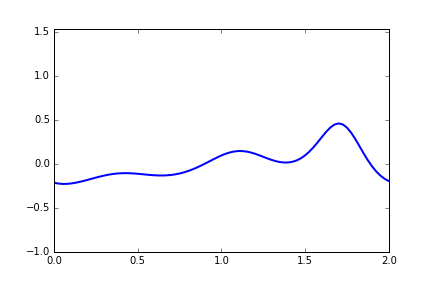
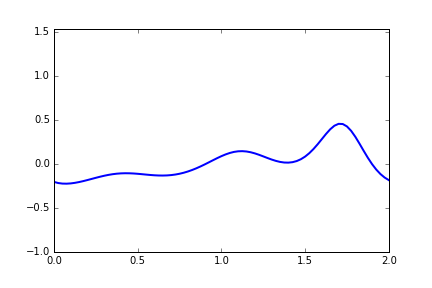
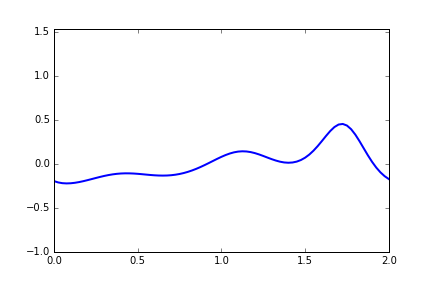
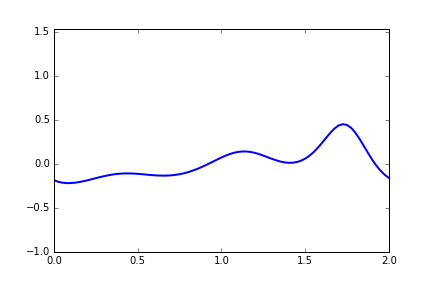
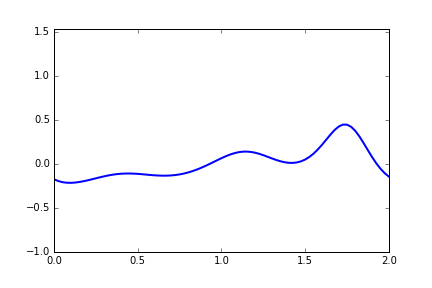
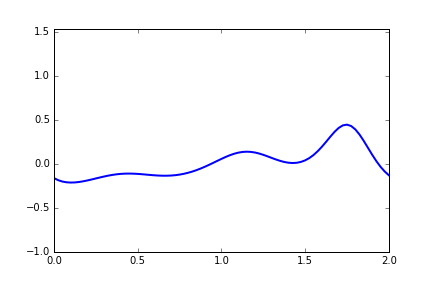
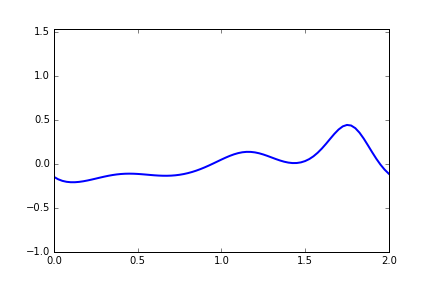
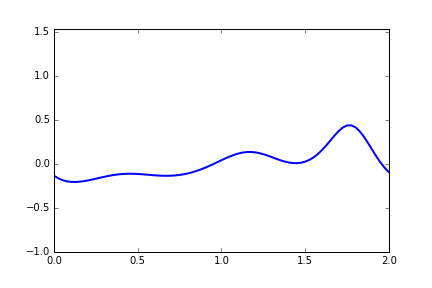
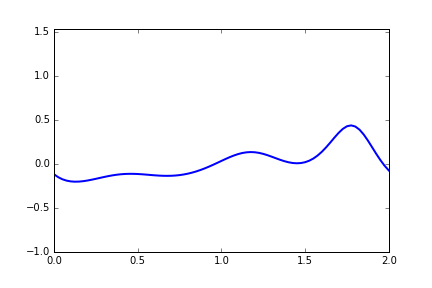
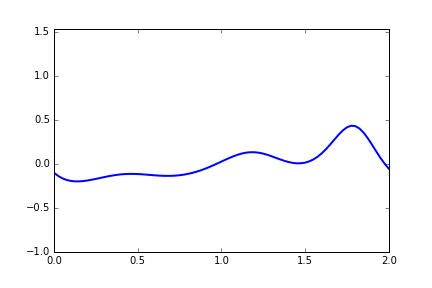
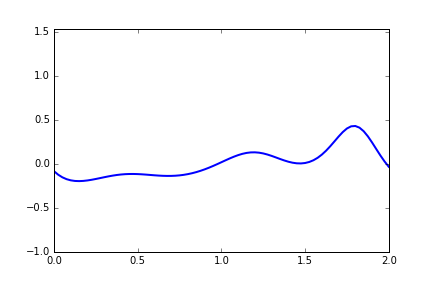
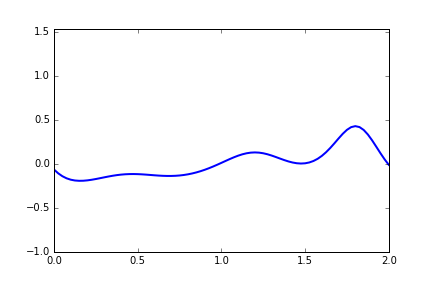
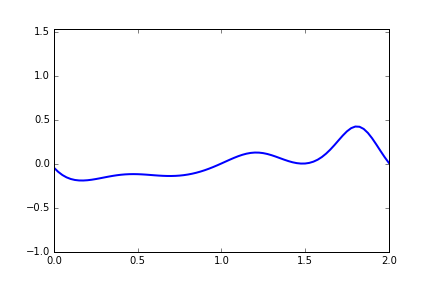
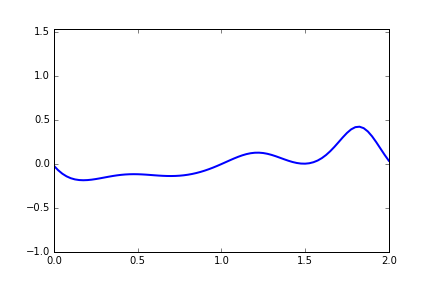
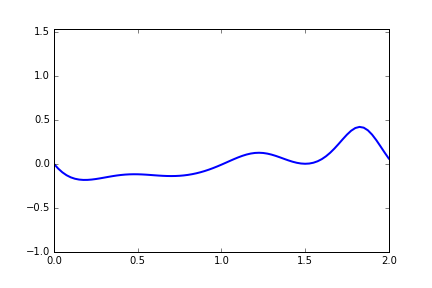
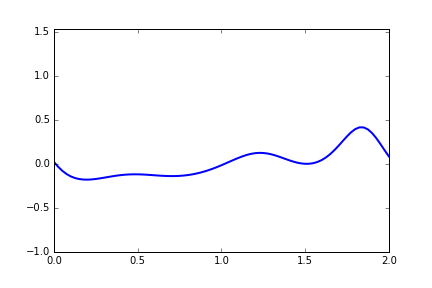
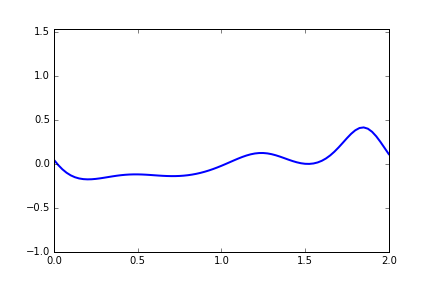
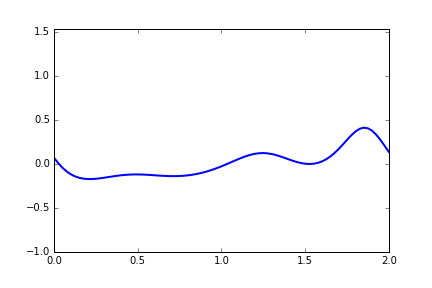
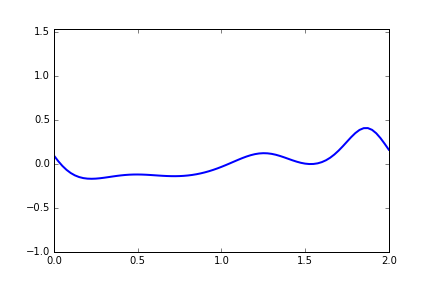
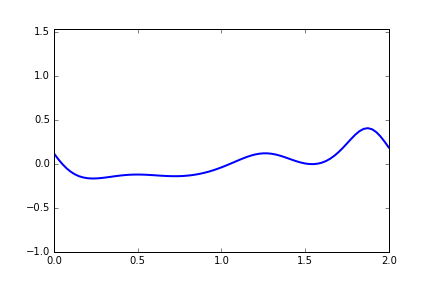
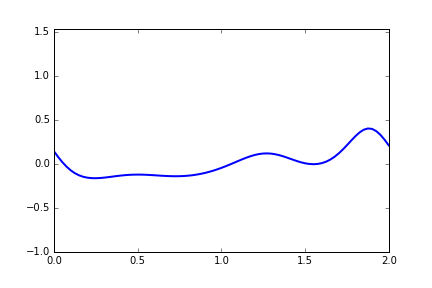
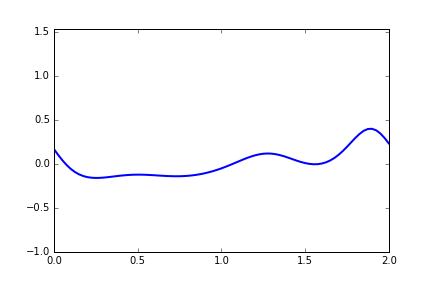
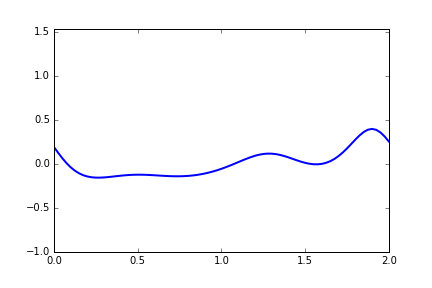
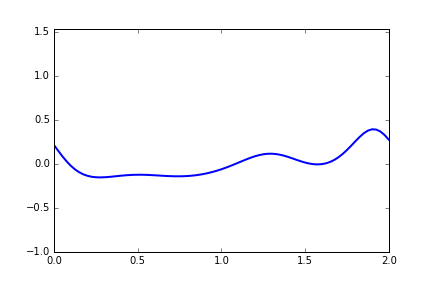
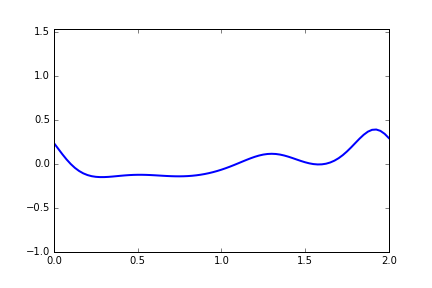
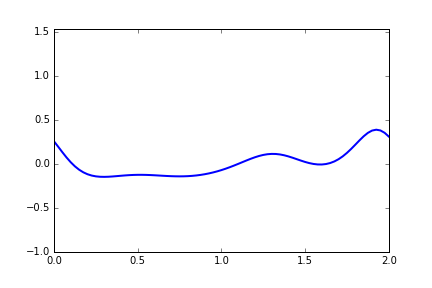
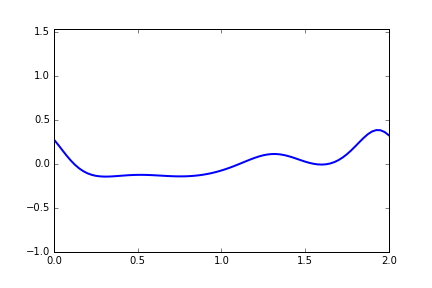
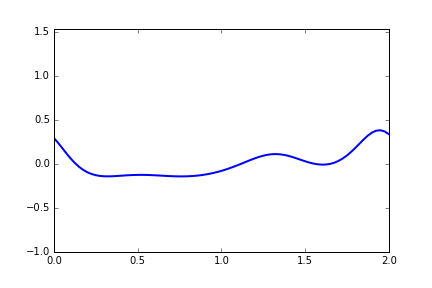
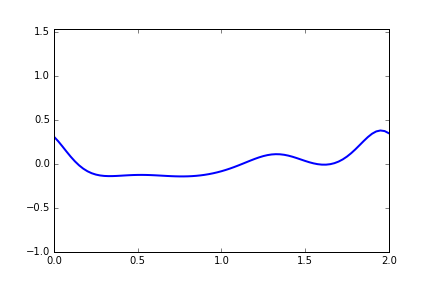
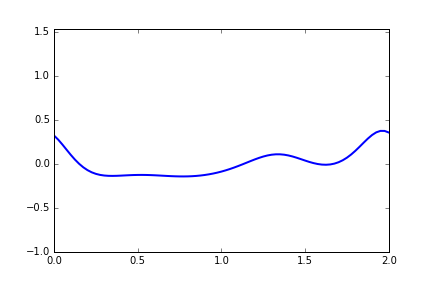
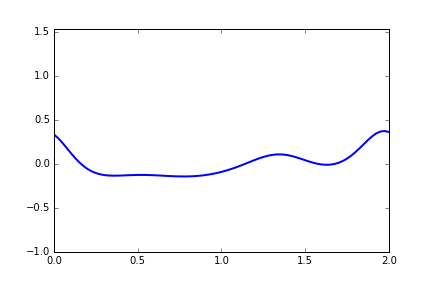
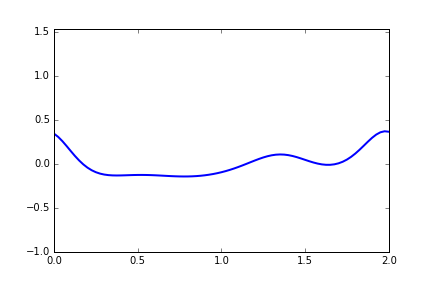
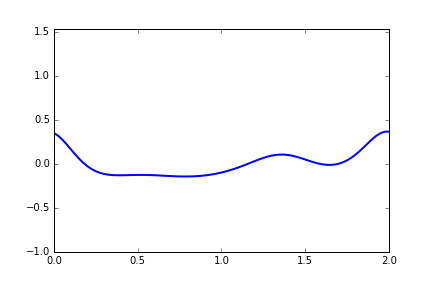
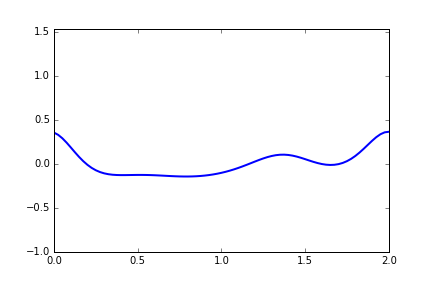
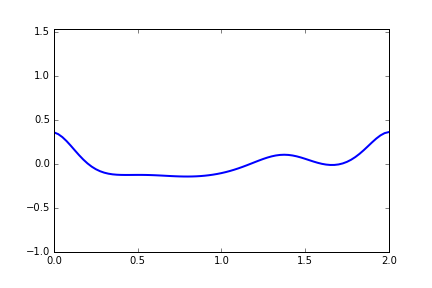
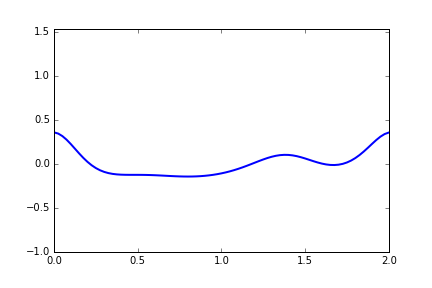
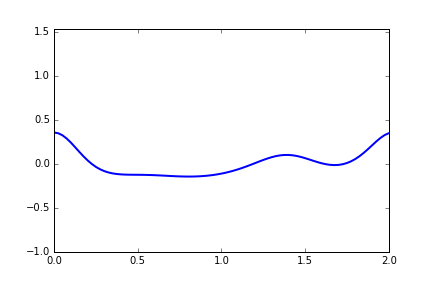
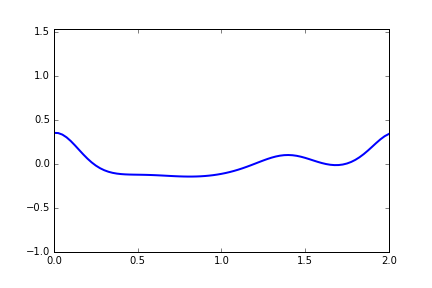
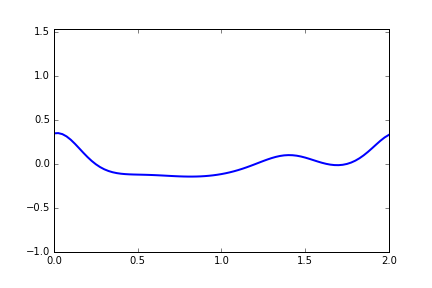
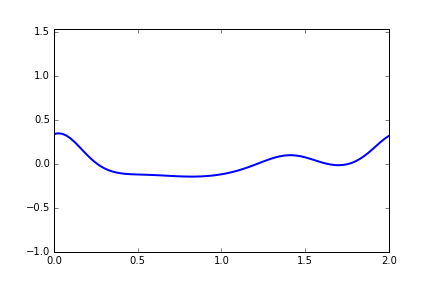
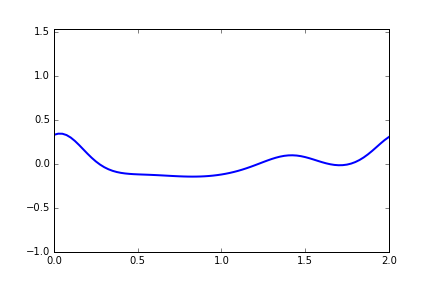
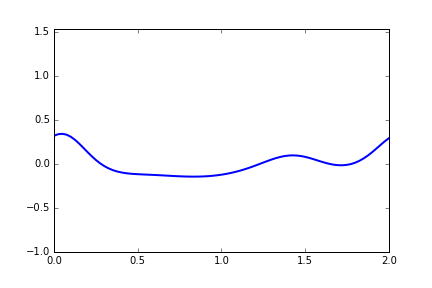
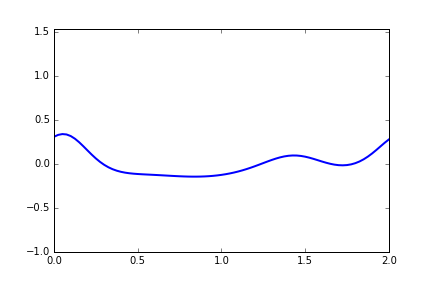
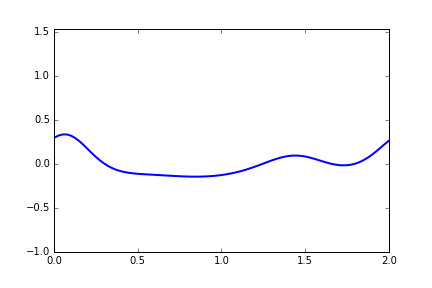
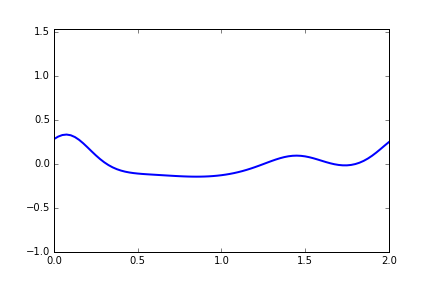
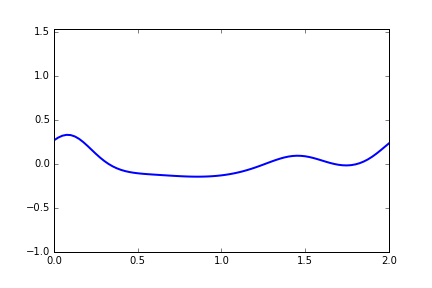
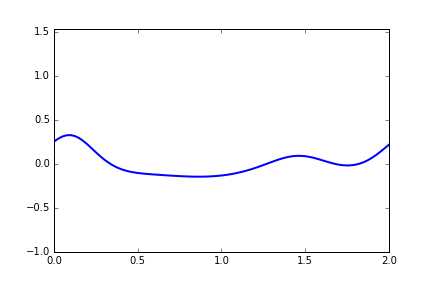
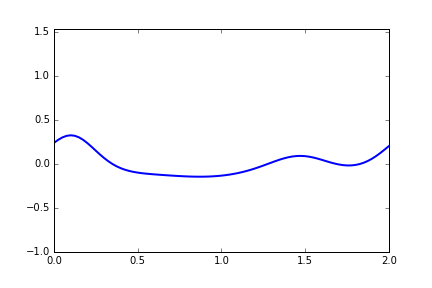
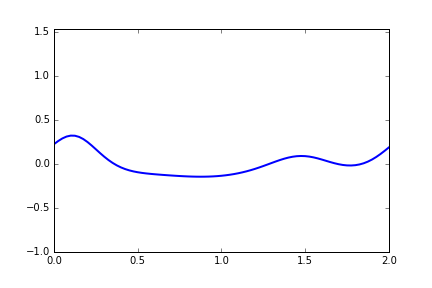
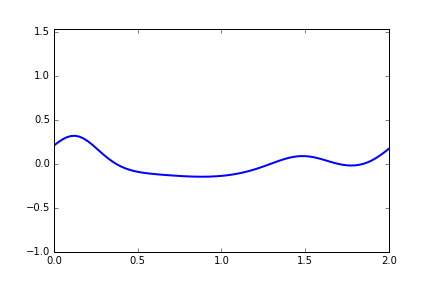
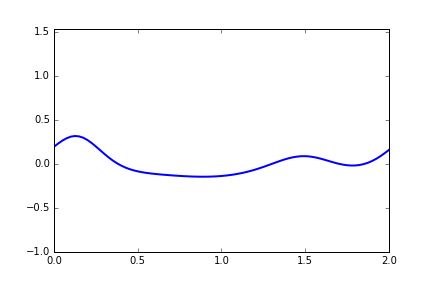
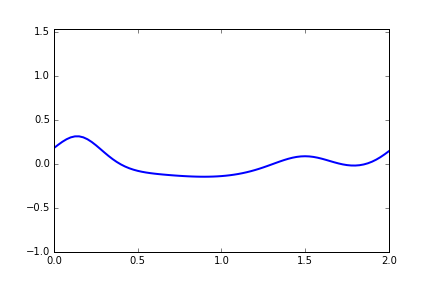
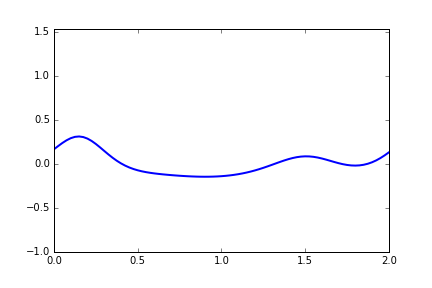
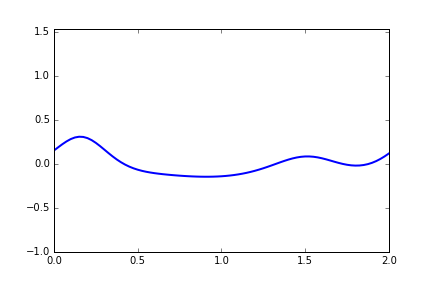
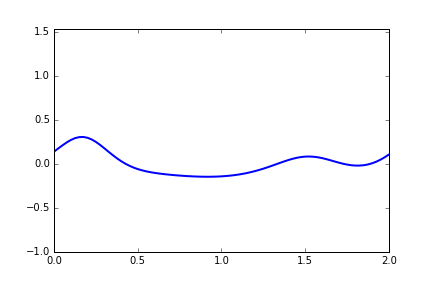
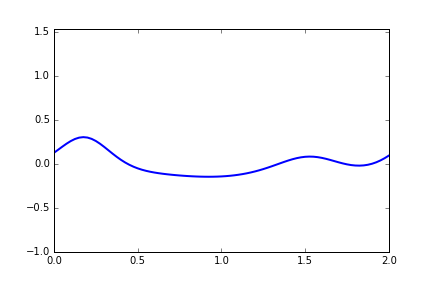
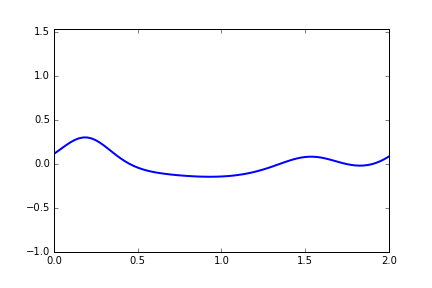
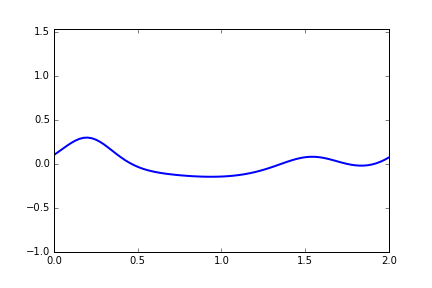

In [16]:
fig = plt.figure()
ax = plt.axes(xlim=(xmin, L), ylim=(np.amin(uall), np.amax(uall)))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    #ax.annotate(r'$t = %f $' %tall[i],(1,1))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=uall.shape[-1], interval=30)